# DL Indaba Practical 6

# Policy-Gradients with the REINFORCE algorithm
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Background**:
So far we have dealt with supervised learning (each input has a label), and unsupervised learning (we only receive inputs). In this practical we will focus on Reinforcement Learning, which can loosely be defined as "training agents to act in an environments to maximize some reward". We will train an agent using the REINFORCE policy-gradient algorithm to learn to balance a pole in the OpenAI gym [Cartpole environment](https://gym.openai.com/envs/CartPole-v0).

**Learning objectives**:
* Understand how RL differs from supervised and unsupervised learning.
* Understand the policy-gradient approach to directly training a parameterized policy to maximize expected future rewards.
* Understand how the policy-gradient theorem allows us to derive a stochastic gradient estimator on the policy, defined in terms of samples drawn from the very same policy.

**What is expected of you**:
 * Go through the explanation, keeping the above learning objectives in mind. Discuss these with your lab partner.
 * Fill in the missing code ("#IMPLEMENT-ME") and train a model to solve the Cartpole-v0 environment in OpenAI gym (you solve it when reward=200).


# A Simple Policy-Gradient Cartpole Example

## Introduction

There are many different approaches to training RL agents. All of them summarize the environment based on its current **state**, and try to learn how to move from the current state to the next state in order to maximize the **rewards** that the agent will receive over time.

![RL Overview](images/rl_image.png)

One type of approach (value-based) tries to learn the value of being in a current state of the environment. This can be used to direct a guided search function to find the next state to move towards. Another type of approach (policy-based) directly tries to learn what action to take next in order to maximize future rewards. (These can also be combined, with the so-called actor-critic approach). We will focus on policy-based methods in this practical.

Policy-based methods try to learn a policy $\pi_\theta(a | s)$ which outputs a distribution over the possible actions $a$, given the current state $s$ of the environment. The goal is to maximize all expected future rewards, under the learned policy:

\begin{align}
    J(\theta) &= \sum_{t=0}^{T}    \left[ \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\
                        &= \sum_{t=0}^{T} \mathbb{E}_{a_t \sim \pi_\theta} \left[ R(s_t, a_t) \right].
\end{align}

Policy-**gradient** methods learn $\pi_\theta$ by directly differentiating this objective function in terms of $\theta$:

\begin{align}
    \nabla_\theta J(\theta) = \sum_{t=0}^{T}    \left[ \nabla_\theta \pi_\theta(a_t|s_t) R(s_t, a_t) \right].
    \end{align}

We want to solve this by sampling actions from our policy and trying these out in the environment. But rearranging the identity $\nabla_\theta \log \pi_\theta = \frac{\nabla_\theta \pi_\theta}{\pi_\theta}$ gives us the trick $\nabla_\theta \pi_\theta = \pi_\theta \nabla_\theta \log \pi_\theta$ which we can substitute into the above to get the **[policy-gradient theorem](http://www.scholarpedia.org/article/Policy_gradient_methods)** (also called **[REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)**):

\begin{align}
 \nabla_\theta J(\theta) &= \sum_{t=0}^{T}    \left[ \pi_\theta(a_t|s_t) \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\
 &= \mathbb{E}_{a_t \sim \pi(a|s_t)} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] && \triangleright \textrm{Definition of expections.}
\end{align}

Pause and think about what this means for a second.

**NOTE**: 
* We have a policy $\pi_\theta(a|s)$ which tells the agent which action $a$ to take, given the state $s$, and it is parameterized in terms of parameters $\theta$.
* Our goal $J(\theta)$ is to maximize the rewards the agent receives over time by **choosing actions from this policy** that lead to high future rewards.
* We'll use gradient-based optimization for solving for $\theta$. We therefore want the gradient of our objective wrt the policy parameters (**given actions drawn from our policy**): $\nabla_\theta J(\theta)$.
* We use a simple trick to rearrange this expression for the gradient into an expectation over actions drawn from our policy as it's being learned.
* Since we can now sample actions to take from $a \sim \pi_\theta(a | s)$, we can approximate this gradient using **[Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration)** methods:
    \begin{align}
        \nabla_\theta J(\theta) &= \mathbb{E}_{a_t \sim \pi(a|s_t)} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\ 
        &\approx \frac{1}{k} \sum_k \nabla_\theta \log \pi_\theta(a_k|s_t) R(s_t, a_k)
    \end{align}
    
* If our agent parameterizes its actions-distribution as a softmax, then we already know how to do $\nabla_\theta \log \pi_\theta(a_t|s_t)$. It's simply the negative log-likelihood or cross-entropy loss!

This algorithm is called **Monte-Carlo REINFORCE**, and is one type of policy-gradient algorithm. Let's use this to solve the Cartpole environment!




In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.slim as slim    
import gym
from gym.envs.toy_text import discrete
from gym.envs import classic_control
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def reset_matplotlib():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

reset_matplotlib()
# for auto-reloading external modules
# (if you're curious, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

try:
    xrange = xrange
except:
    xrange = range
        
env = gym.make('CartPole-v0')


[2017-09-14 09:38:34,892] Making new env: CartPole-v0


## The Policy-based Agent

We begin by parameterizing the policy $\pi_\theta(a | s)$ as a simple neural network which takes the state (a vector of 4 elements provided by `gym`) as input, and produces a softmax over the possible actions as output. Simple enough. 

Next we will write the code to update the model parameters given a reward. For this, we we need to sample an action from the model (policy), try it out in the environment, receive the reward from the

In [2]:
def discount_rewards(r, gamma=0.99):
    """ Take a 1D float array of rewards and compute the discounted reward."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


In [17]:
class PolicyGradientAgent():
    def __init__(self, lr, state_size, action_size, hidden_size):

        # These lines establish the feed-forward part of the network. 
        # The agent takes a state and produces an action.
        self.state_in = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
        
        # IMPLEMENT-ME: Once you've run training and seen how the agent performs:
        # Add a hidden layer of size hidden_size and activation function RELU and see 
        # how the performance of the agent changes

        self.output = slim.fully_connected(
                self.state_in, action_size, activation_fn=tf.nn.softmax, biases_initializer=None)

        # The next six lines establish the training procedure. We feed the reward 
        # and chosen action into the network to compute the loss, and use it to 
        # update the network.
        self.reward_holder = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None], dtype=tf.int32)

        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(
                self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(
                tf.reshape(self.output, [-1]), self.indexes)

        # Our surrogate loss function:
        self.loss = -tf.reduce_mean(
                tf.log(self.responsible_outputs) * self.reward_holder)

        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx, var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32, name=str(idx) + '_holder')
            self.gradient_holders.append(placeholder)

        self.gradients = tf.gradients(self.loss, tvars)

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(
                zip(self.gradient_holders, tvars))


## Training the agent


In [9]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [18]:
# Clear the Tensorflow graph.
tf.reset_default_graph()    

# Load the agent.
myAgent = PolicyGradientAgent(lr=1e-2, state_size=4, action_size=2, hidden_size=8)    

total_episodes = 2000
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

frames = {
    0: [],
    500: [],
    1999: []
}

# Launch the tensorflow graph.
with tf.Session() as sess:
    
    sess.run(init)
    i = 0
    total_reward = []
    total_length = []
    mean_rewards = []

    gradBuffer = sess.run(tf.trainable_variables())
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0

    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        
        for j in range(max_ep):
    
            # Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output, feed_dict={myAgent.state_in: [s]})
            a = np.random.choice(a_dist[0], p=a_dist[0])
            a = np.argmax(a_dist == a)

            # Get our reward for taking an action given a bandit.
            # env.step(a) takes the proposed action a, runs one step in the environment,
            # and returns the (new state, the reward, boolean done, and information).
            s1, r, d, _ = env.step(a)
            
            if i in frames:
                frames[i].append(env.render(mode = 'rgb_array'))
            
            ep_history.append([s, a, r, s1])
            s = s1
            running_reward += r
            
            if d == True:
                
                # Update the network.
                ep_history = np.array(ep_history)
                ep_history[:, 2] = discount_rewards(ep_history[:, 2])
                feed_dict = {
                        myAgent.reward_holder: ep_history[:, 2],
                        myAgent.action_holder: ep_history[:, 1],
                        myAgent.state_in: np.vstack(ep_history[:, 0])
                }
                
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx, grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i > 0 and i % update_frequency == 0:
                    feed_dict = dictionary = dict(
                            zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix, grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0

                total_reward.append(running_reward)
                total_length.append(j)
                break

            # Update our running tally of scores.
        if i % 100 == 0:
            mean_reward = np.mean(total_reward[-100:])
            print("Step %d: Mean reward: %.2f" % (i, mean_reward))
            mean_rewards.append((i, mean_reward))
        i += 1
        
print "FINISHED TRAINING"

Step 0: Mean reward: 24.00
Step 100: Mean reward: 14.91
Step 200: Mean reward: 14.20
Step 300: Mean reward: 14.53
Step 400: Mean reward: 15.32
Step 500: Mean reward: 16.91
Step 600: Mean reward: 19.09
Step 700: Mean reward: 24.29
Step 800: Mean reward: 33.79
Step 900: Mean reward: 37.54
Step 1000: Mean reward: 45.96
Step 1100: Mean reward: 56.84
Step 1200: Mean reward: 66.73
Step 1300: Mean reward: 86.04
Step 1400: Mean reward: 100.17
Step 1500: Mean reward: 119.74
Step 1600: Mean reward: 145.24
Step 1700: Mean reward: 152.02
Step 1800: Mean reward: 160.12
Step 1900: Mean reward: 163.57
FINISHED TRAINING


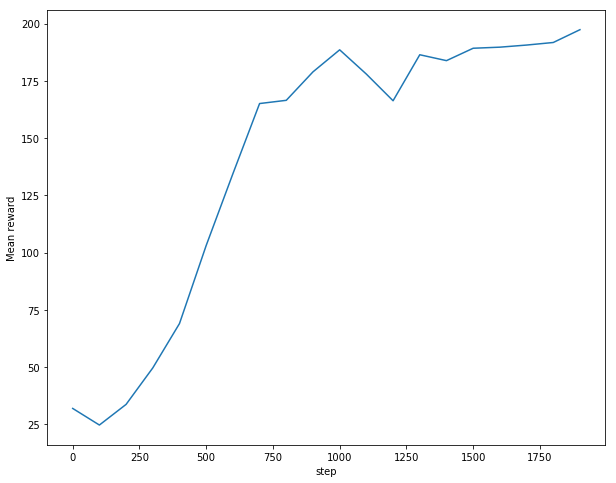

In [15]:

plt.plot(*zip(*mean_rewards))
plt.xlabel('step')
plt.ylabel('Mean reward')





0-th Episode



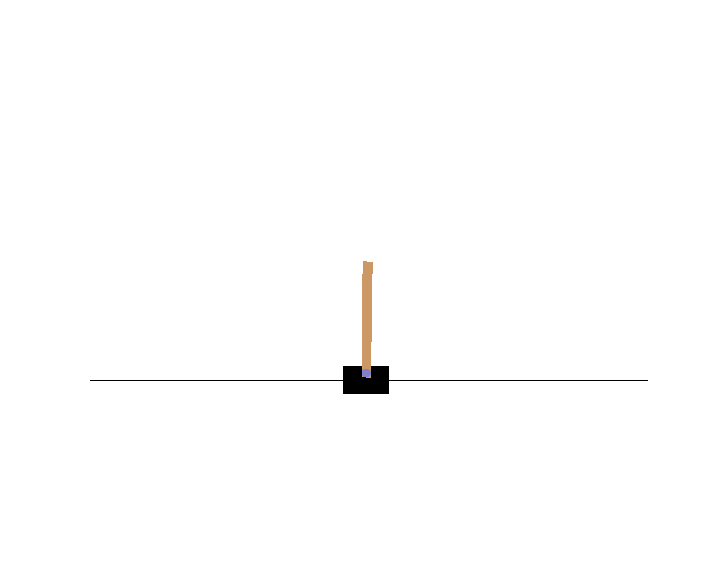
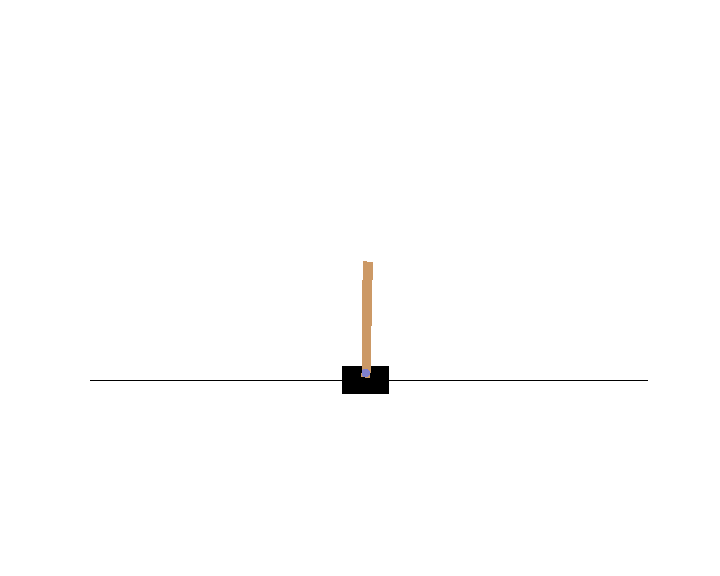
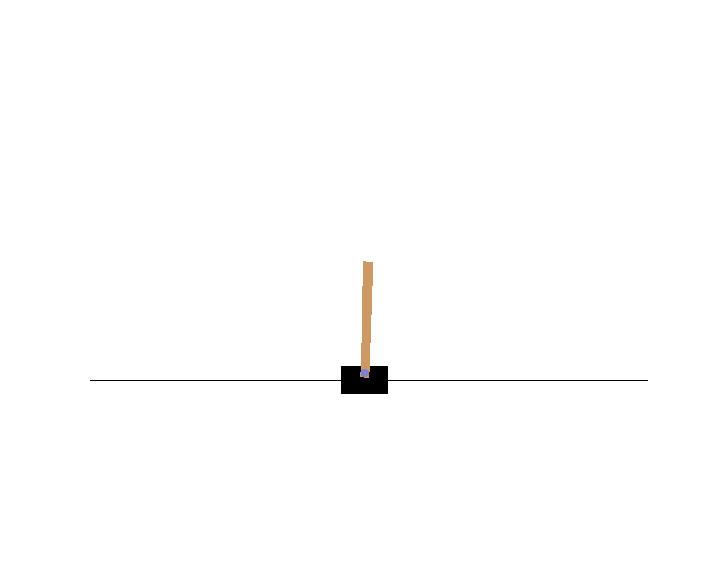
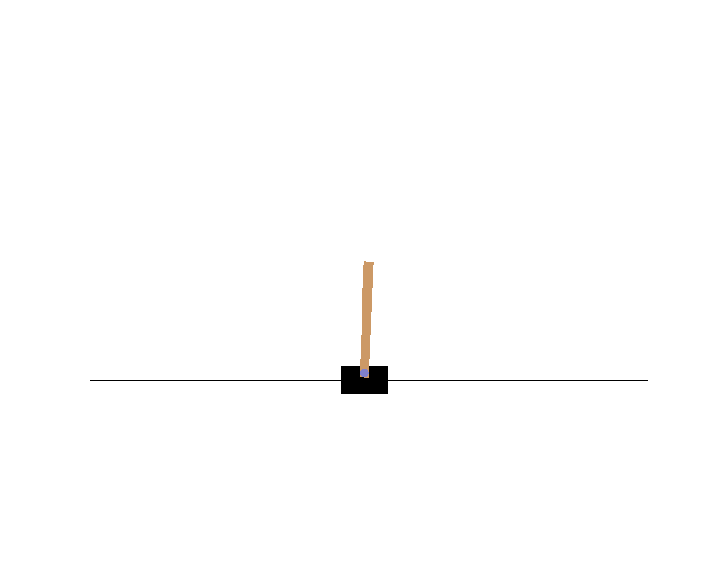
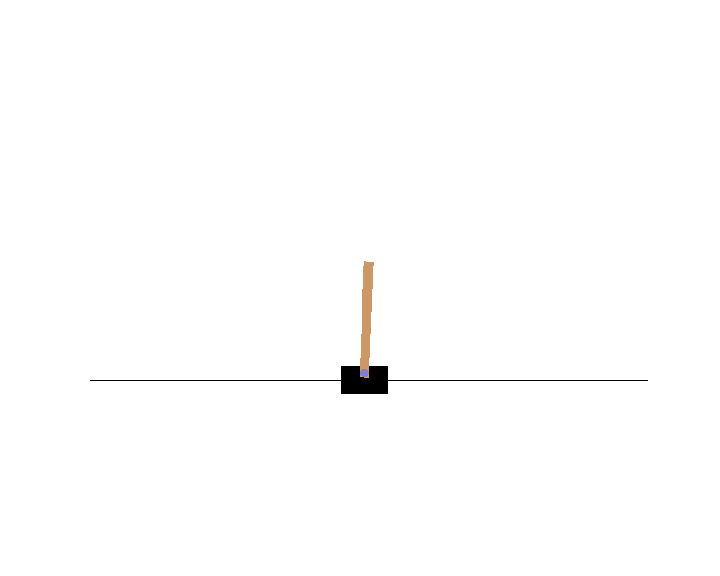
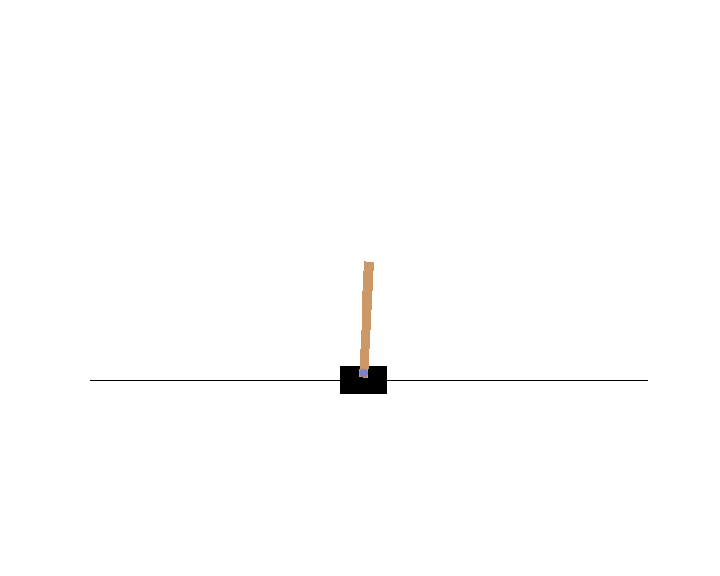
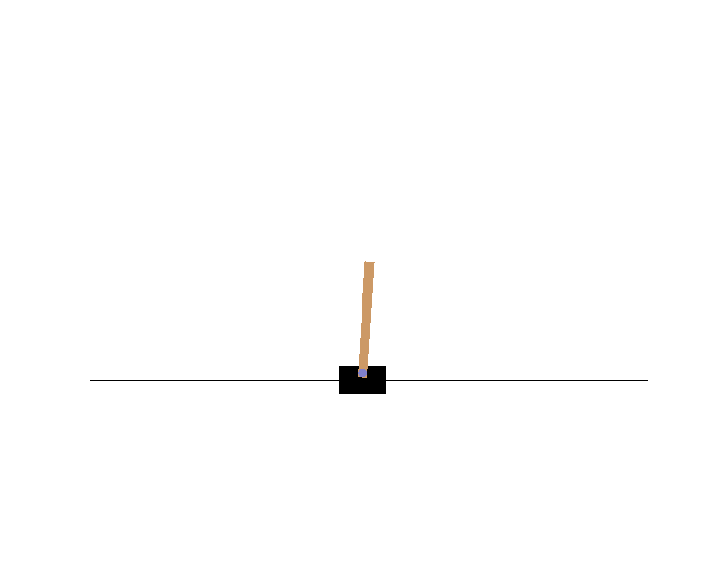
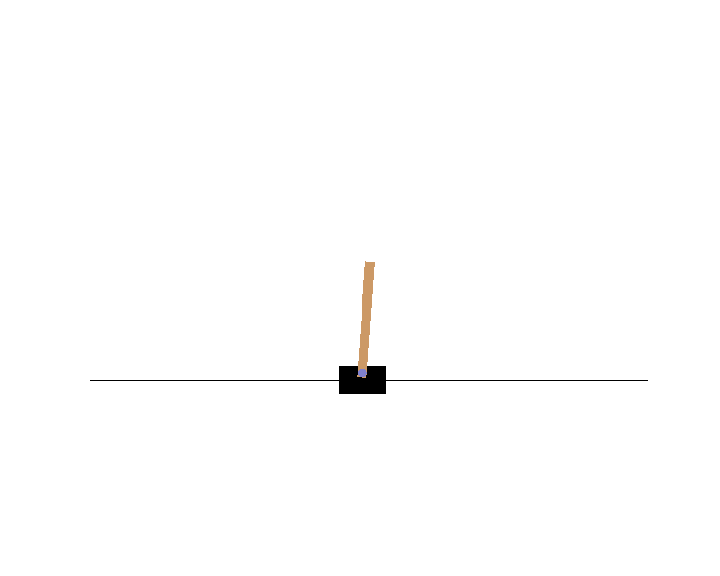
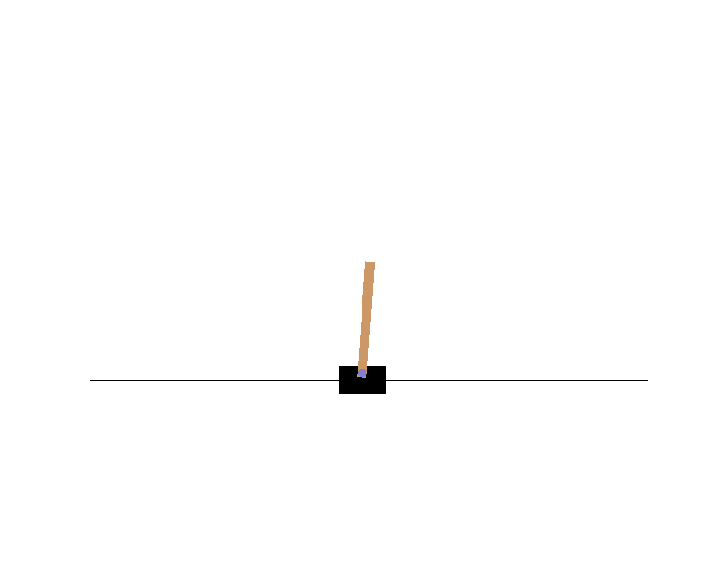
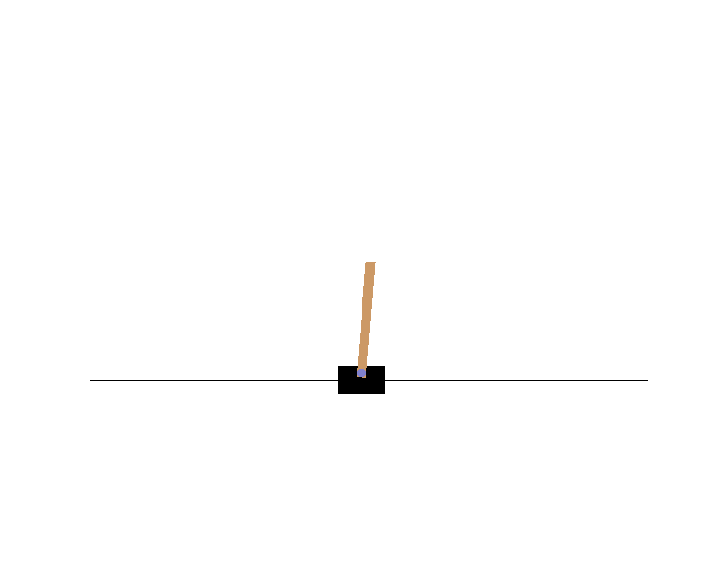
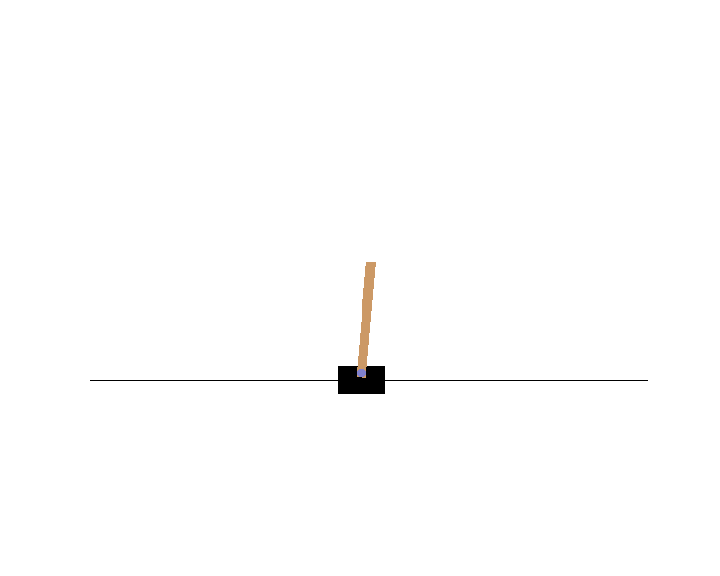
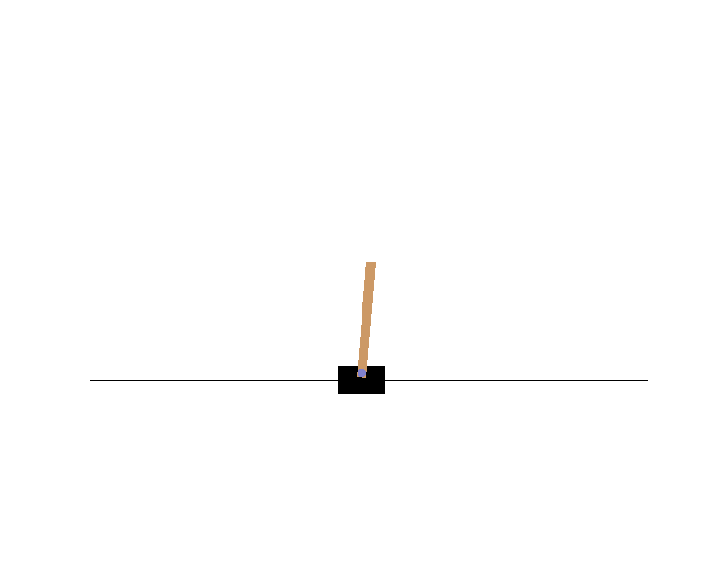
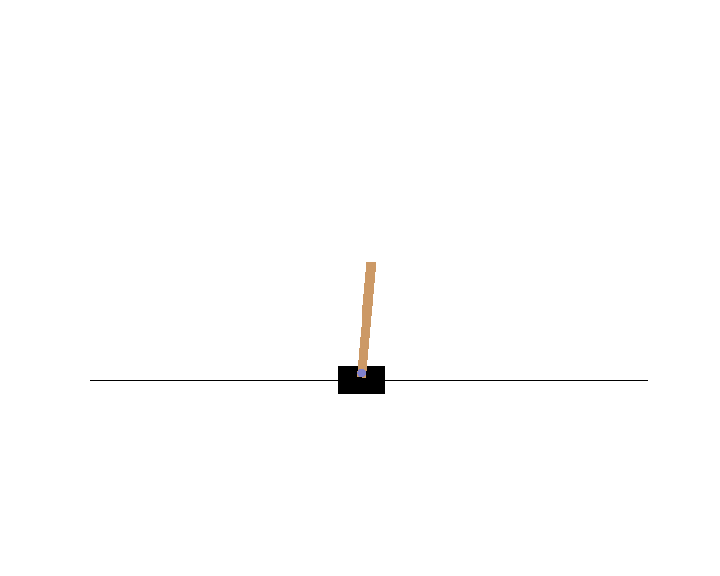
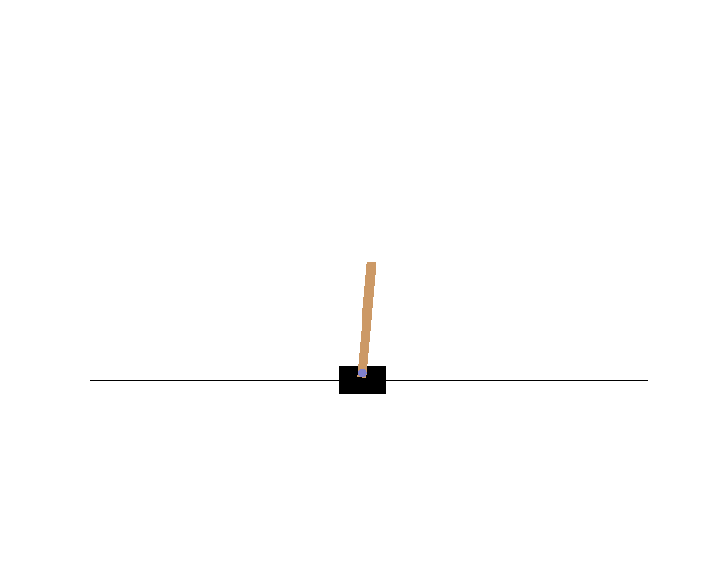
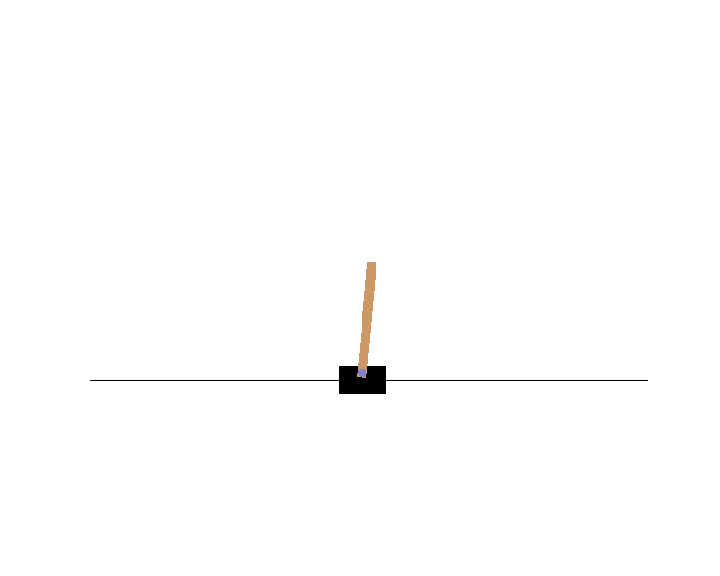
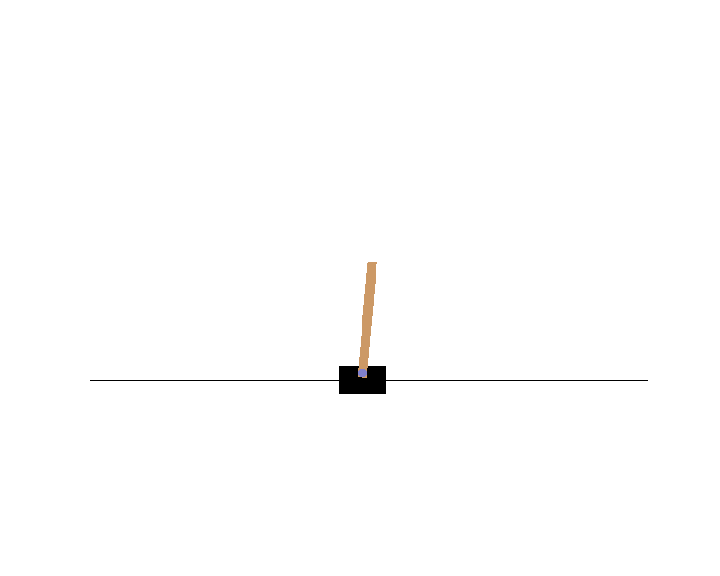
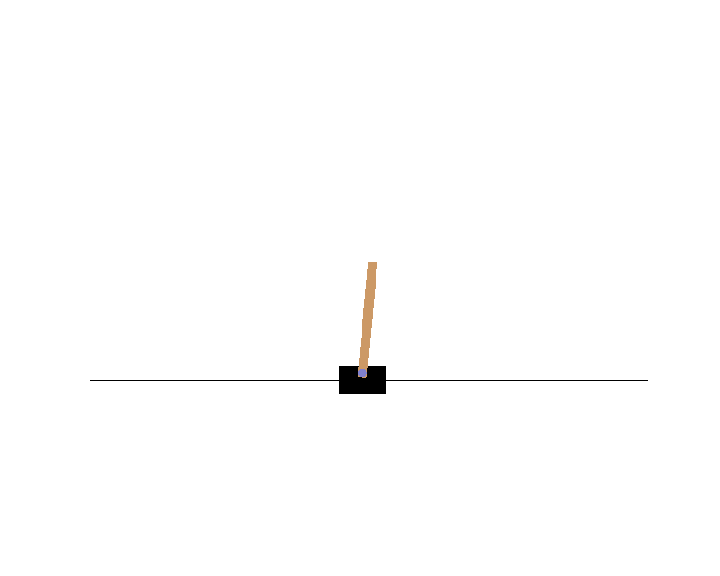
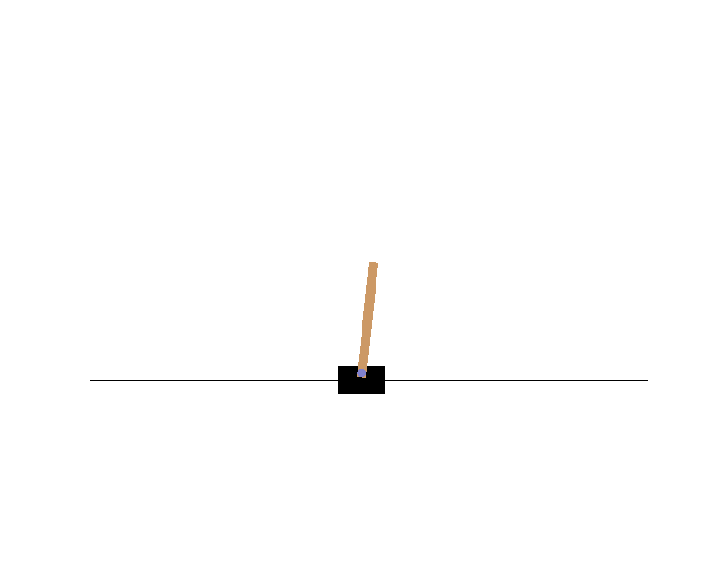
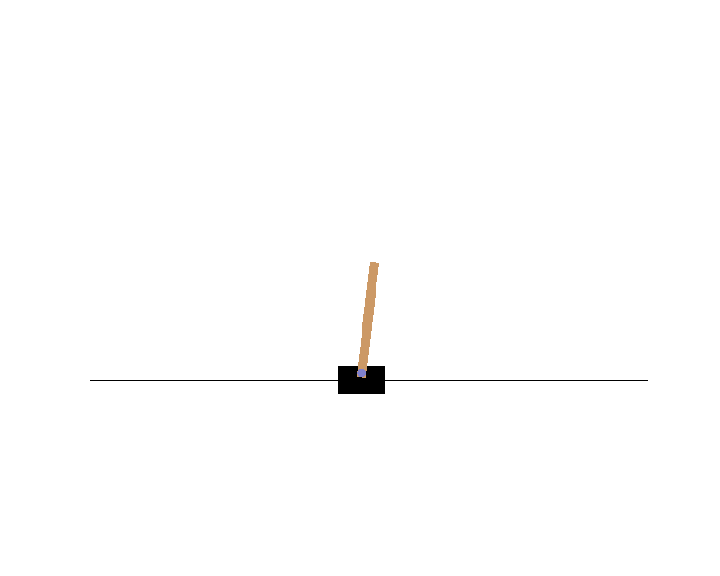
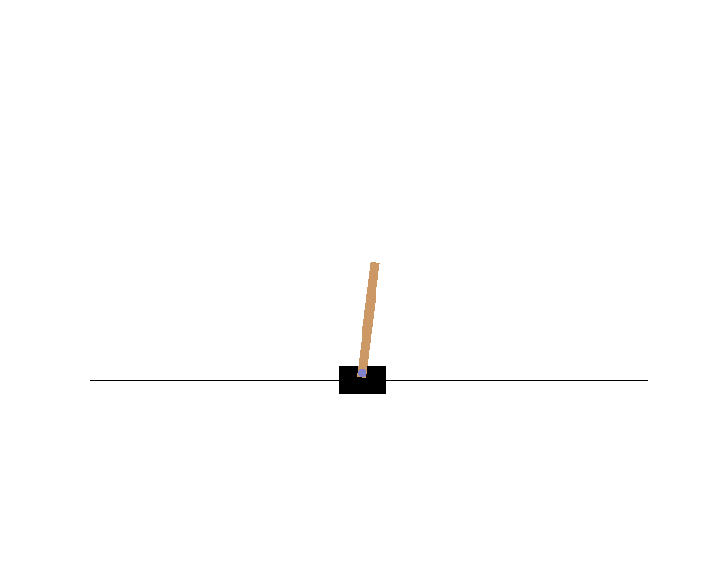
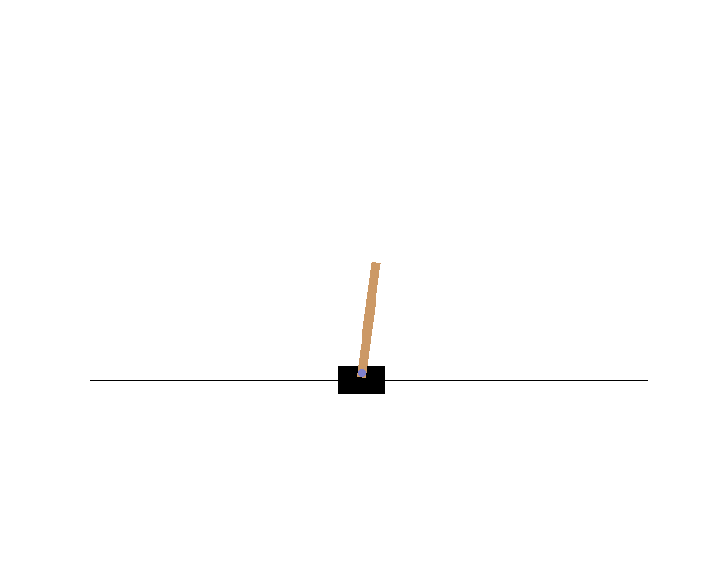
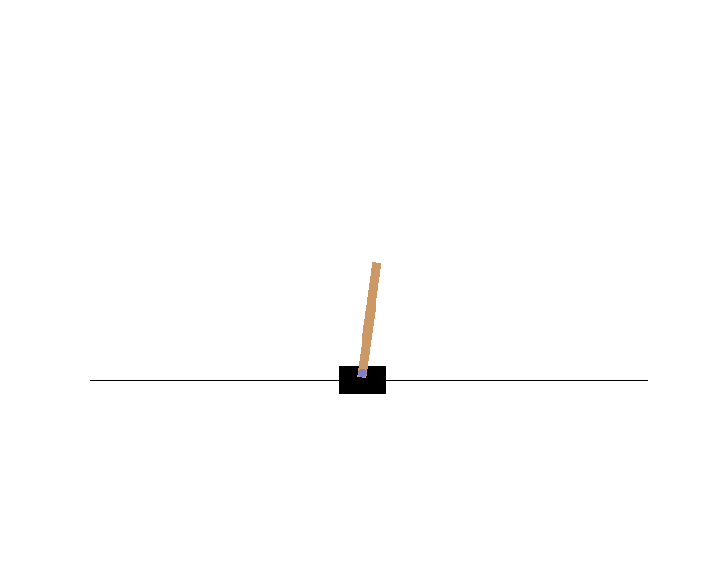
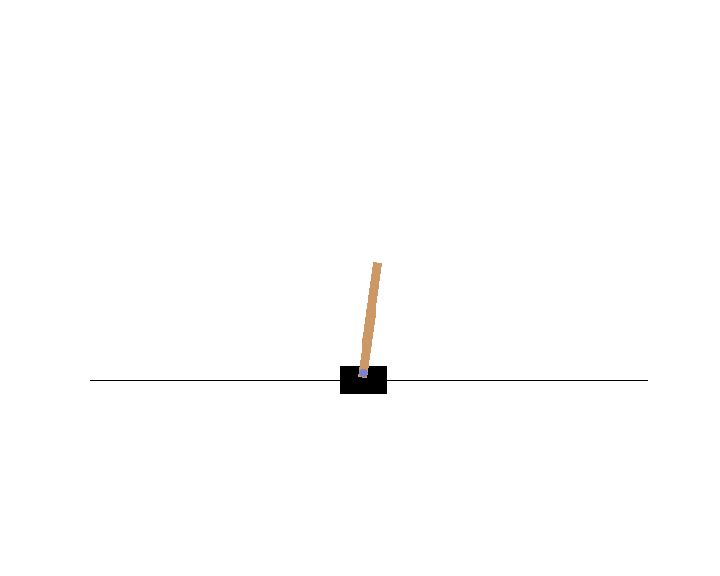
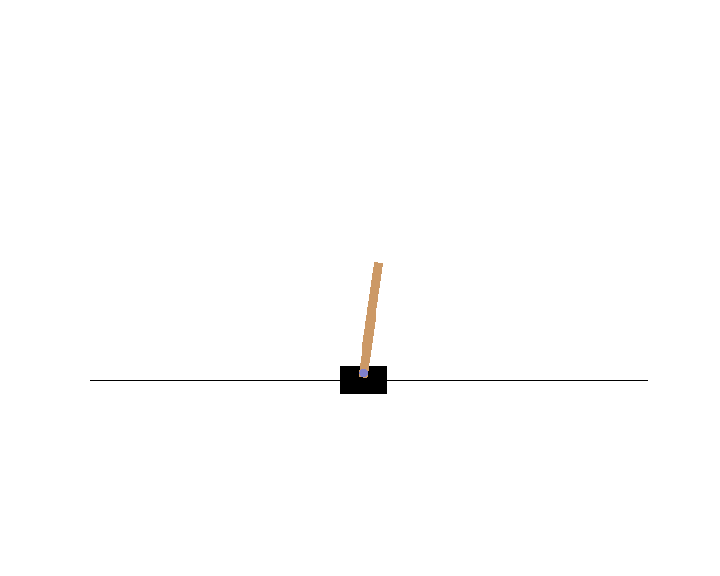
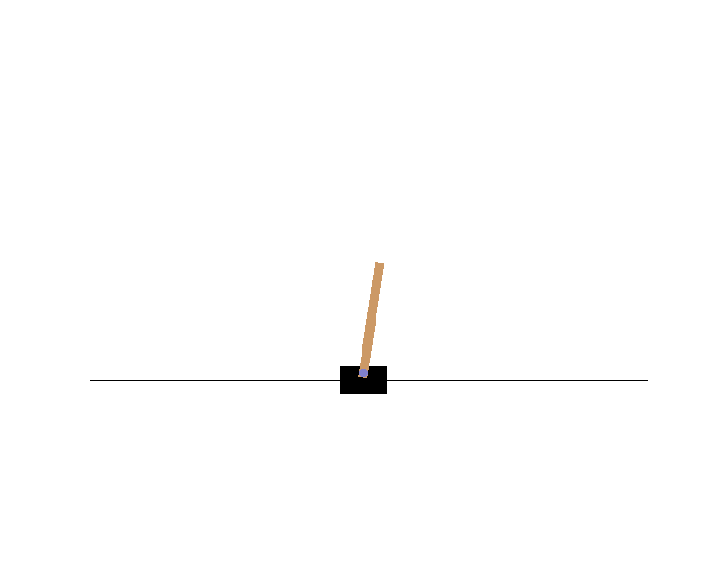
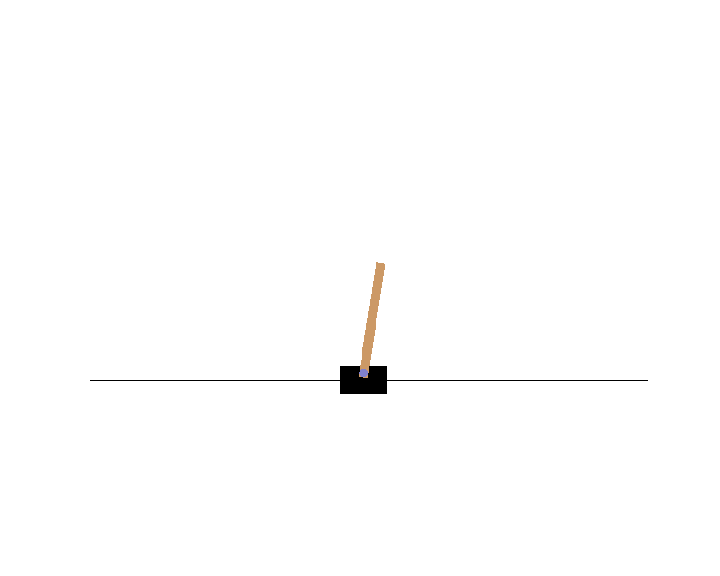
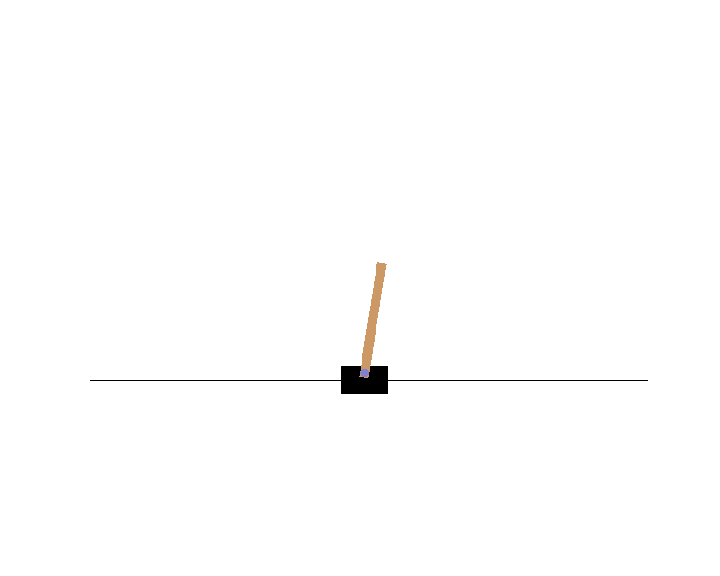
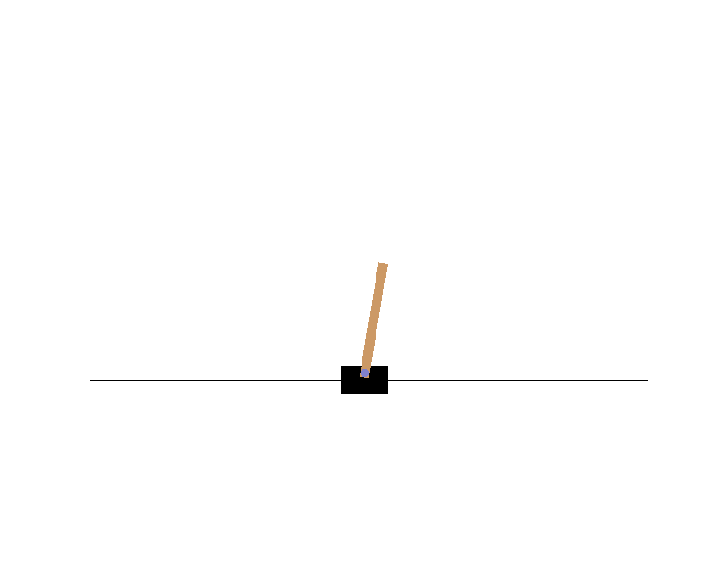
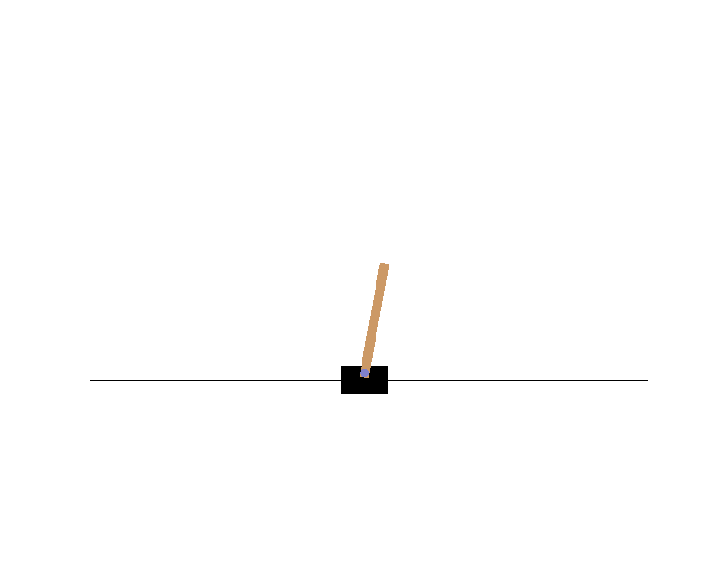
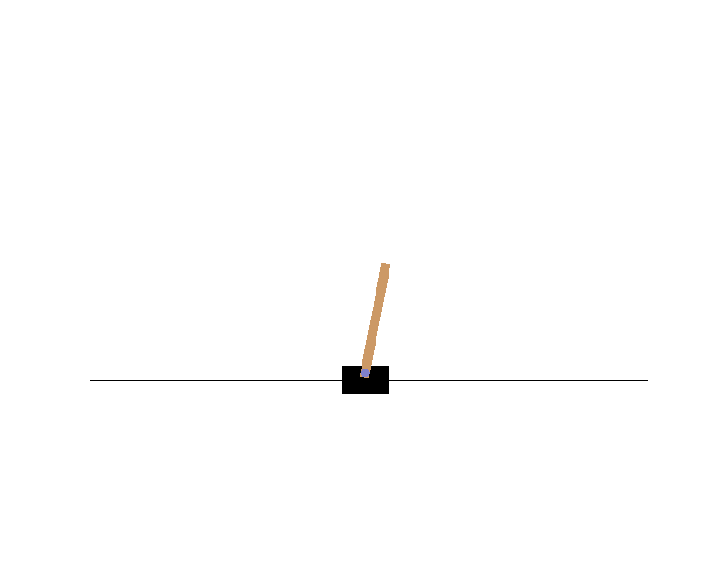
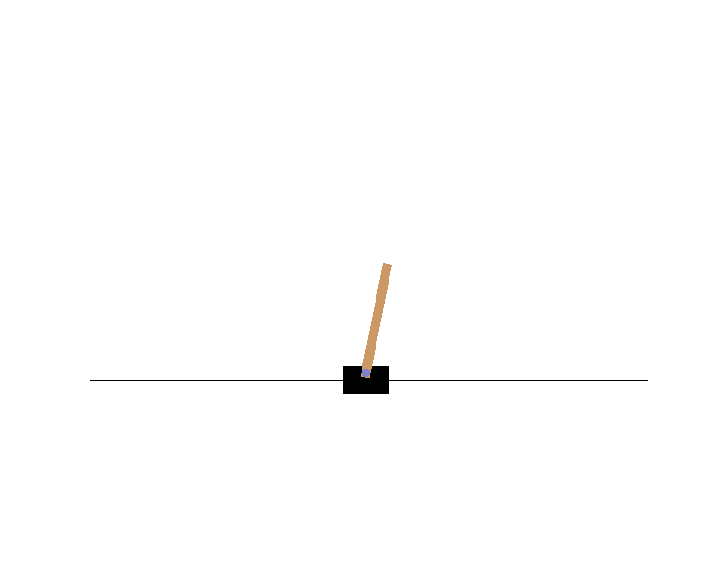
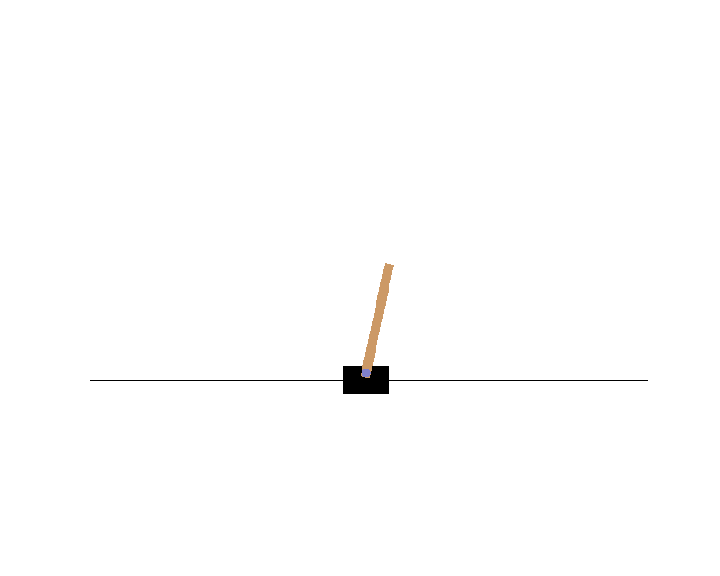

500-th Episode



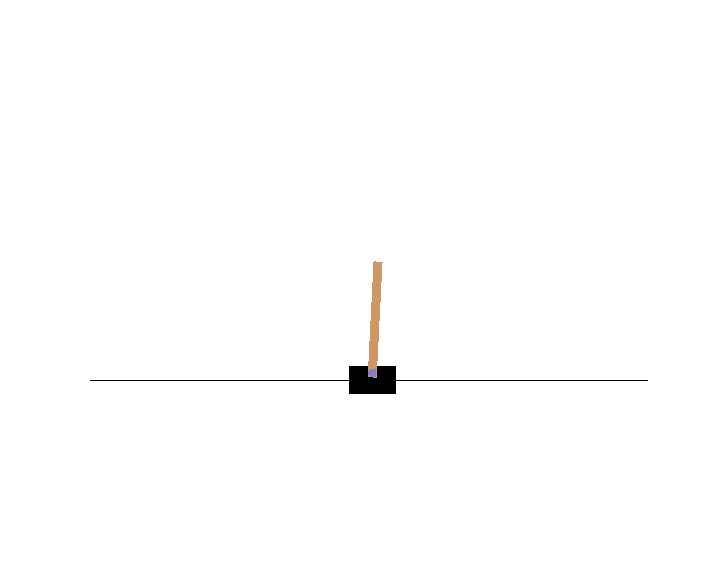
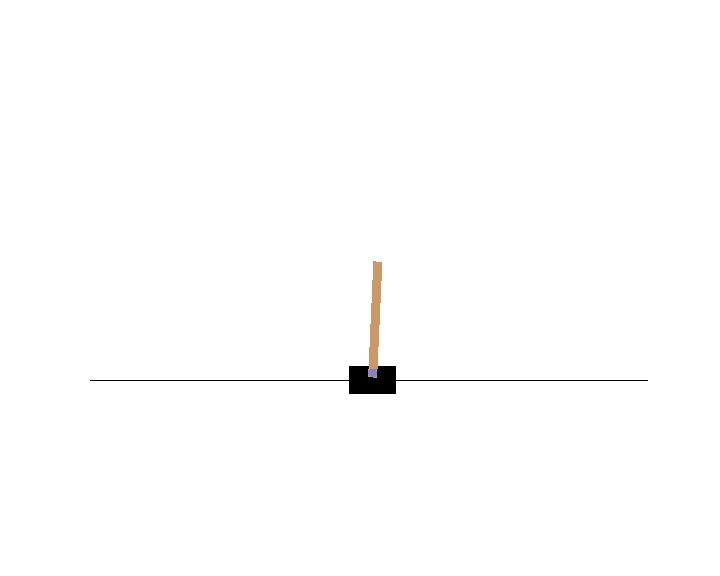
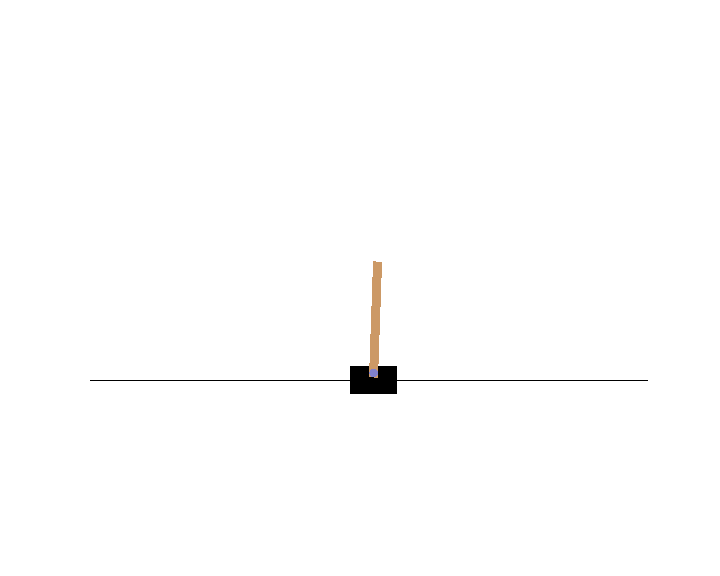
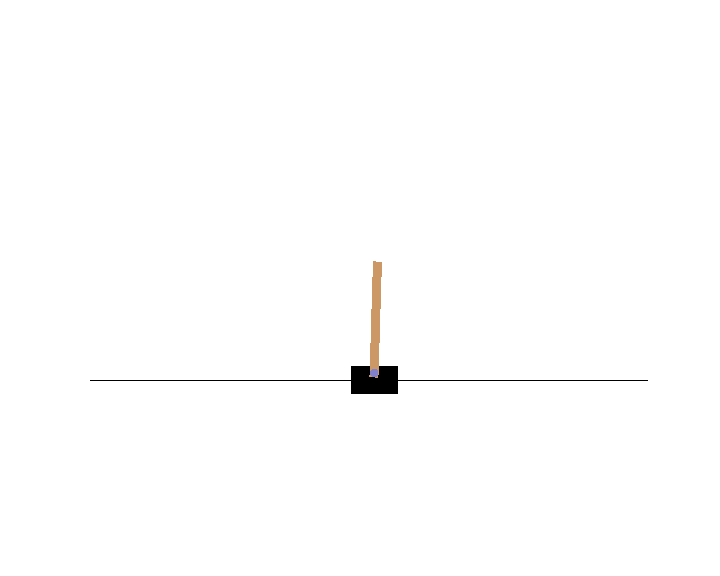
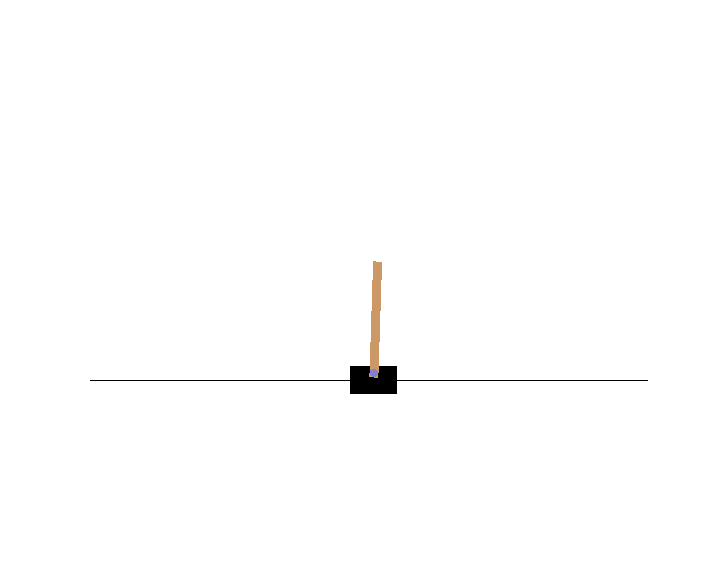
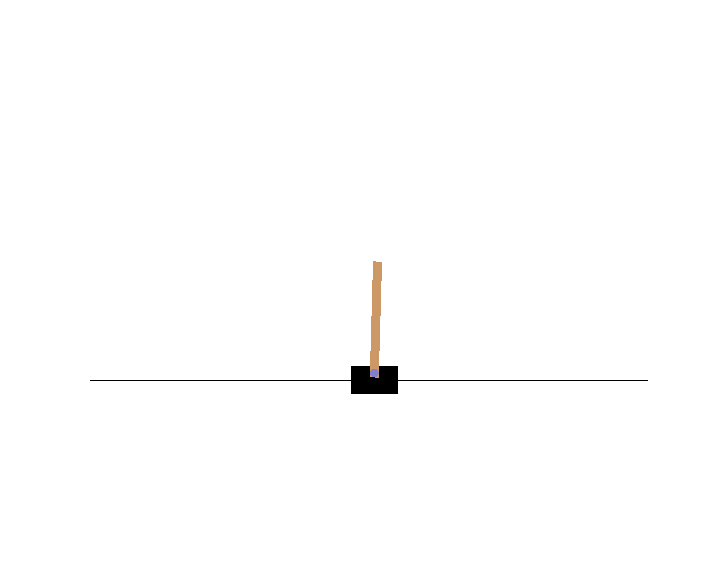
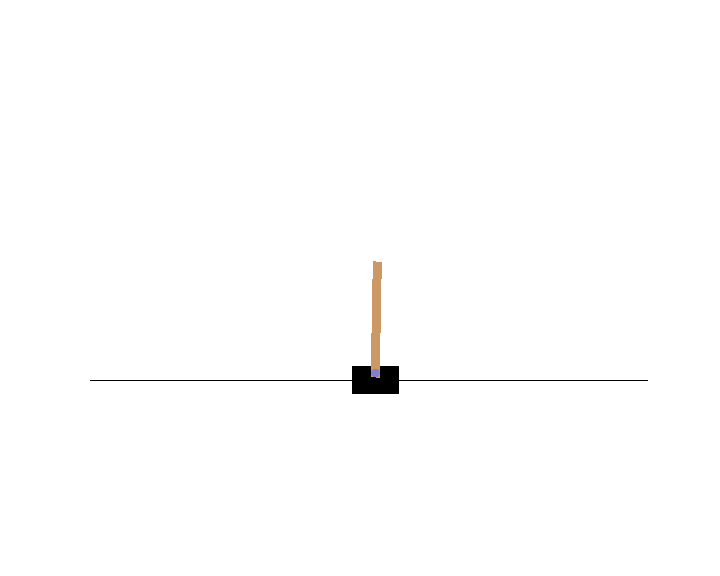
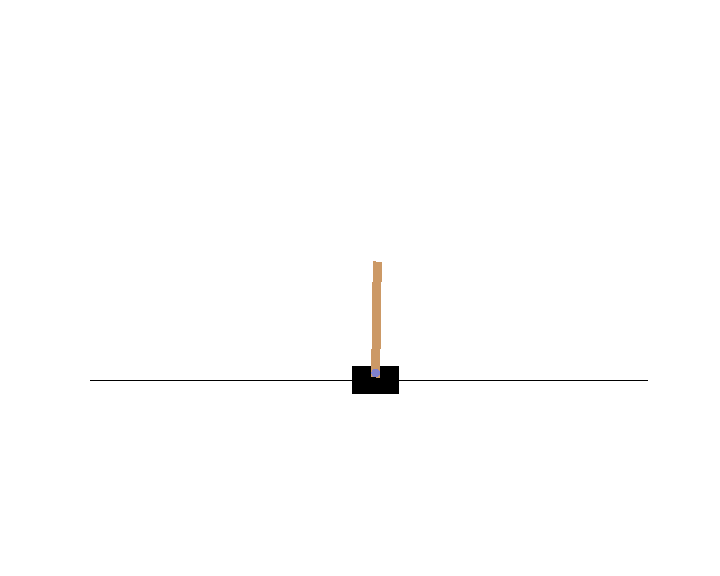
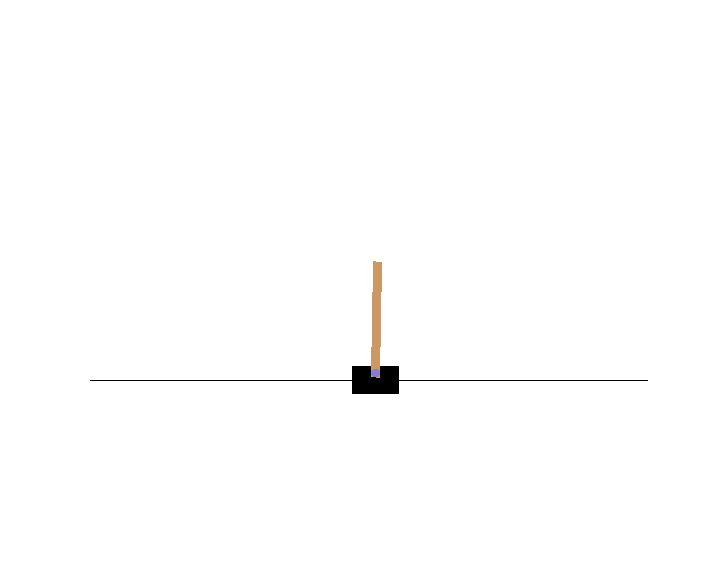
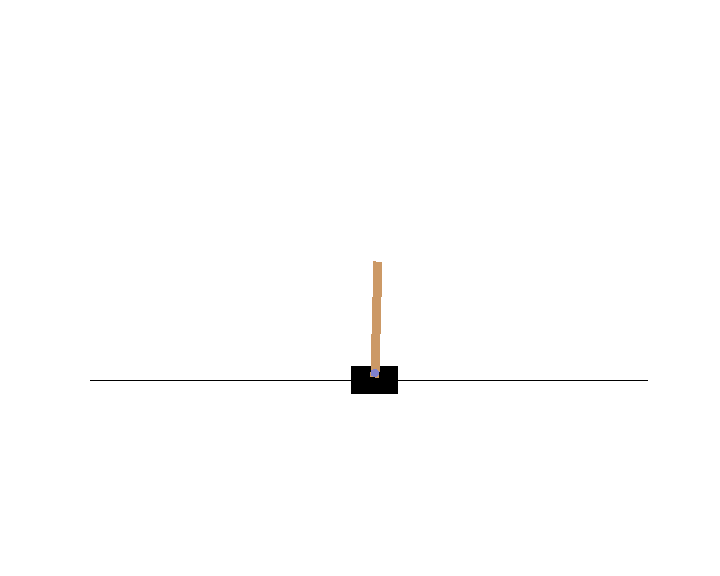
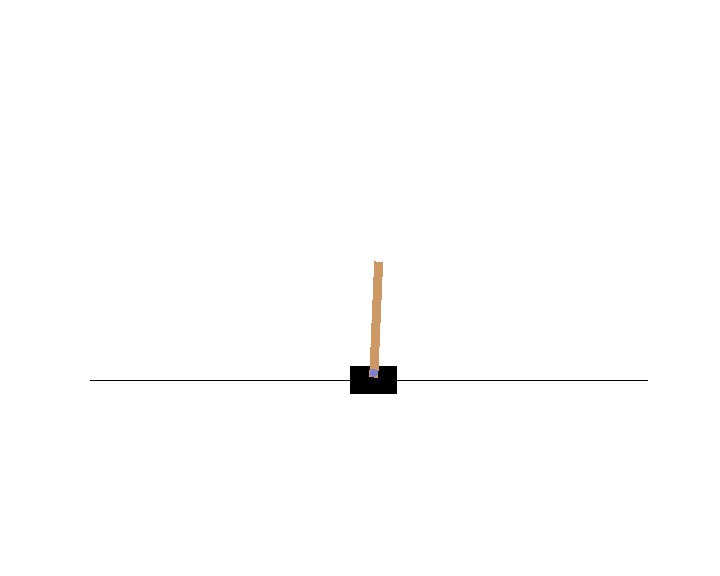
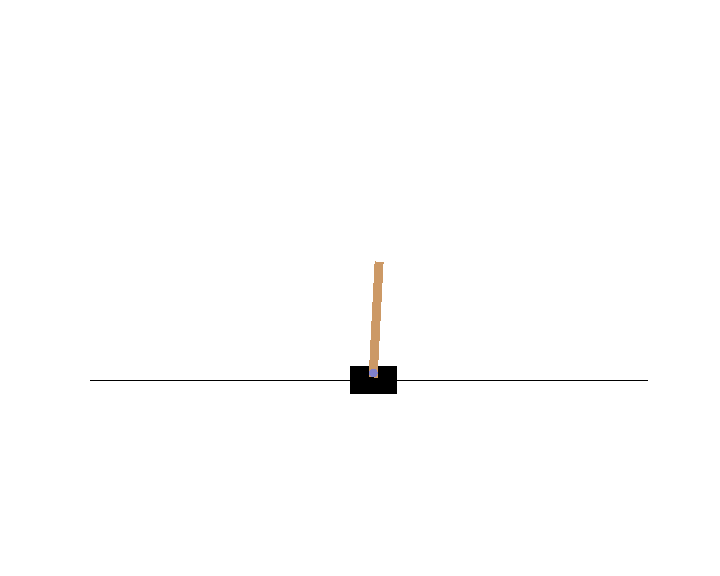
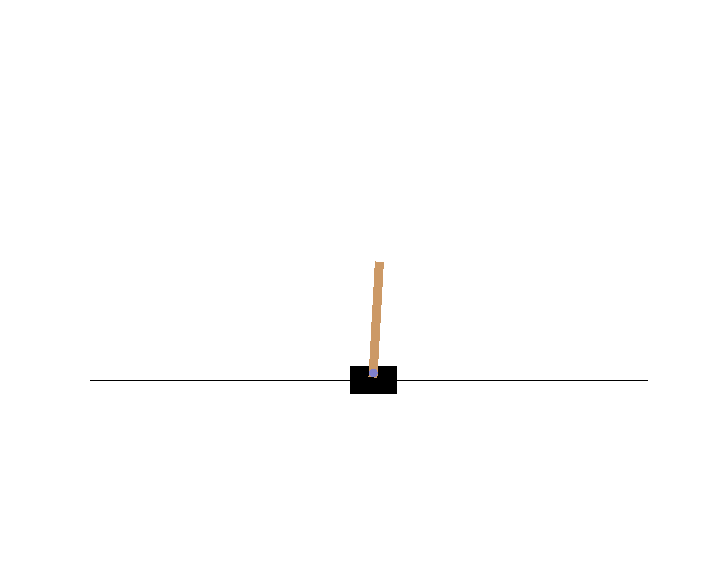
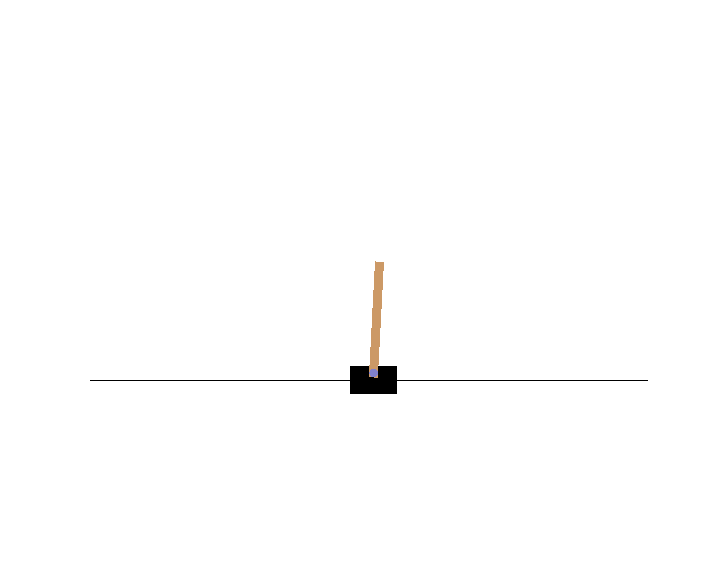
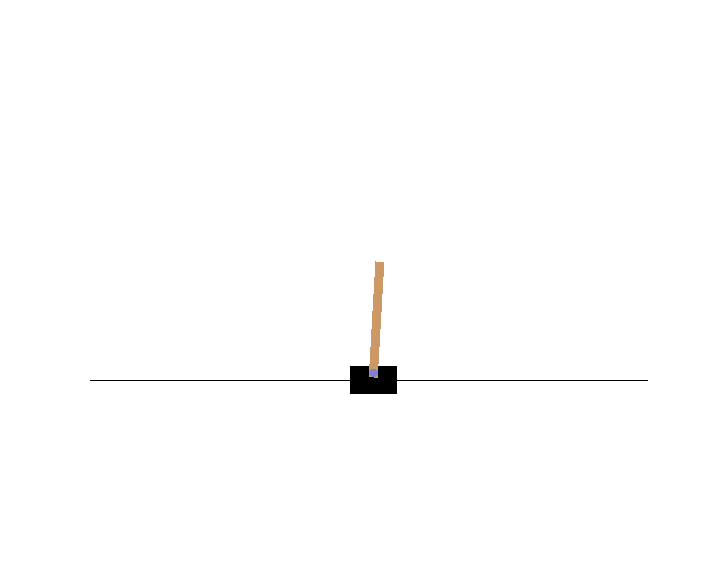
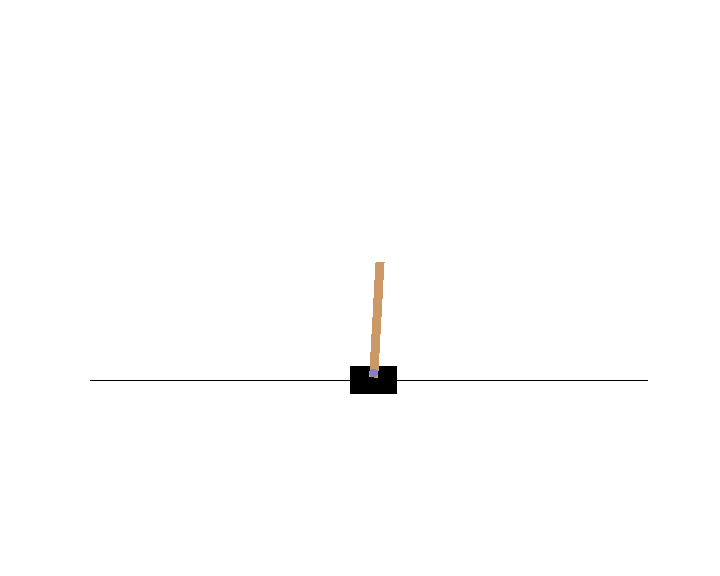
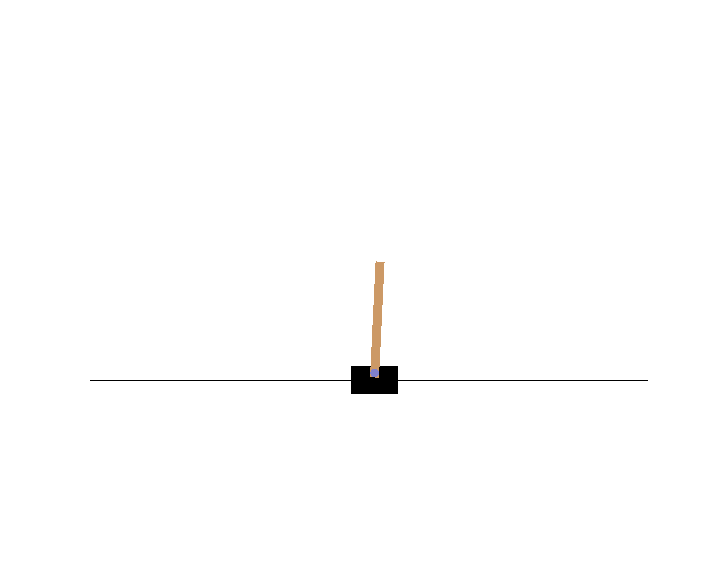
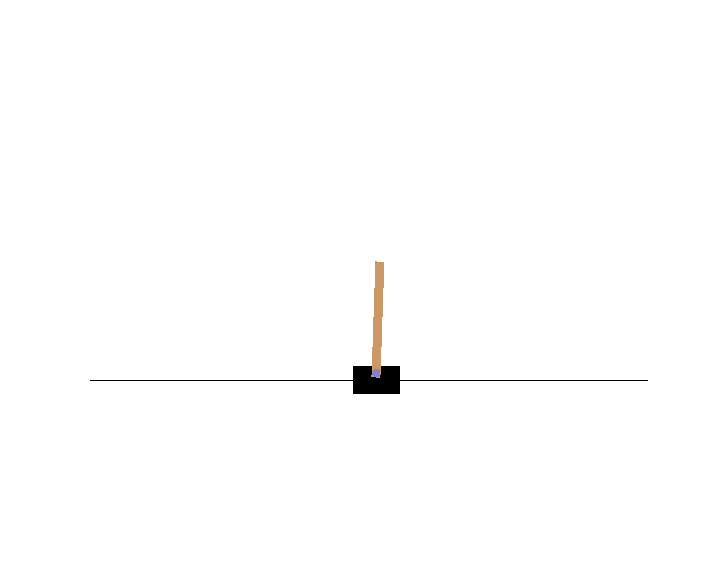
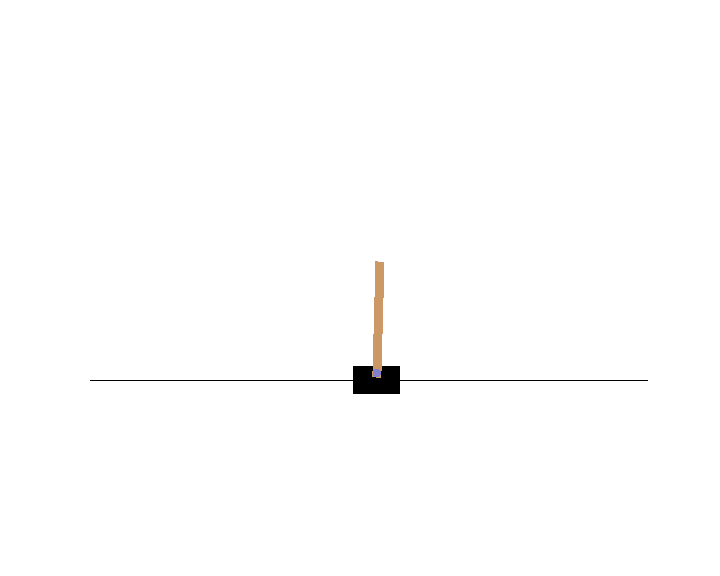
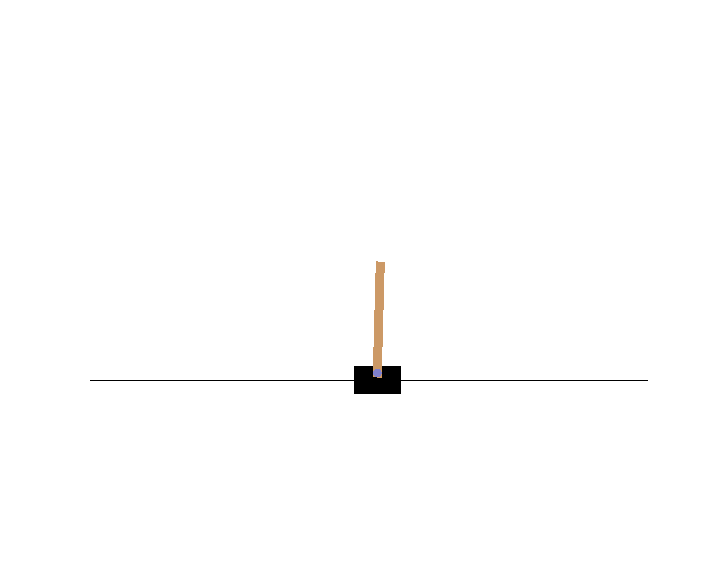
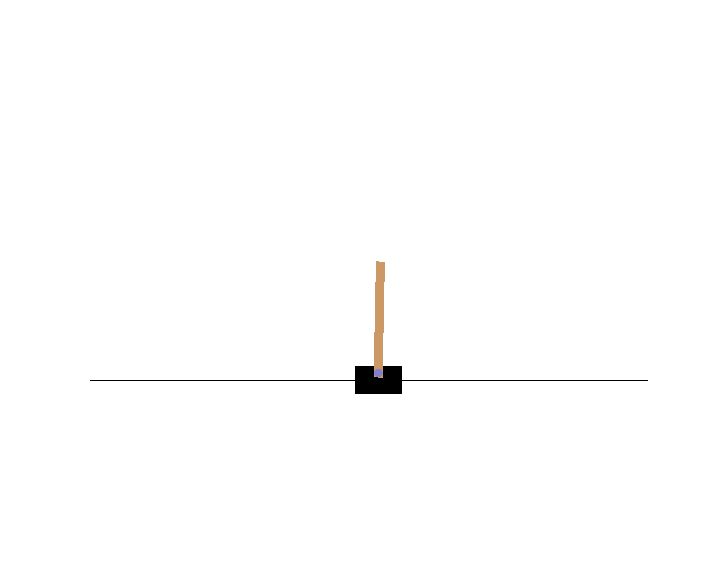
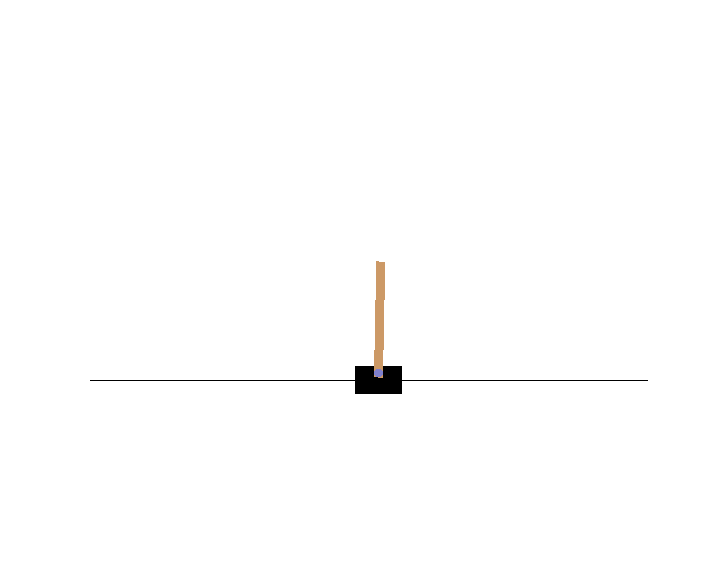
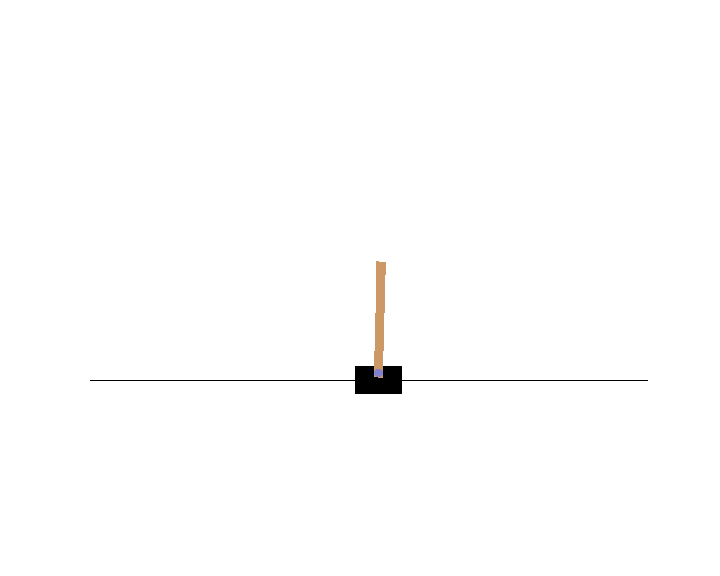
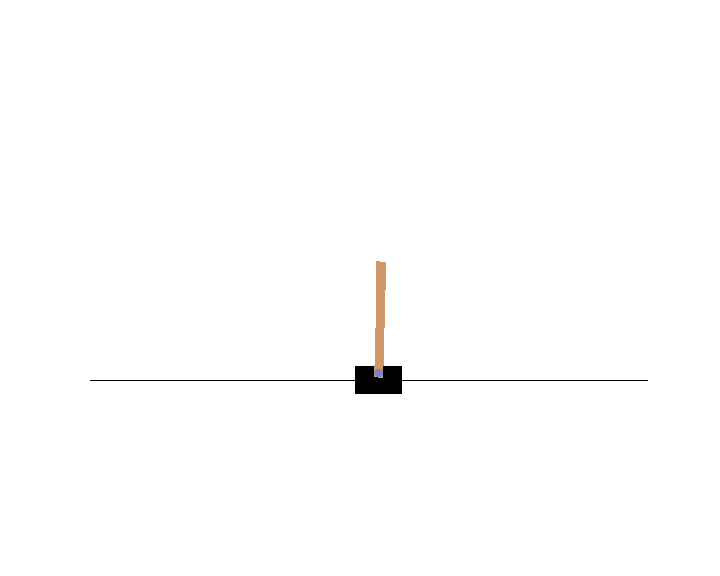
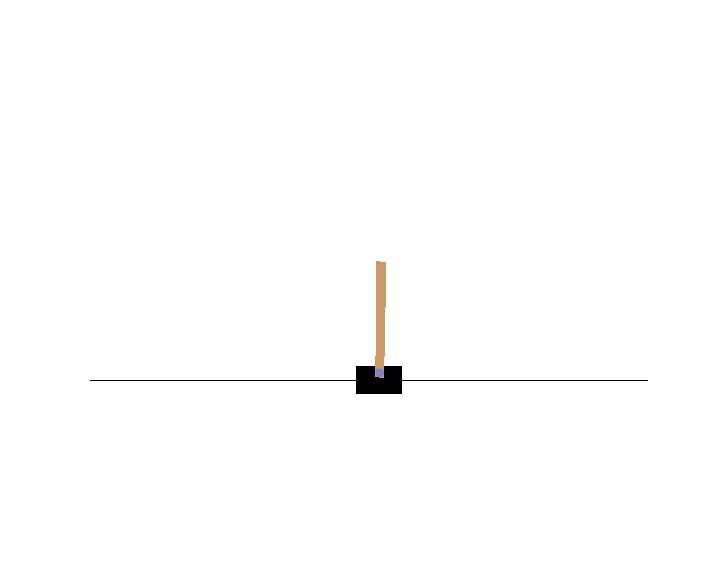
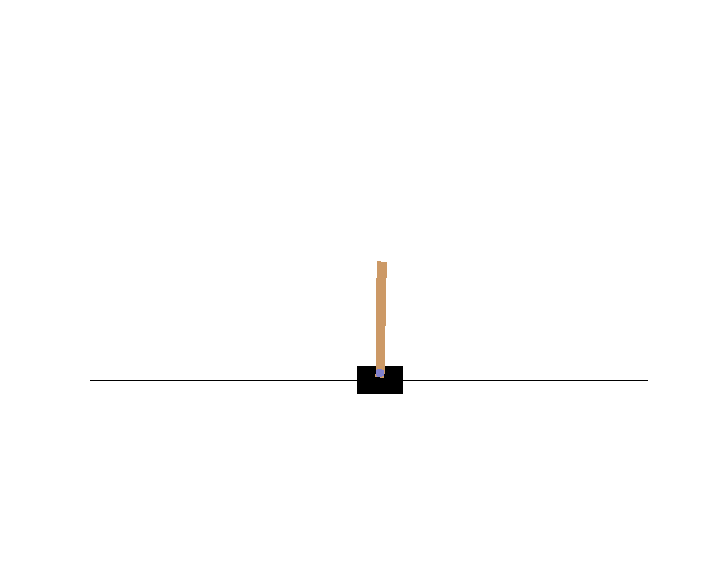
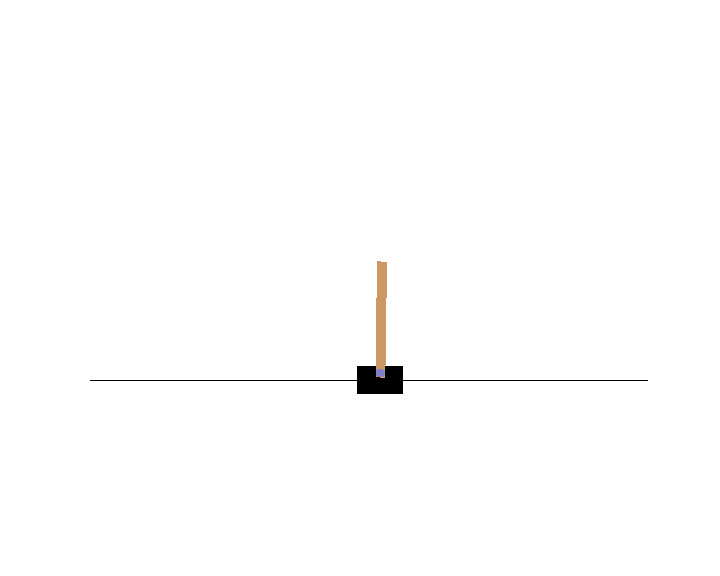
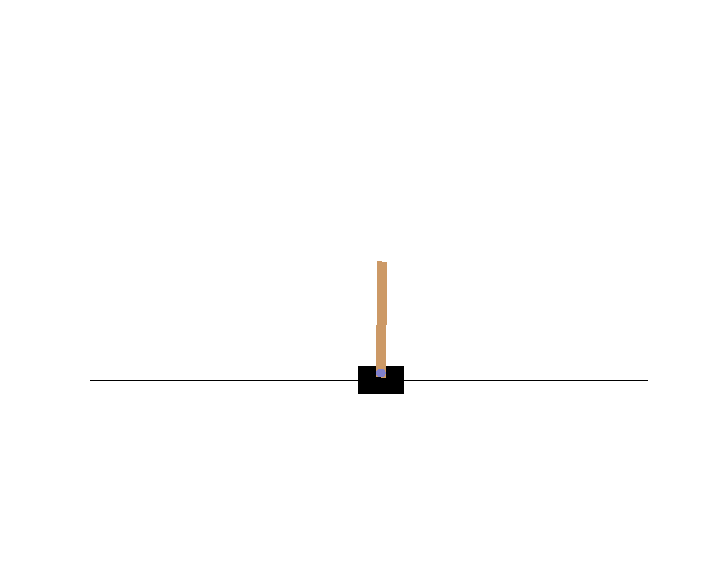
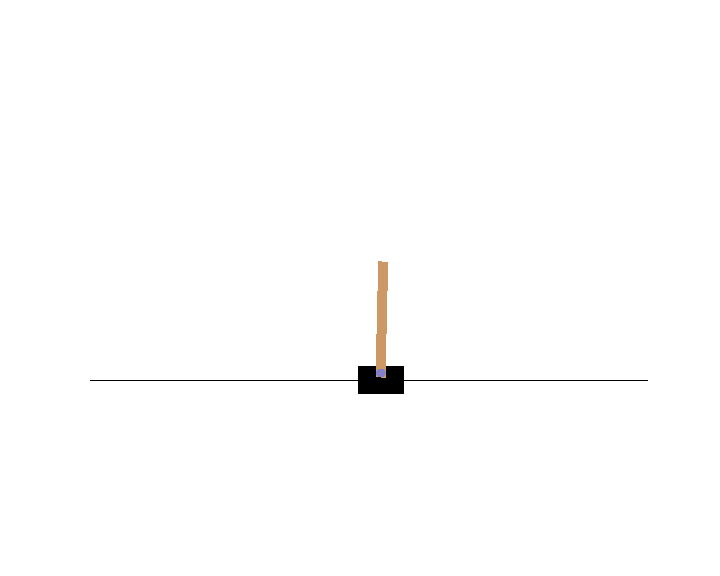
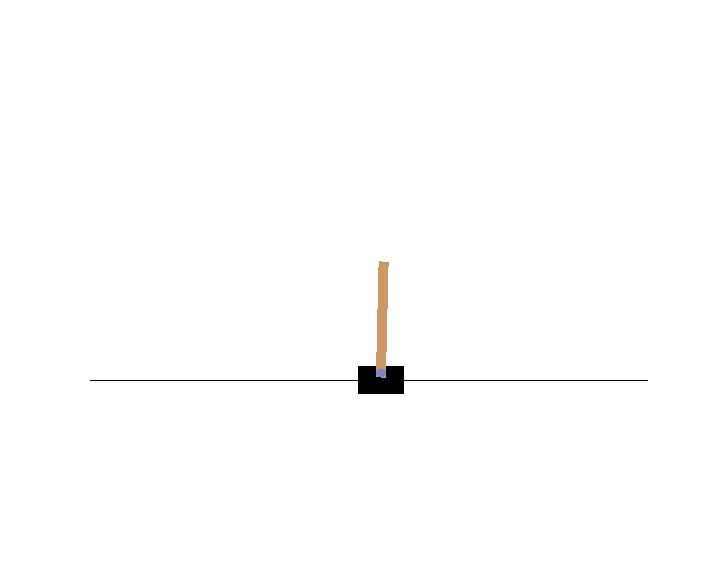
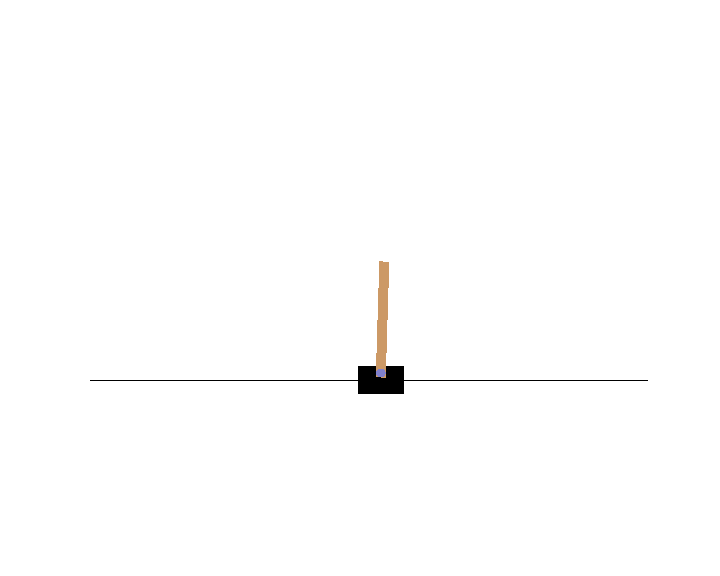
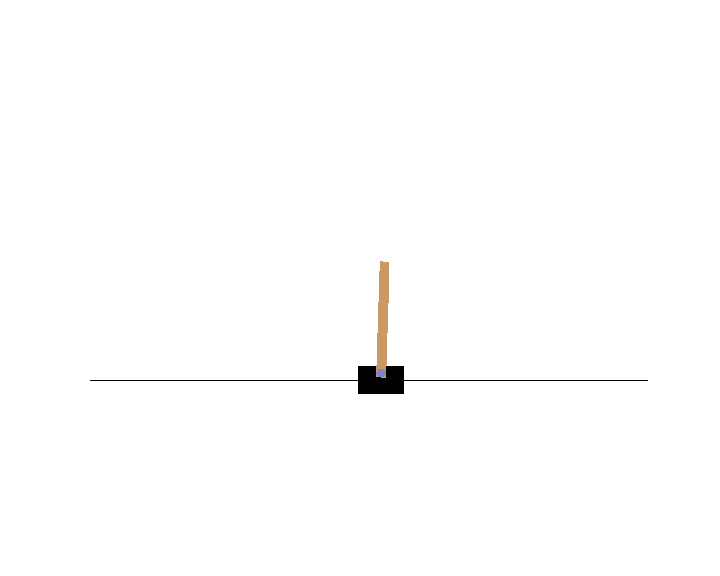
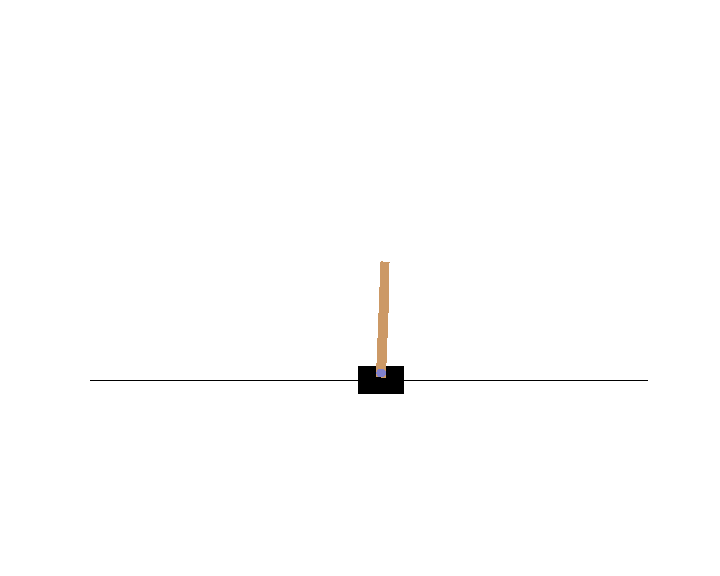
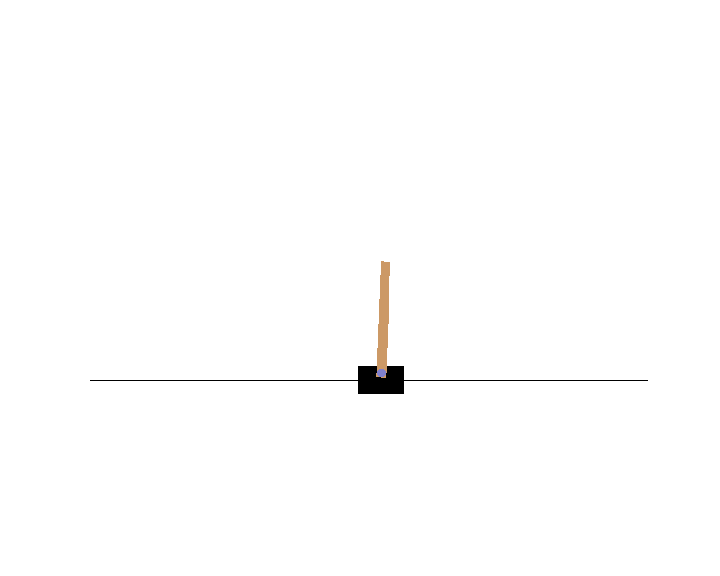
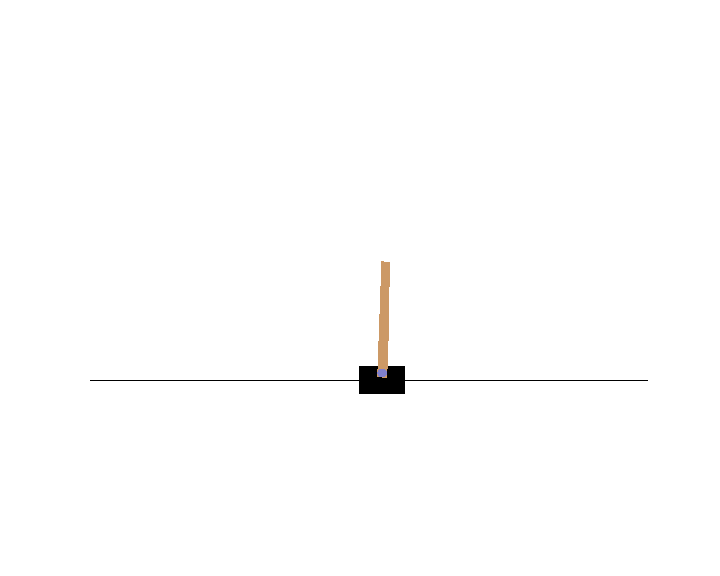
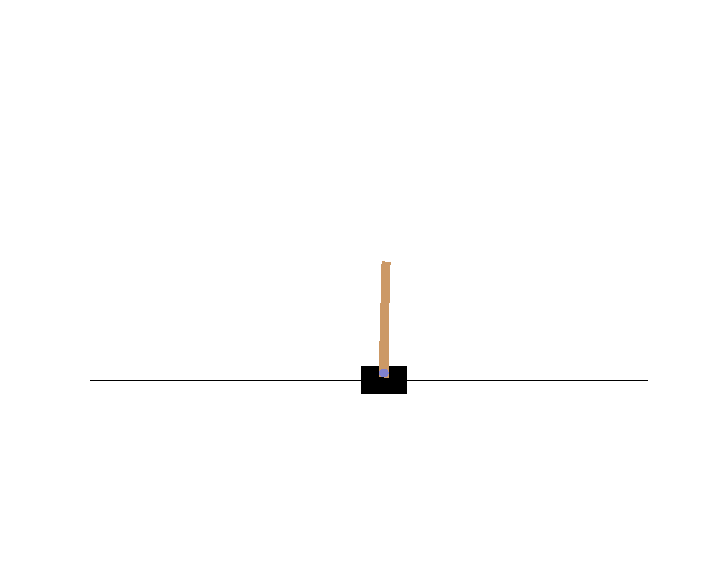
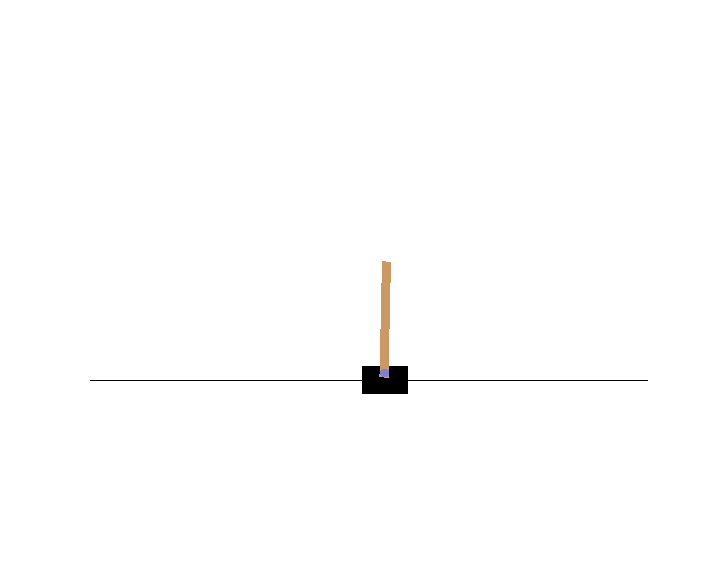
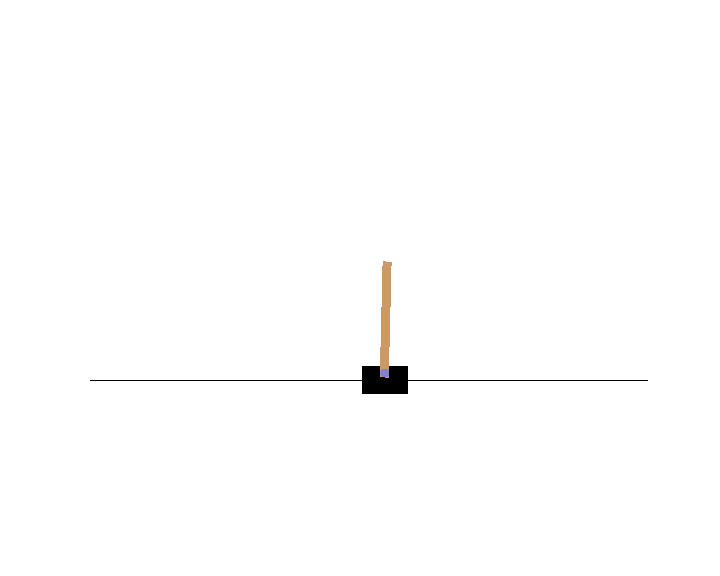
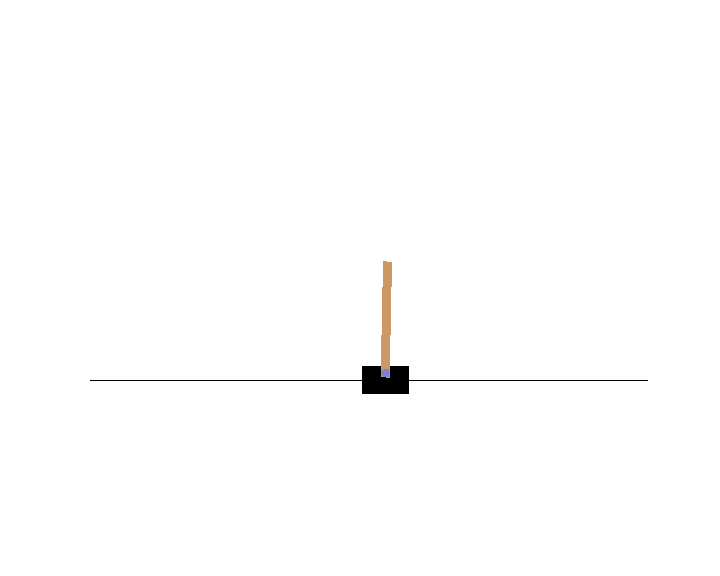
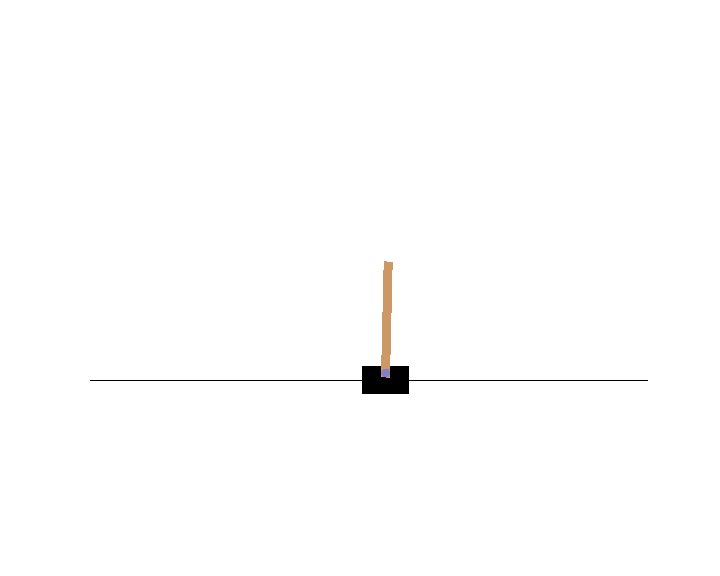
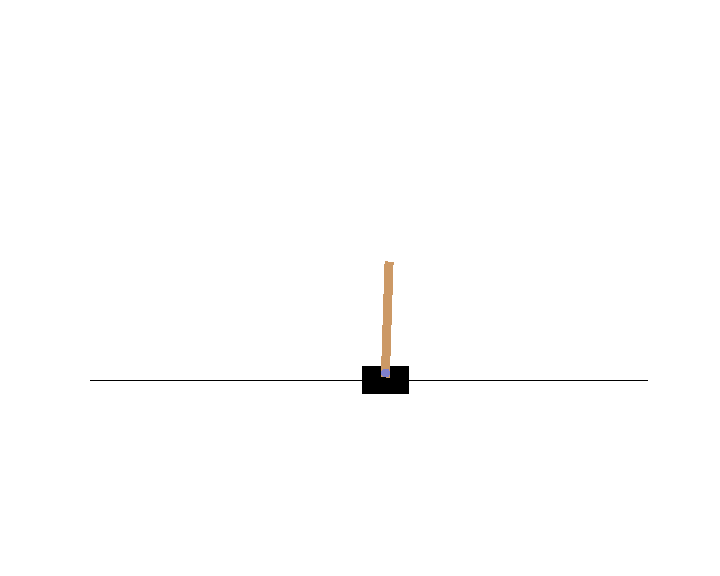
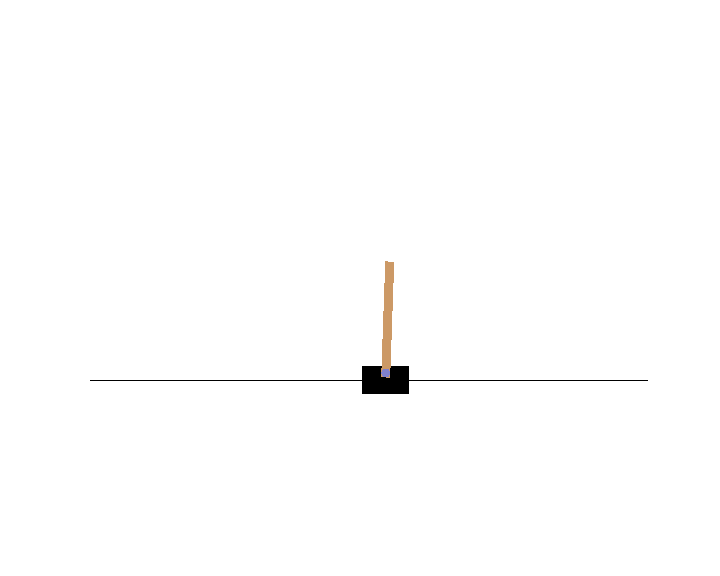
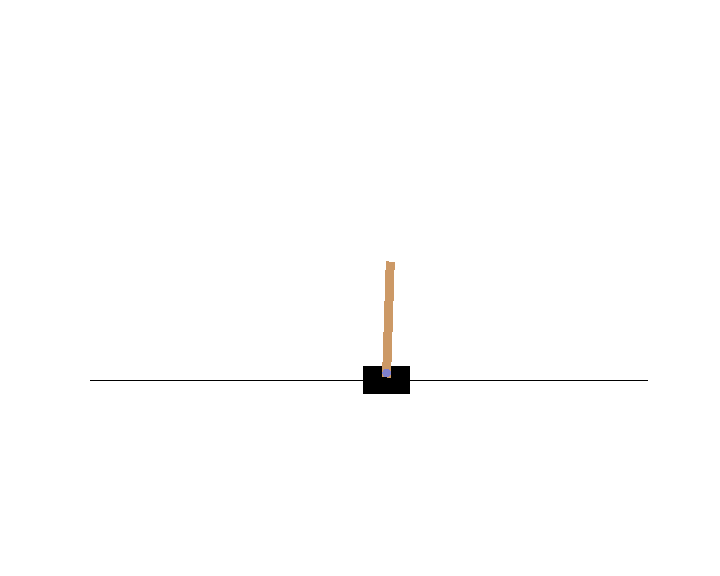
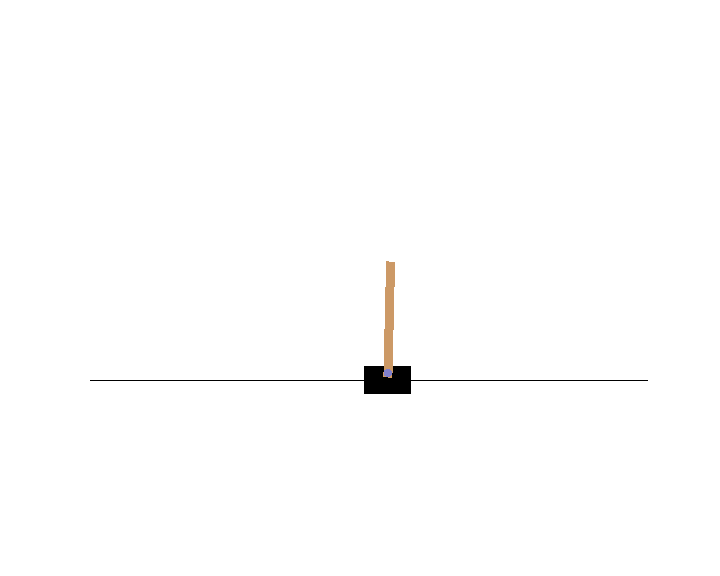
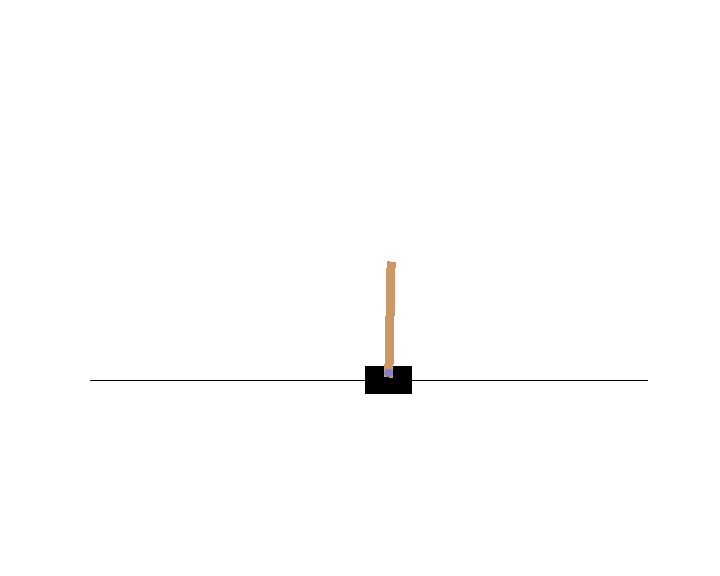
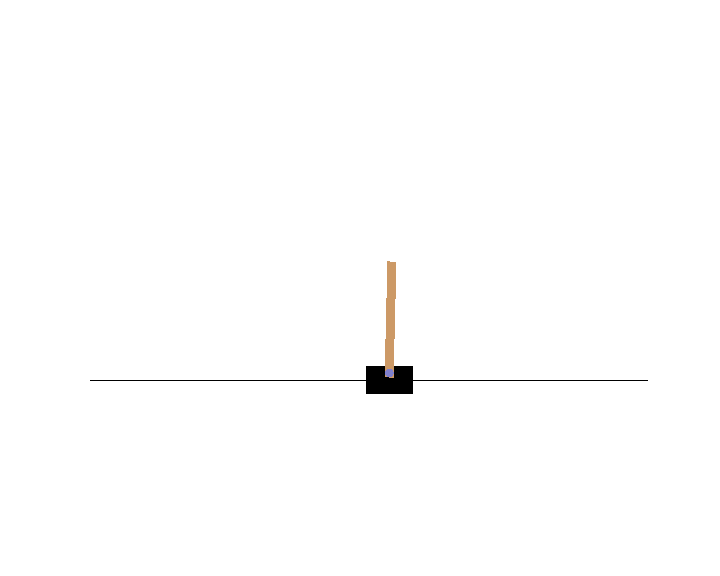
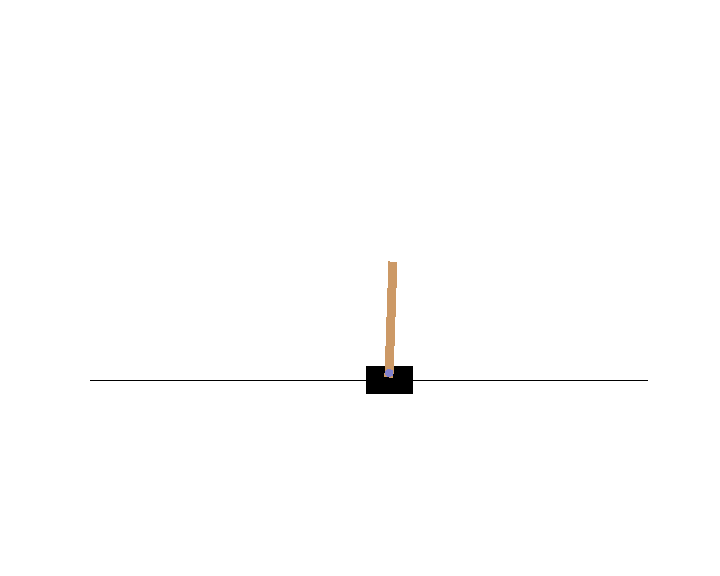
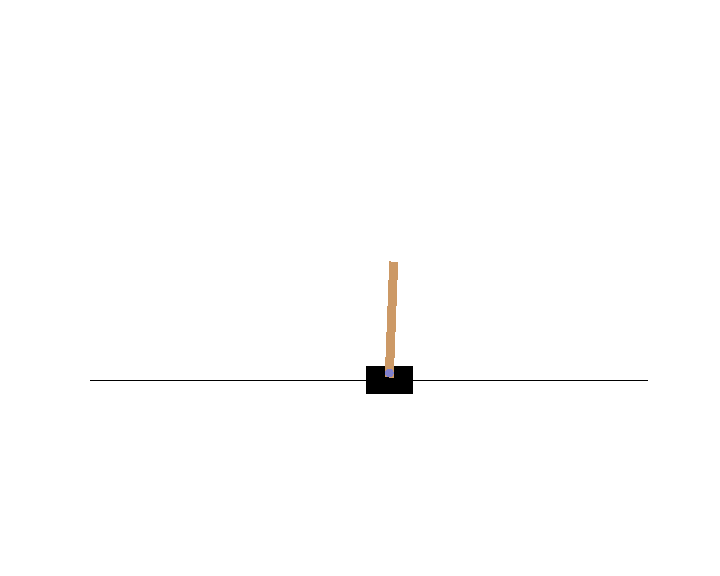
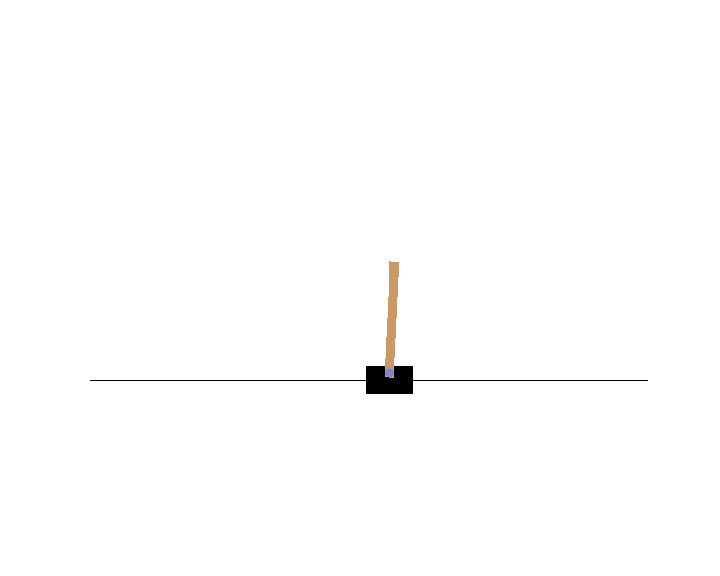
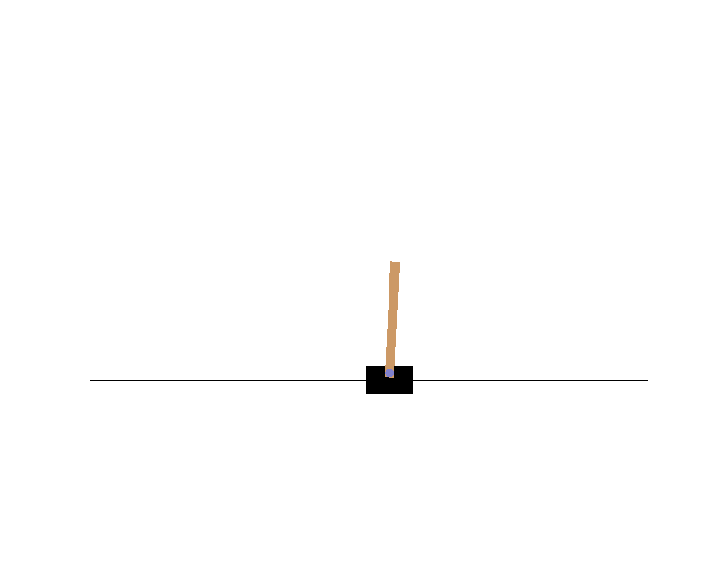
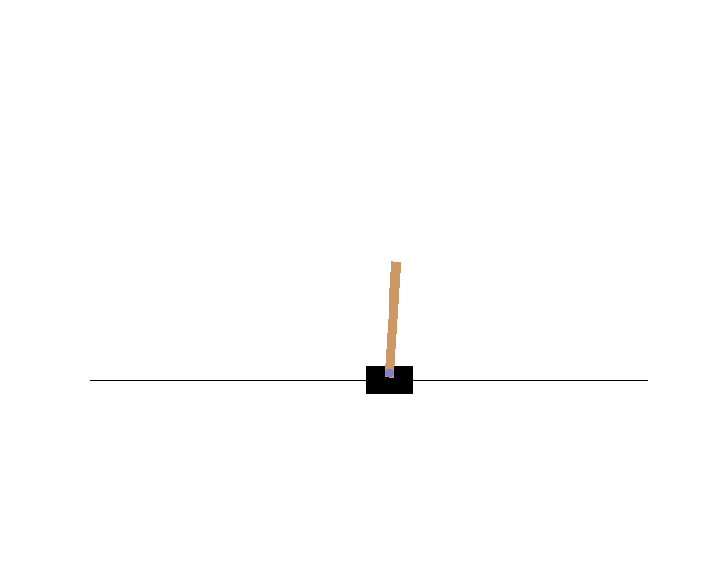
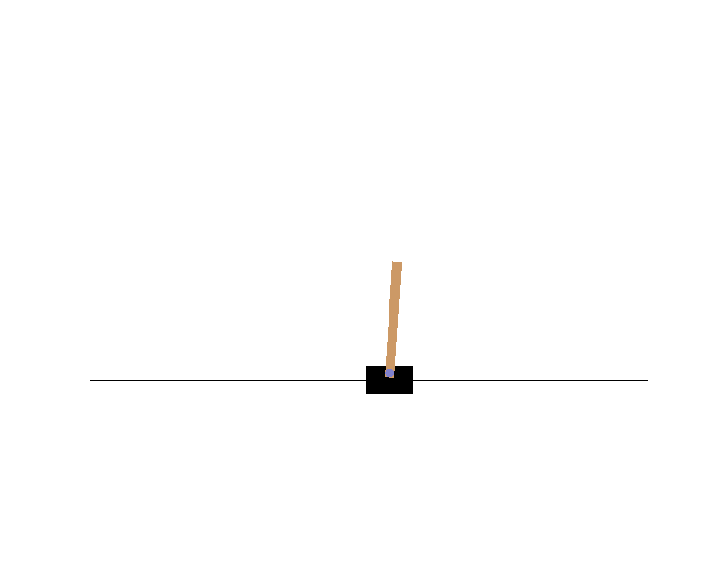
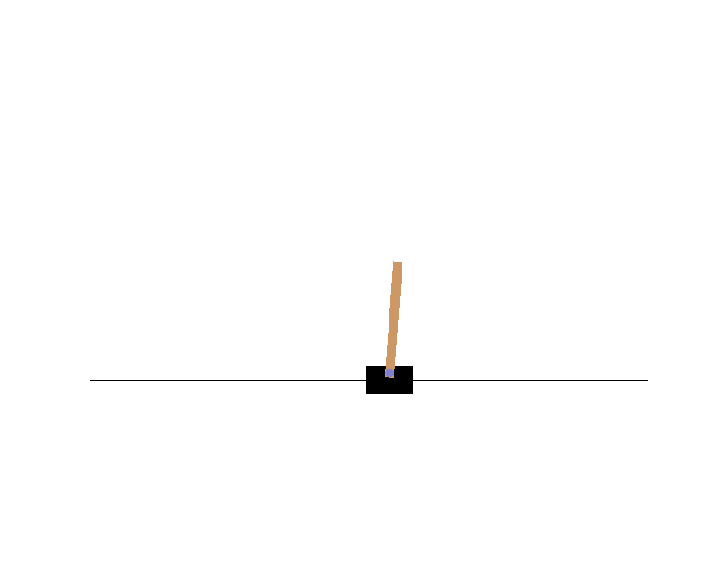
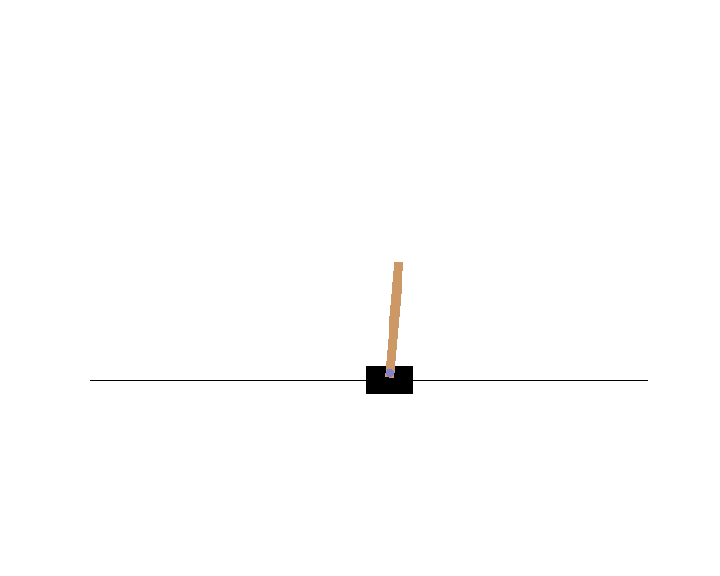
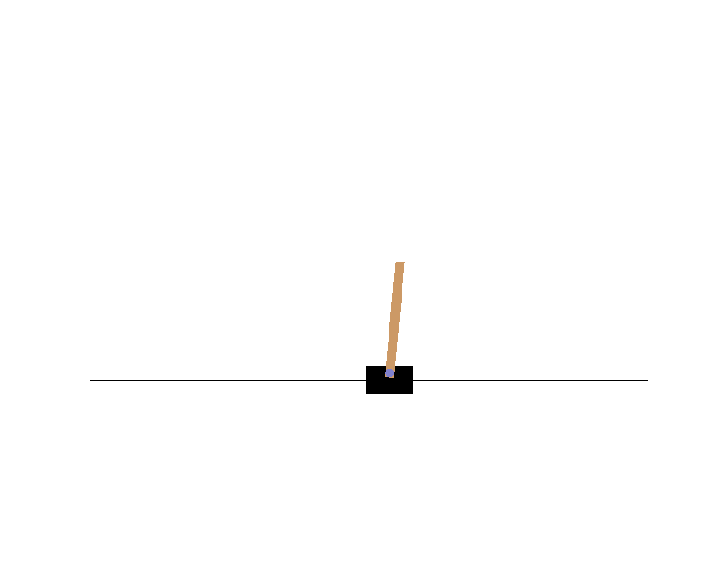
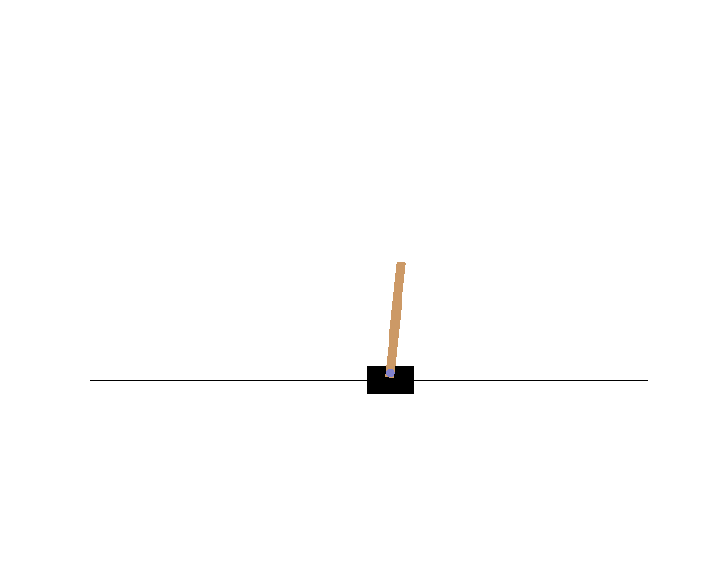
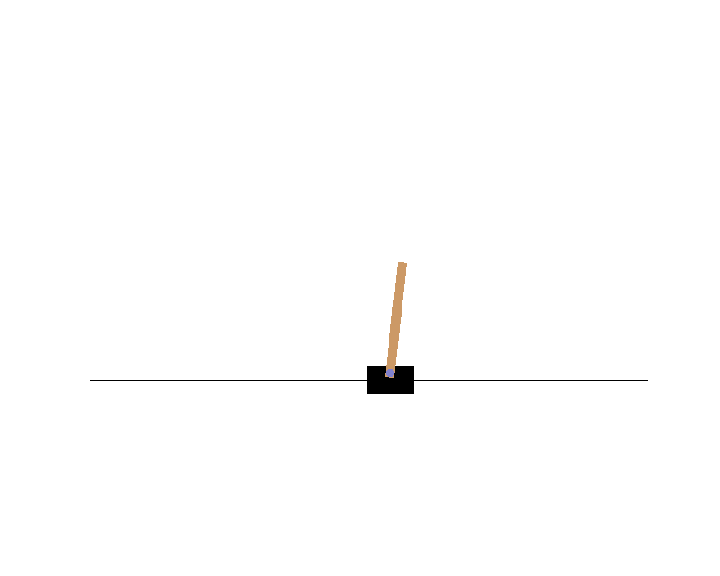
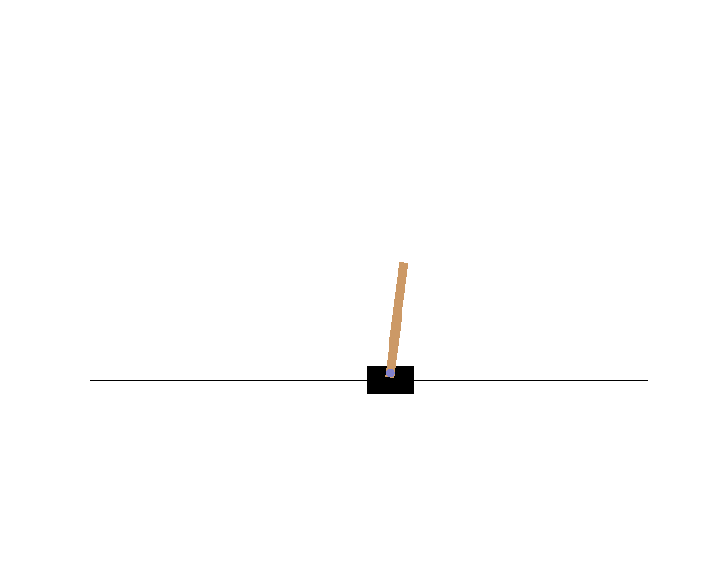
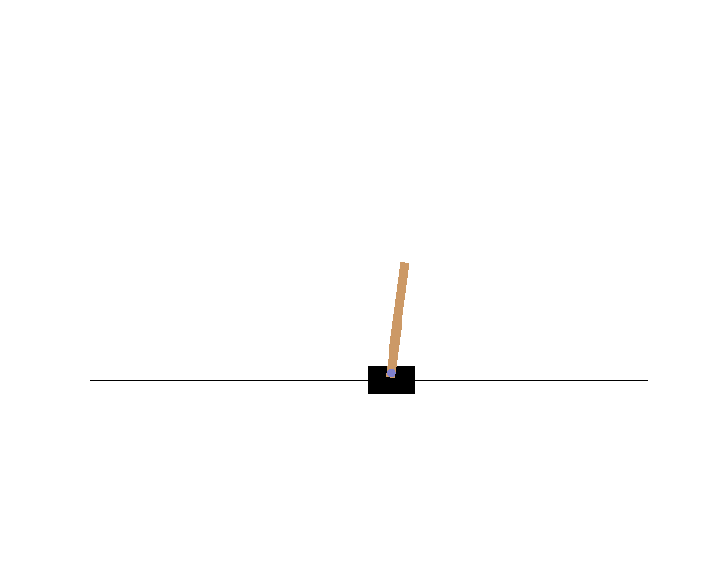
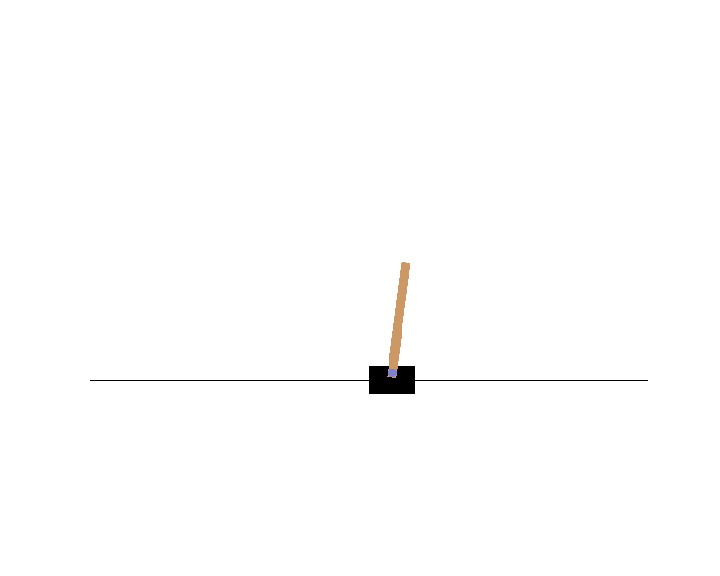
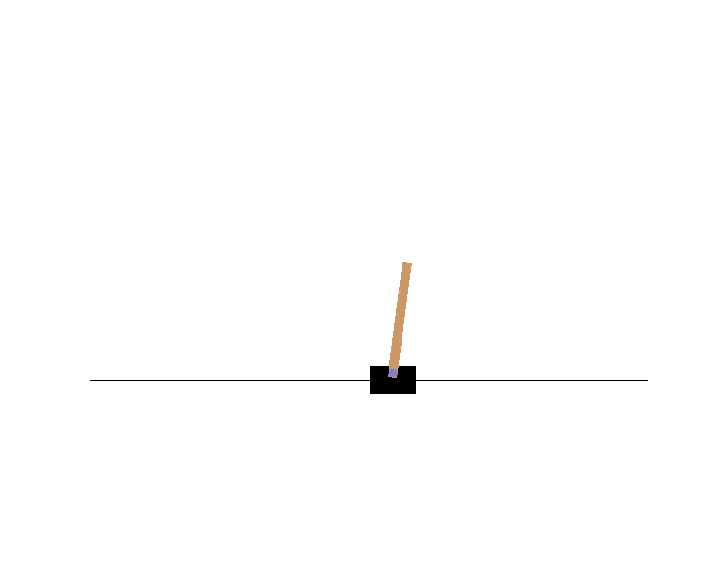
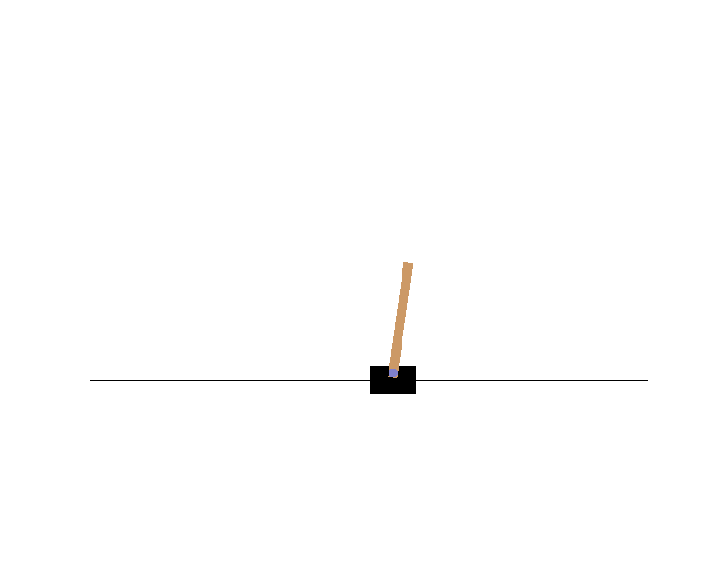
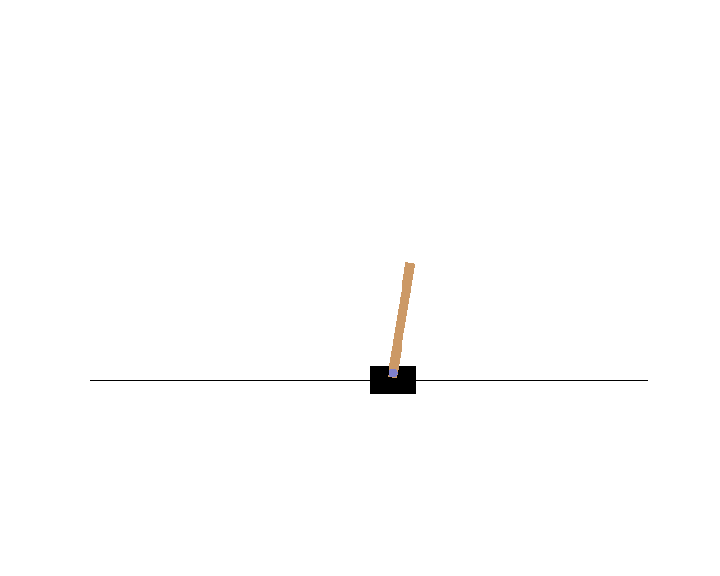
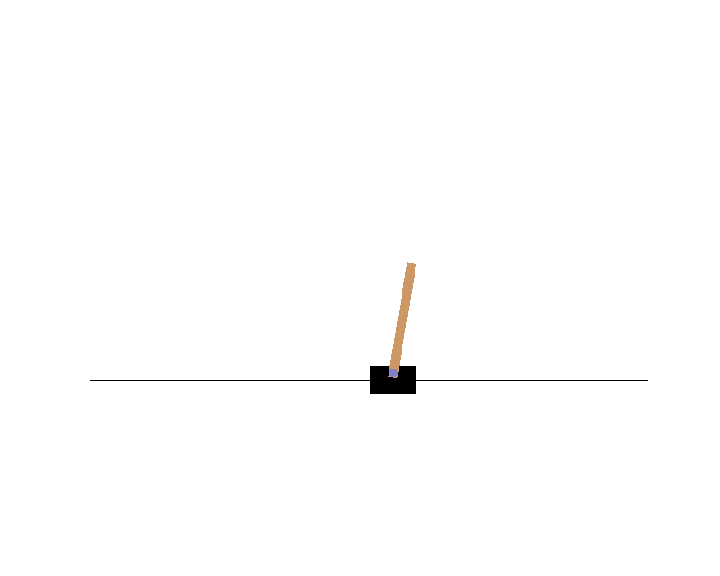
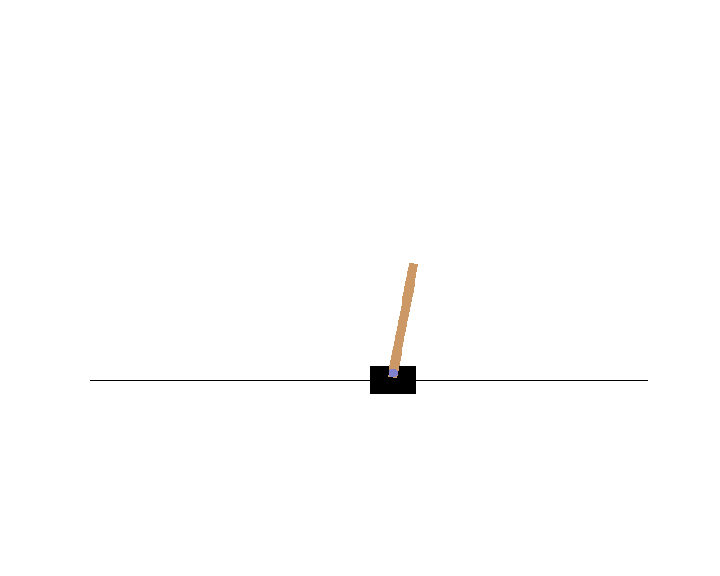
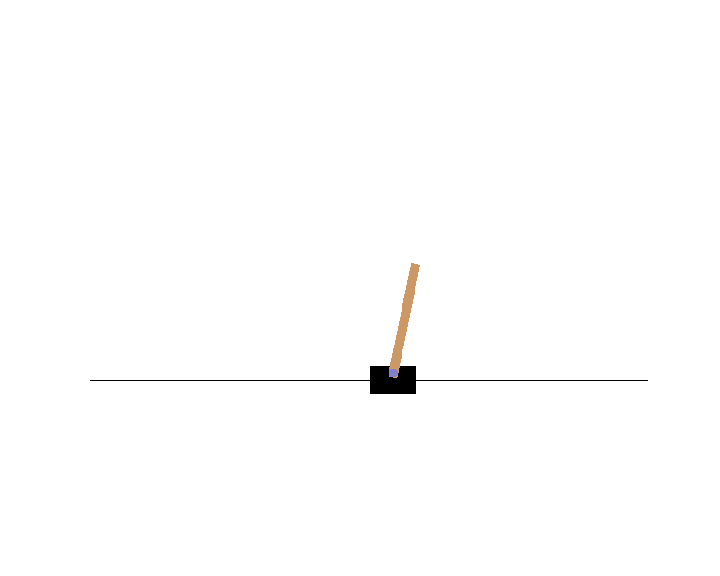
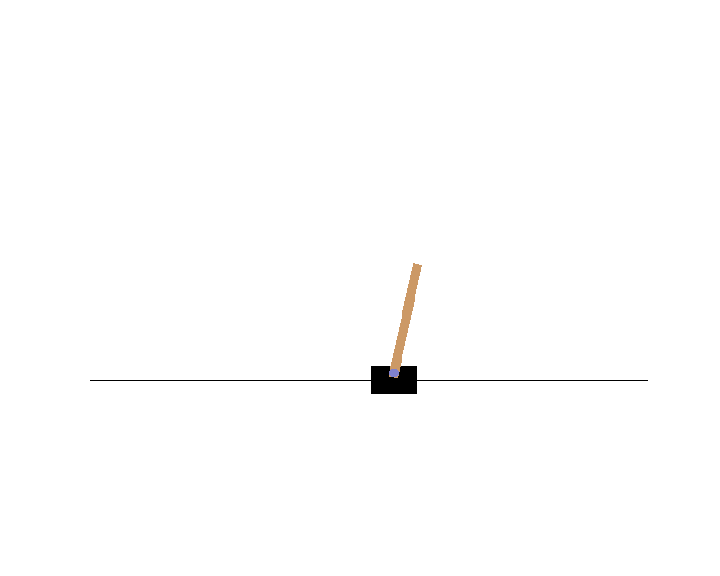

1999-th Episode



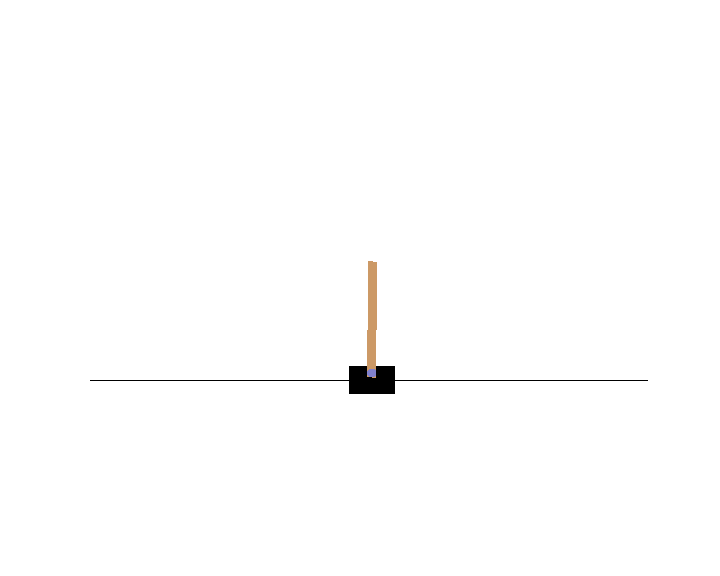
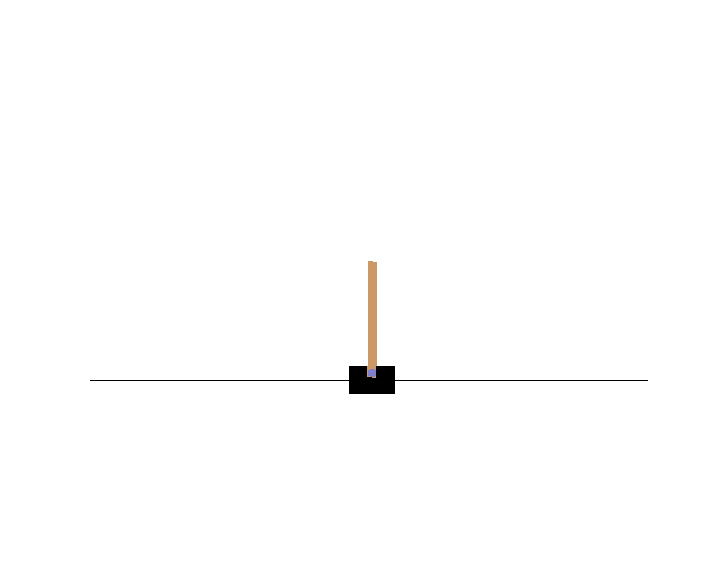
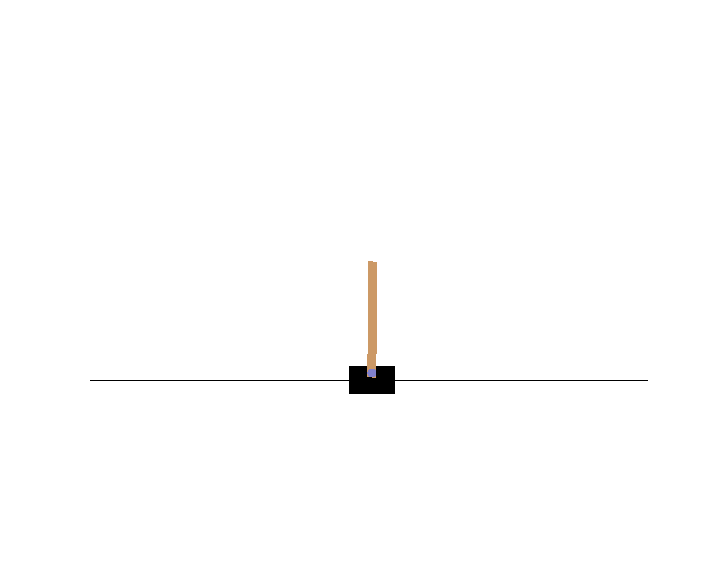
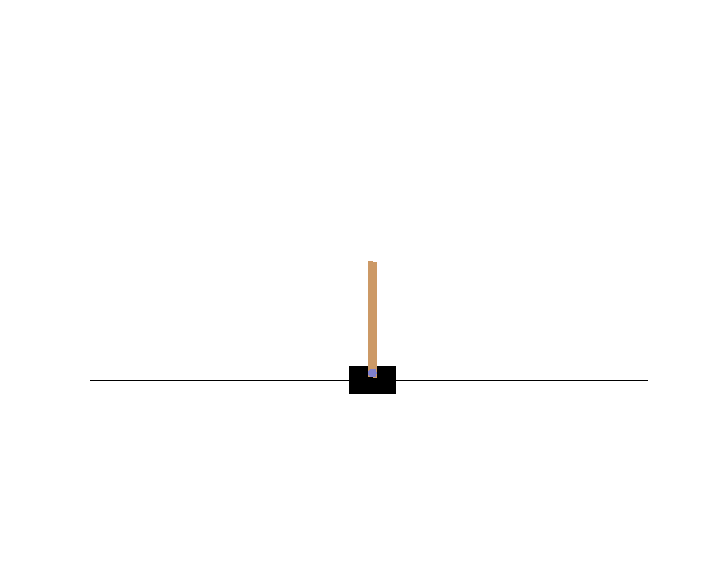
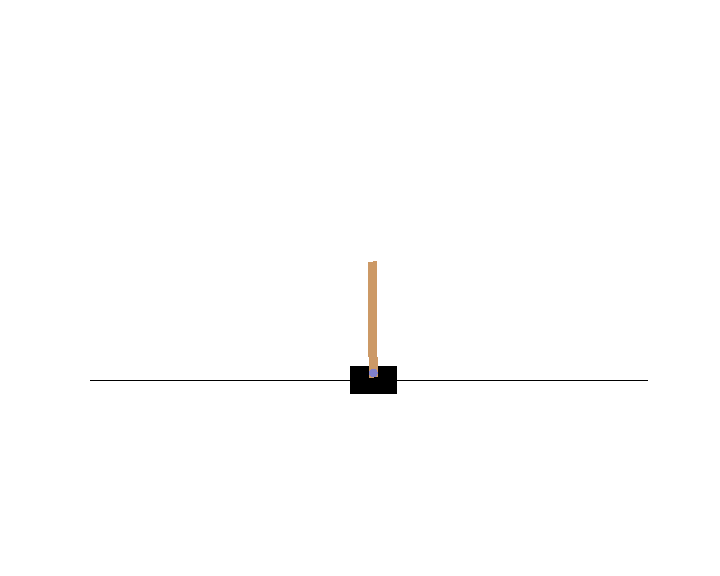
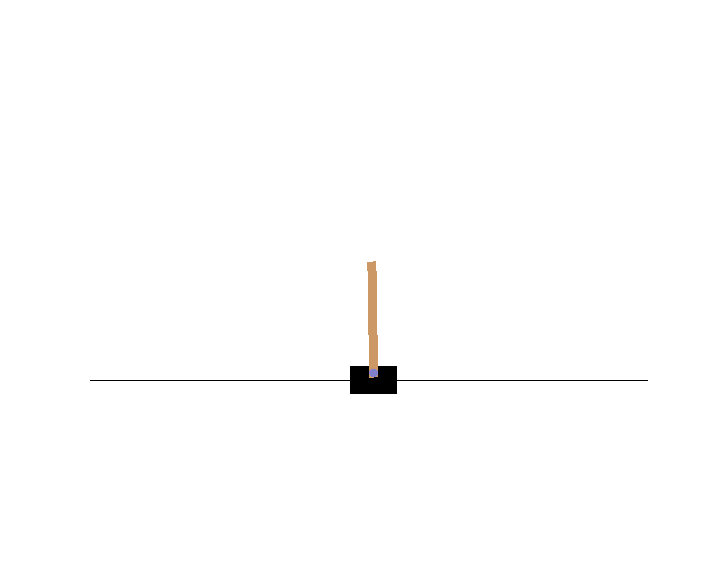
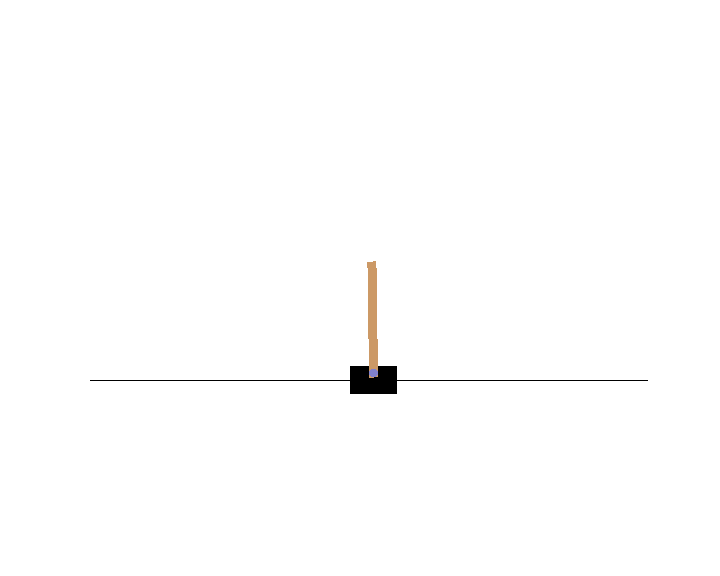
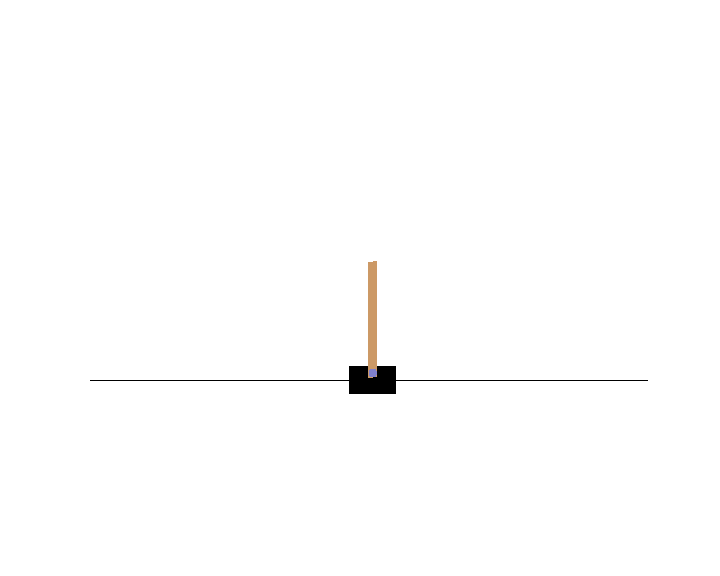
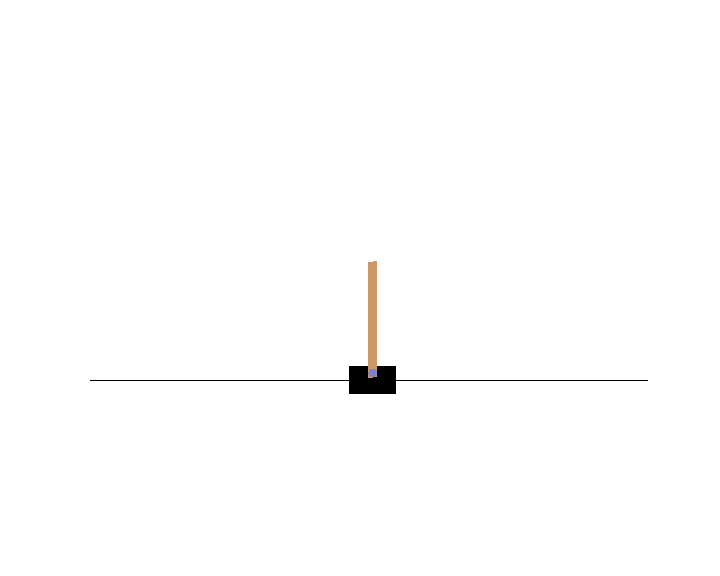
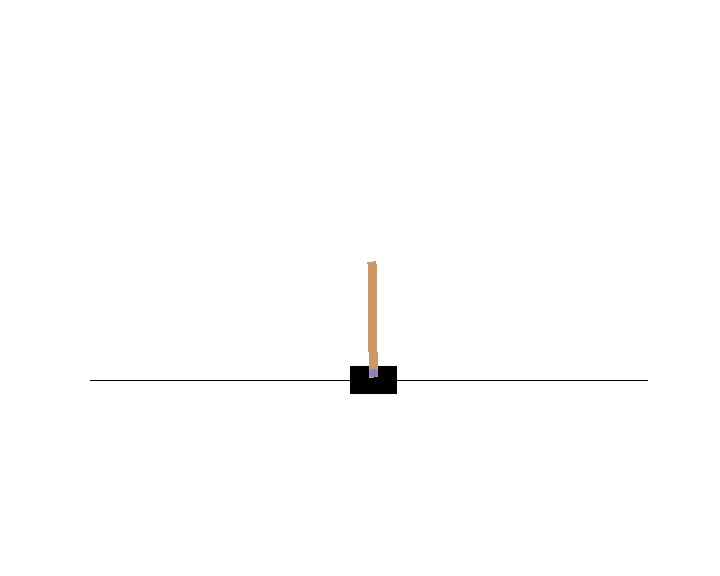
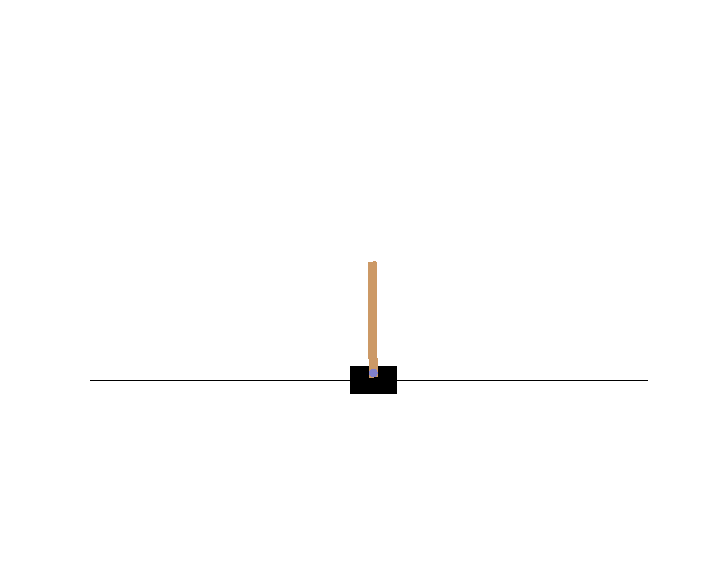
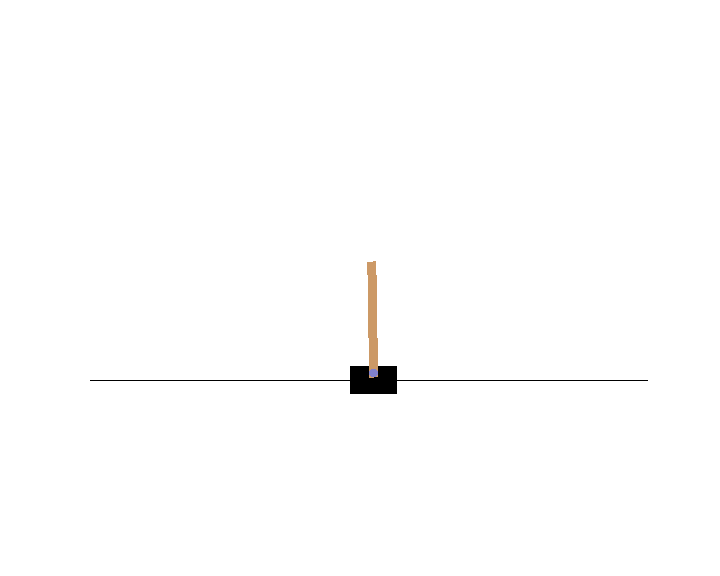
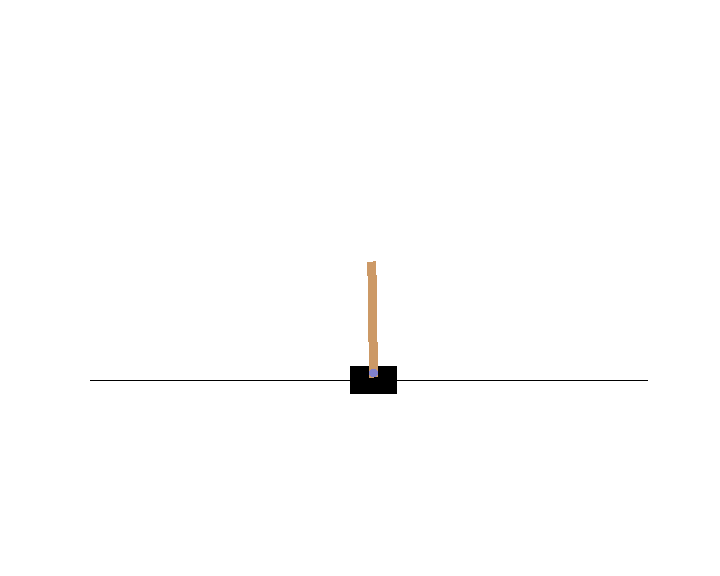
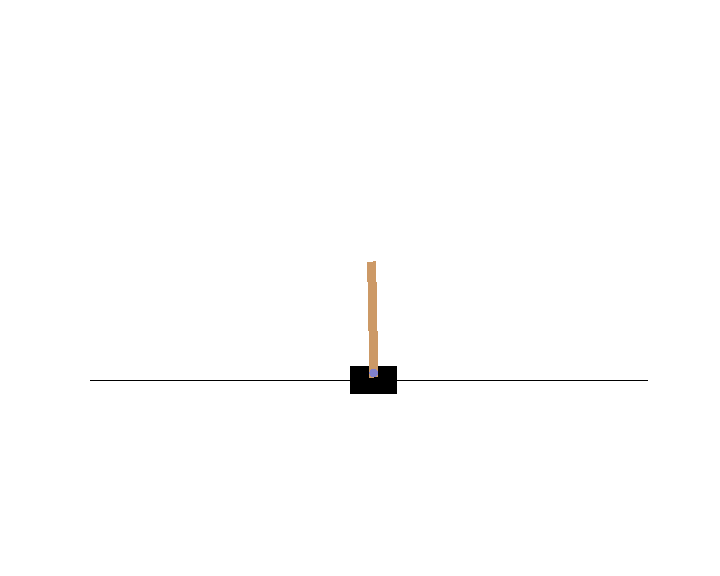
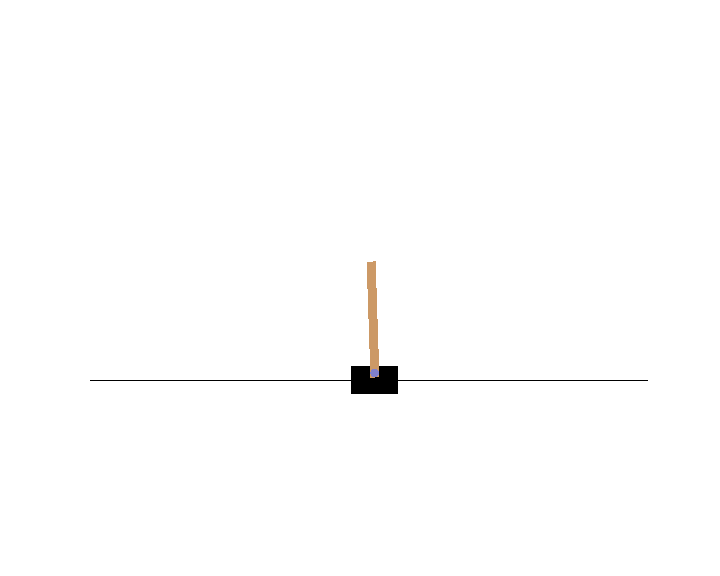
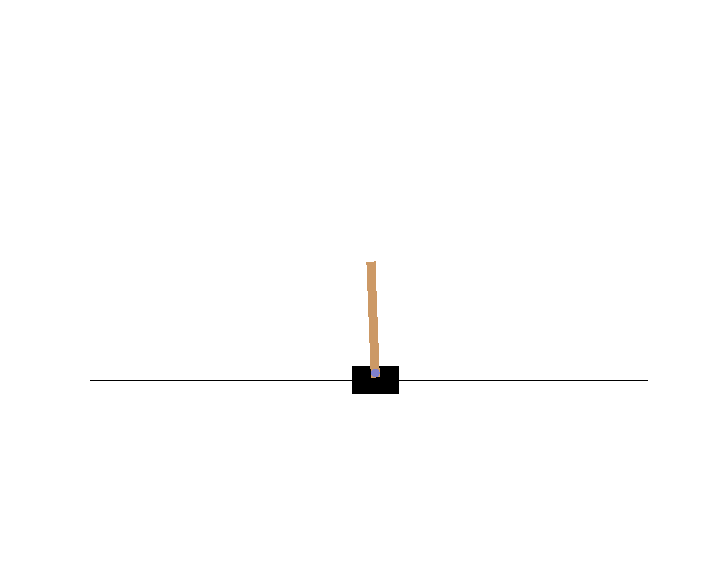
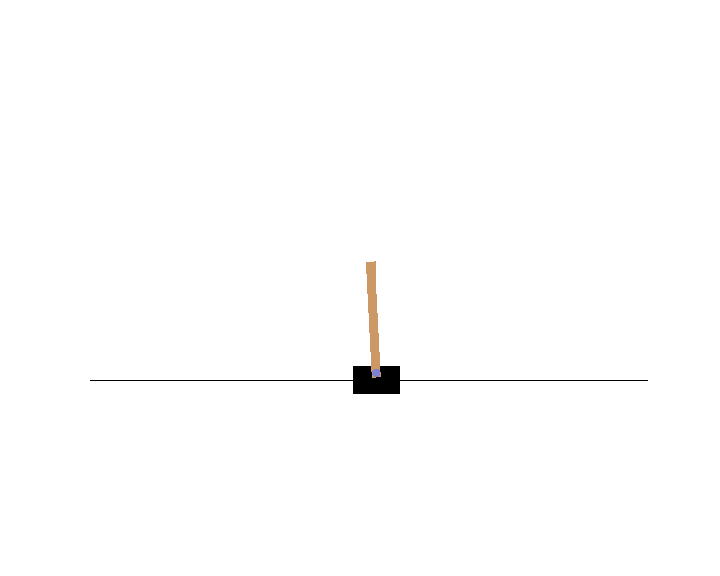
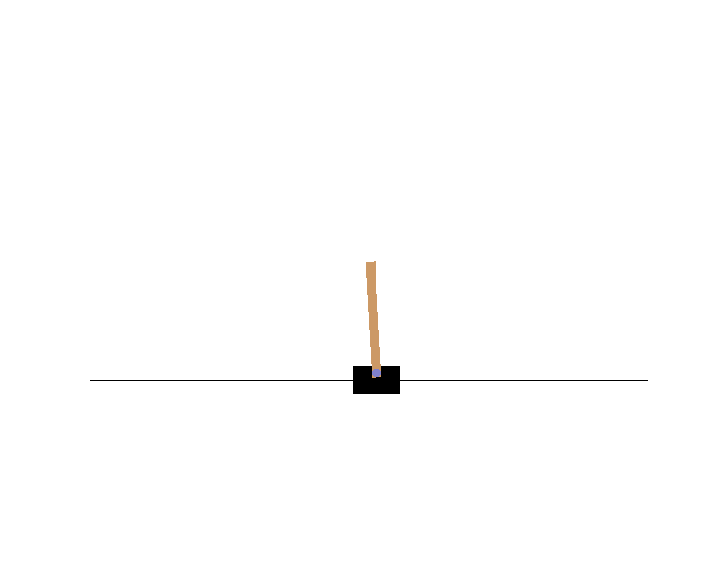
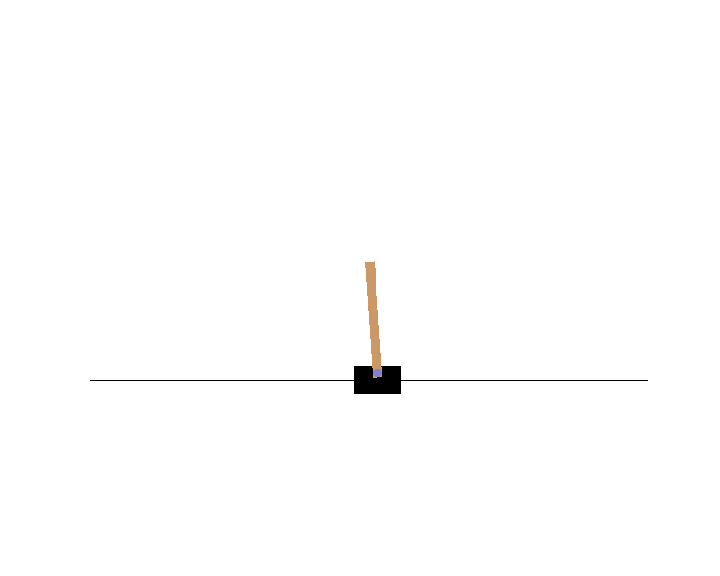
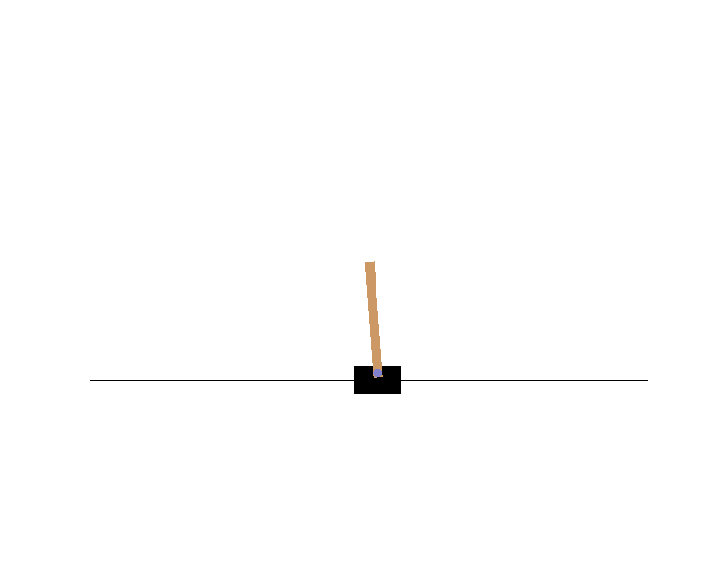
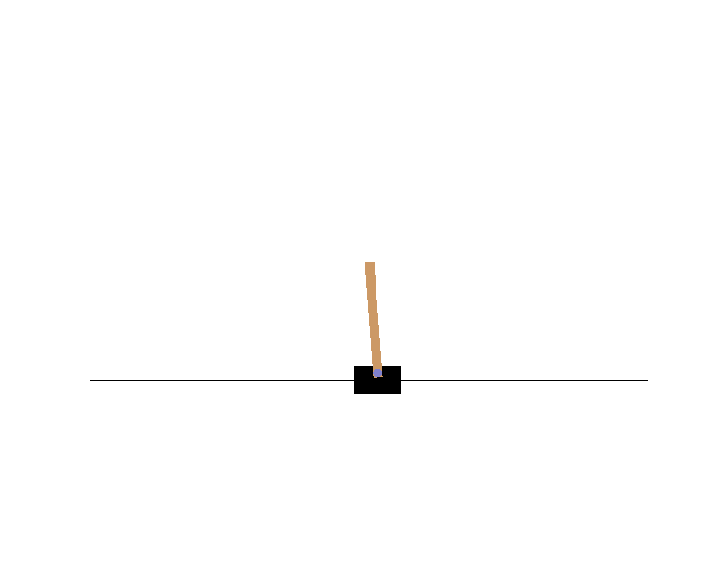
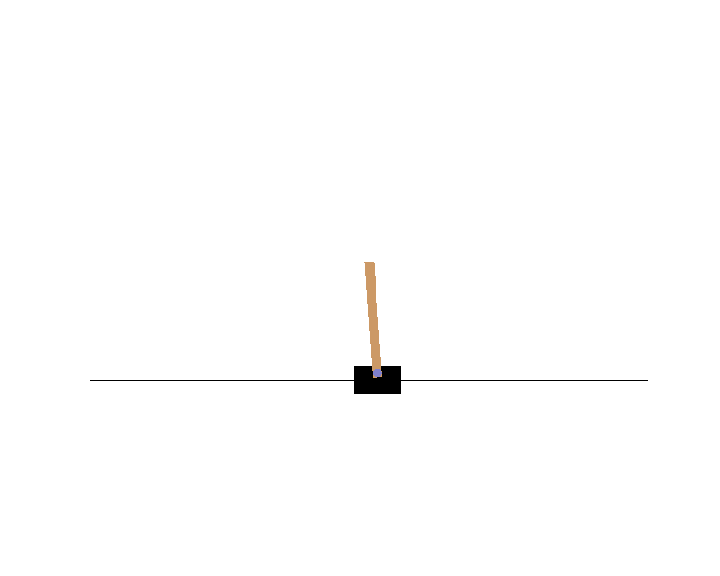
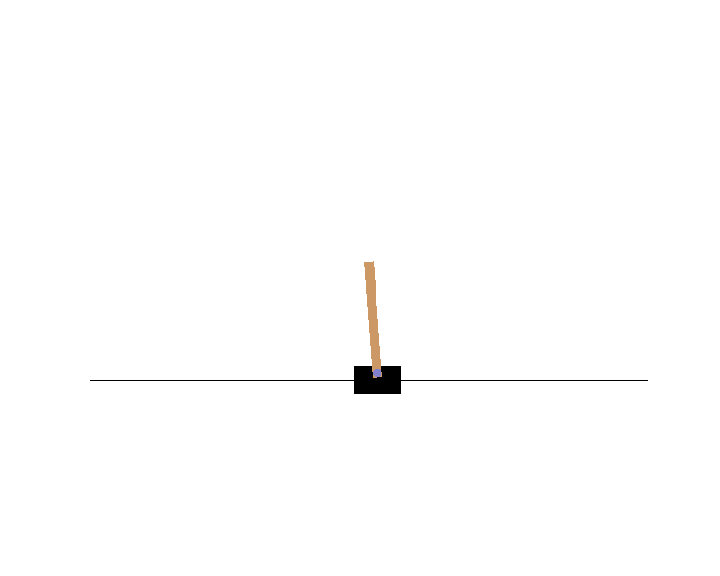
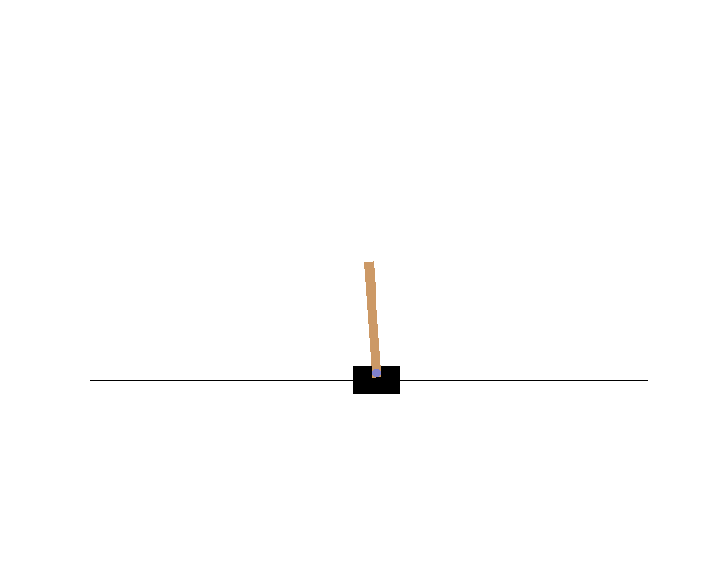
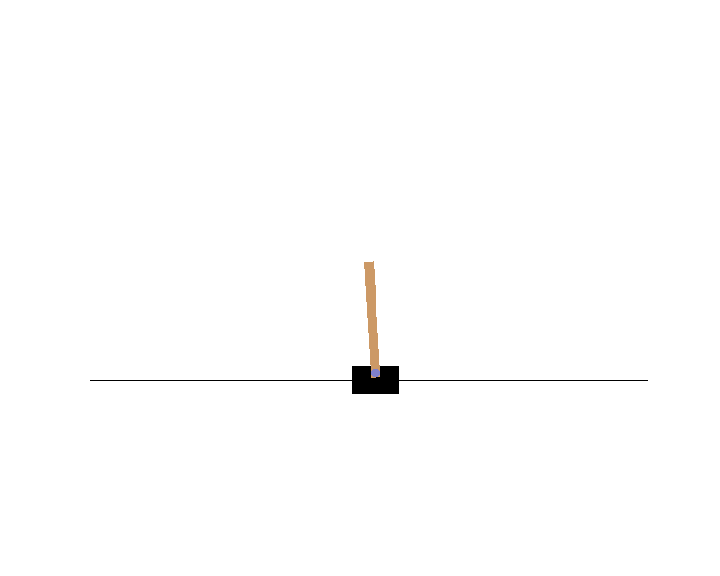
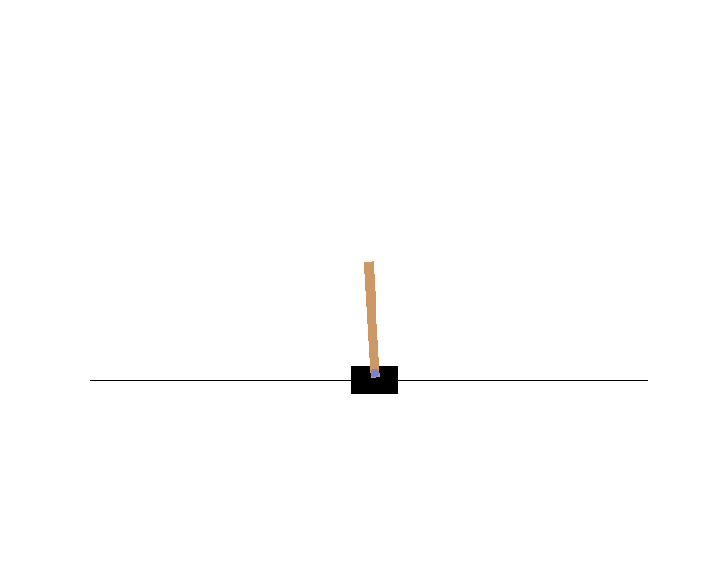
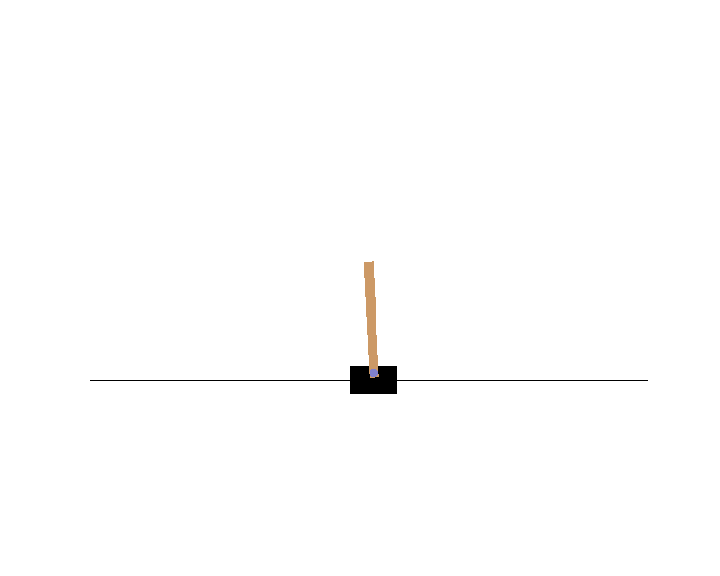
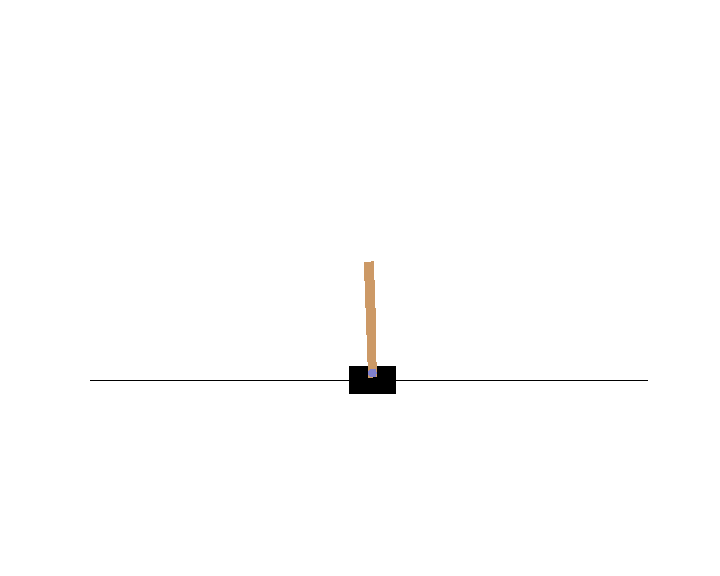
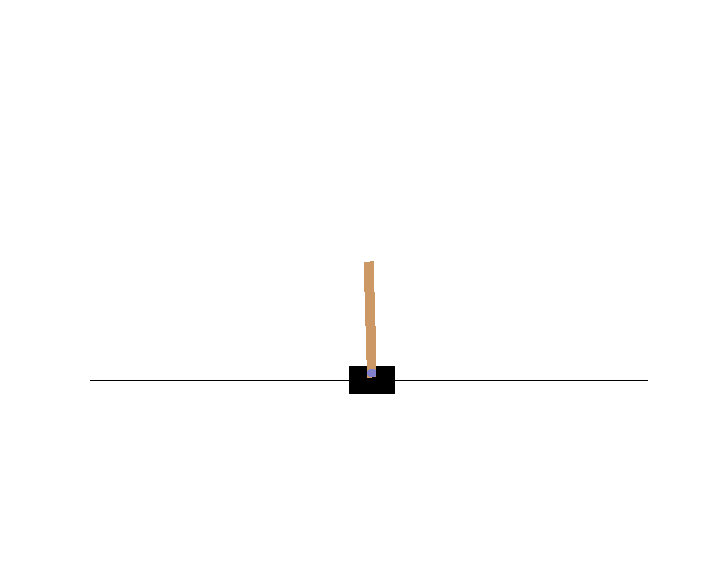
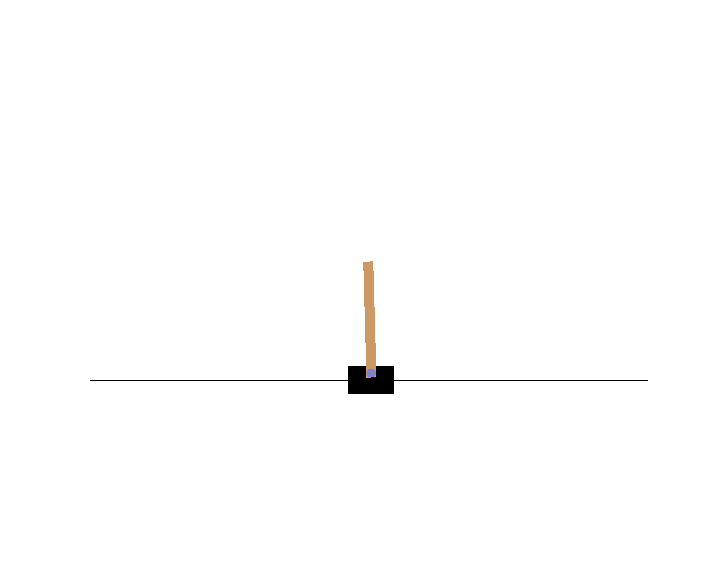
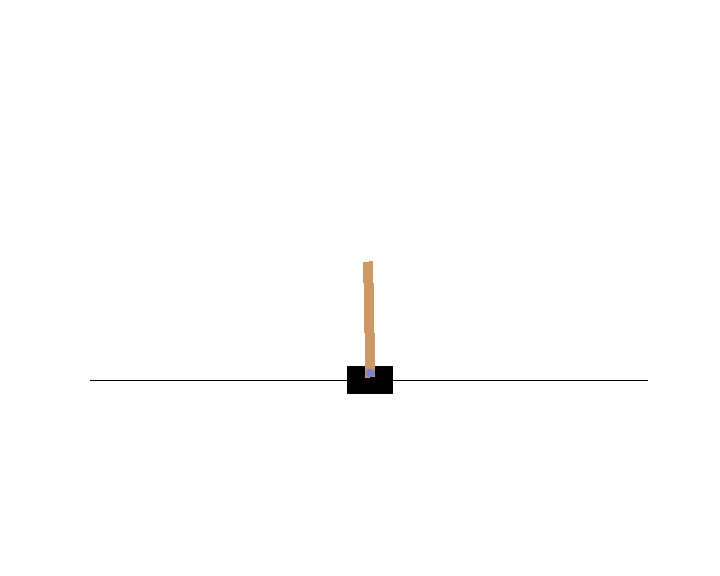
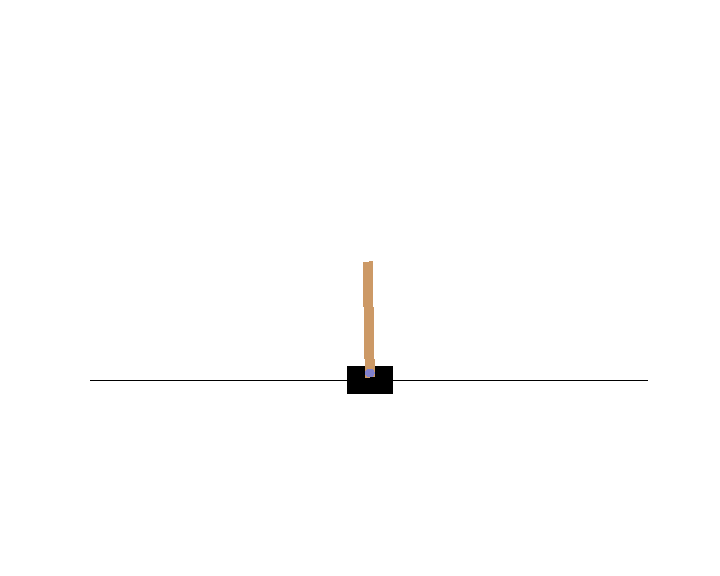
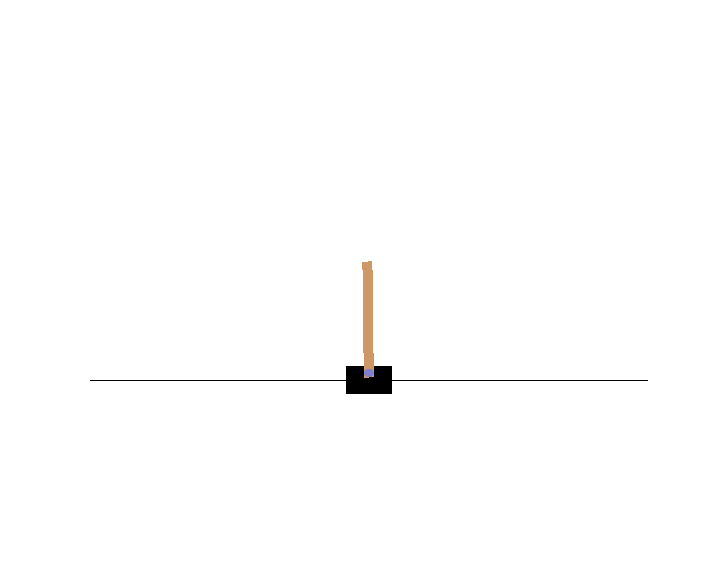
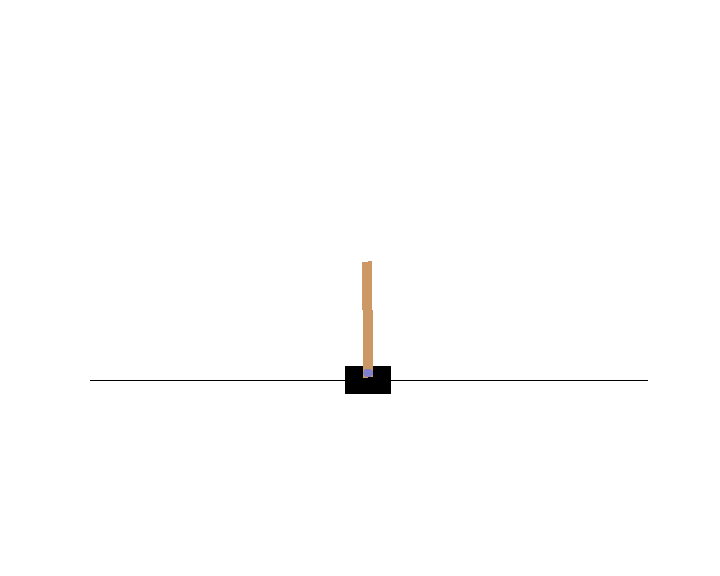
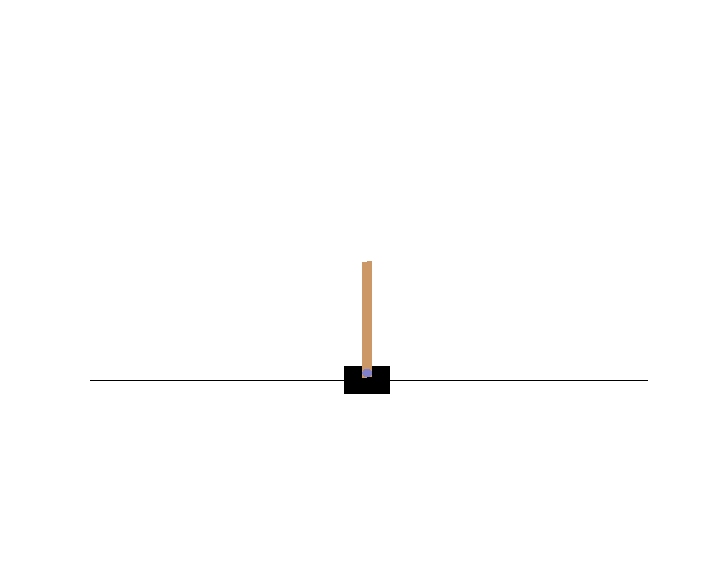
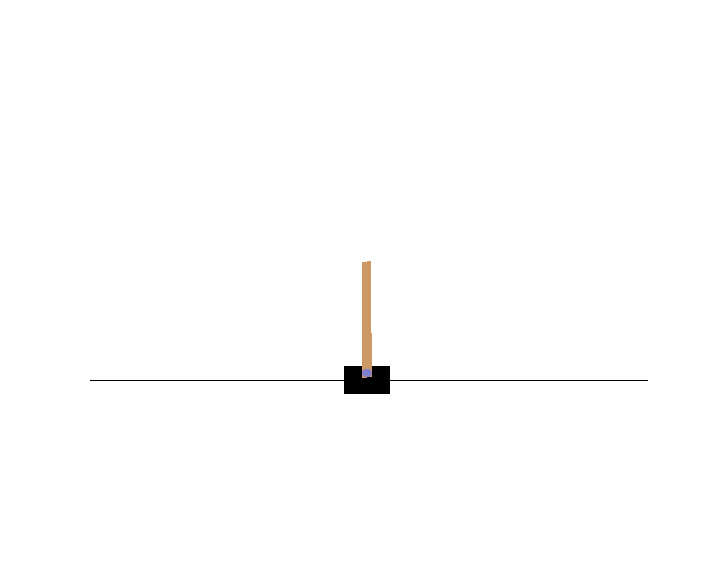
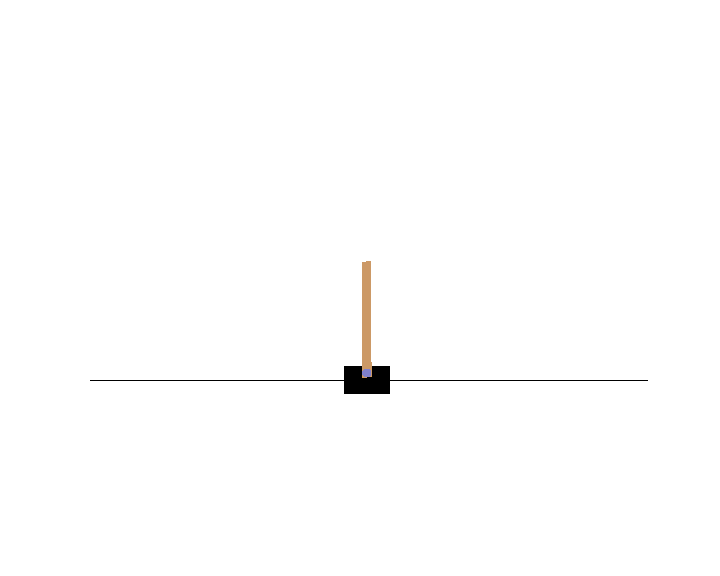
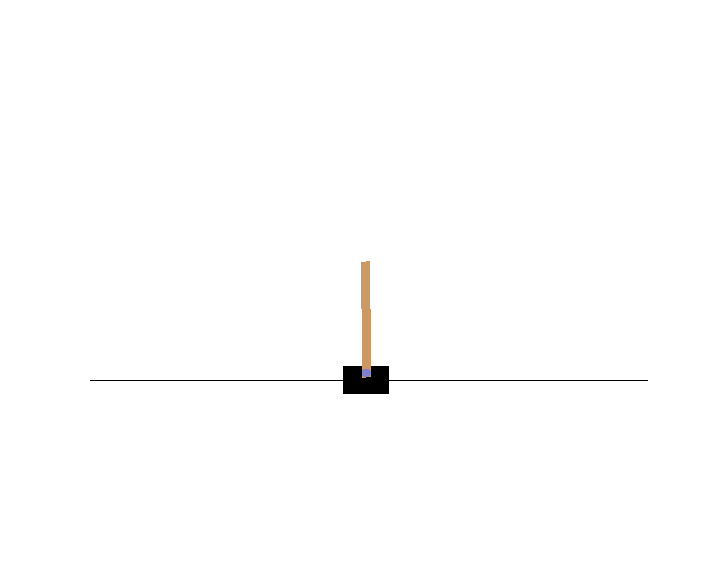
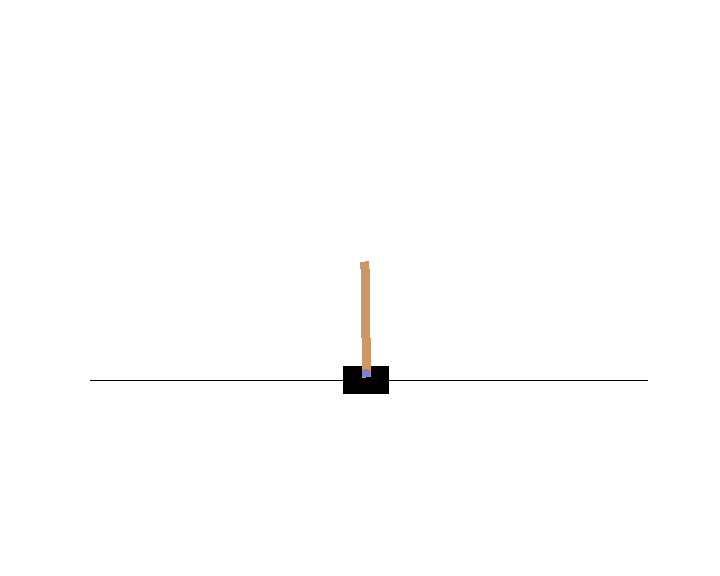
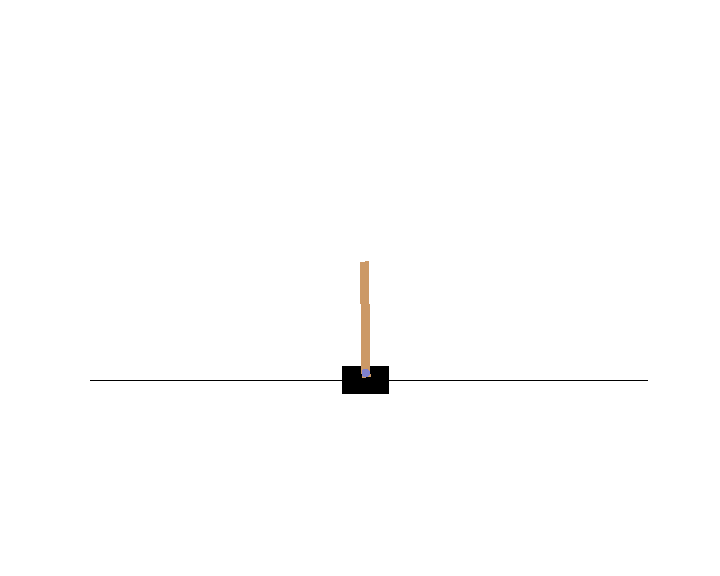
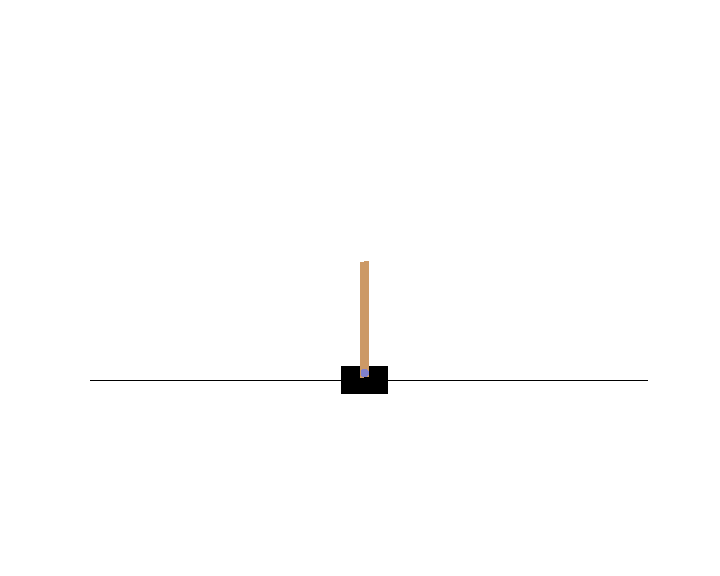
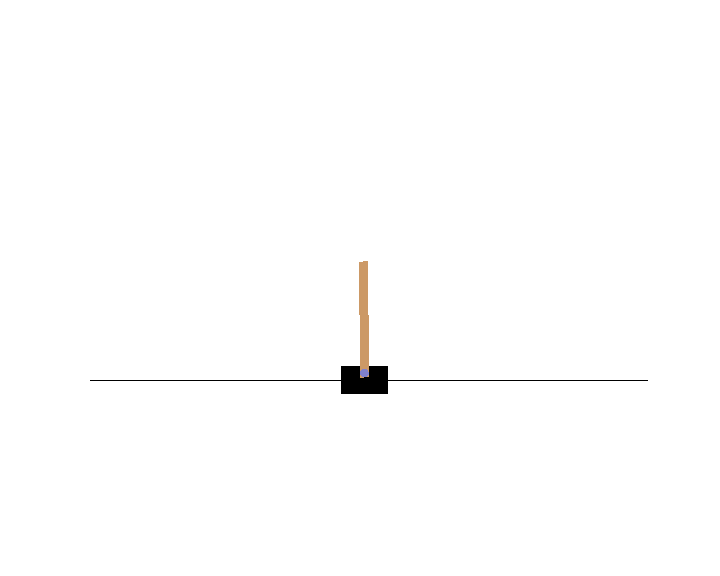
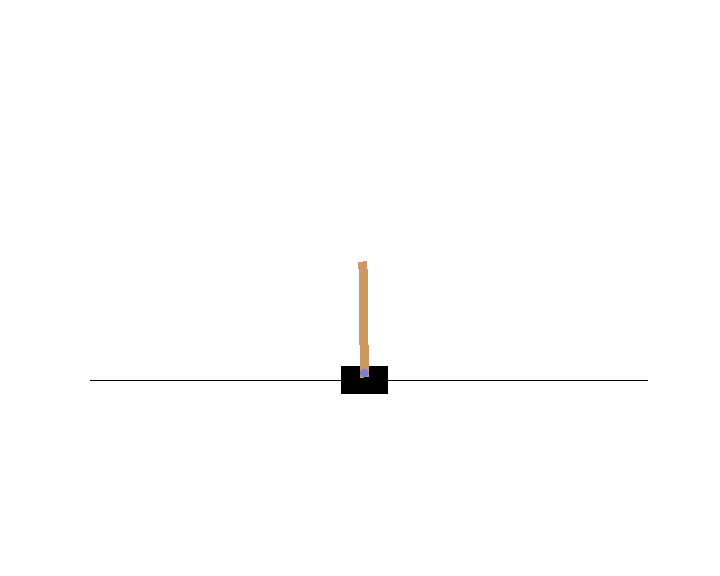
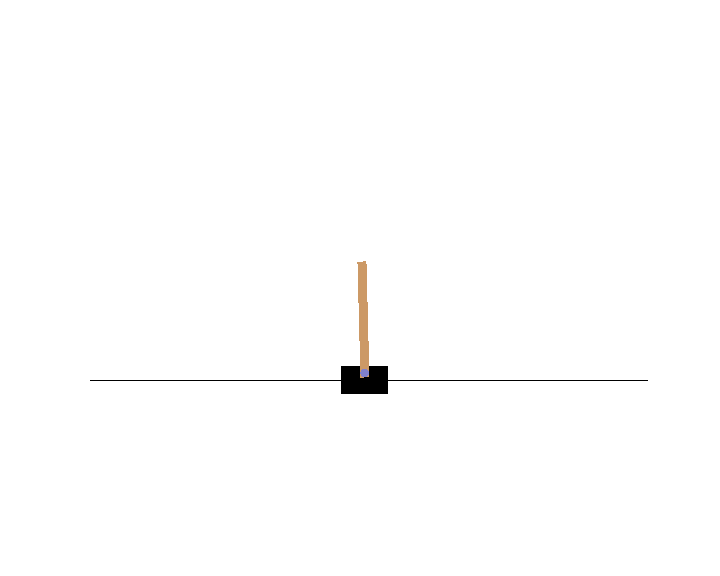
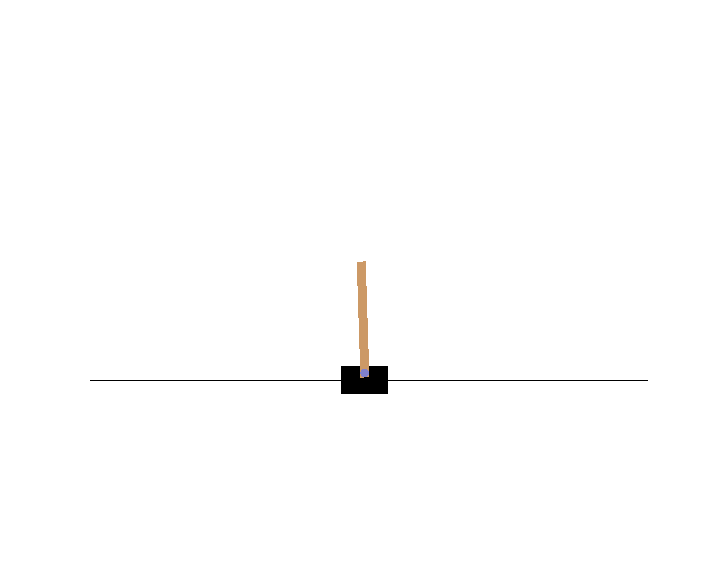
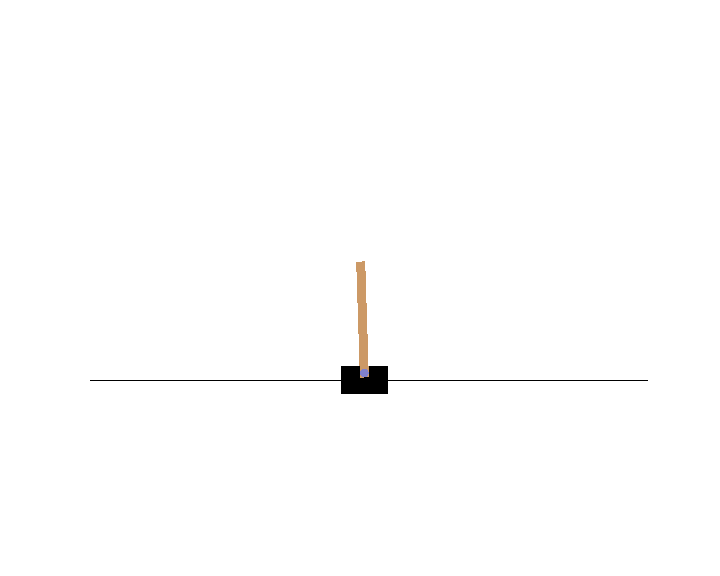
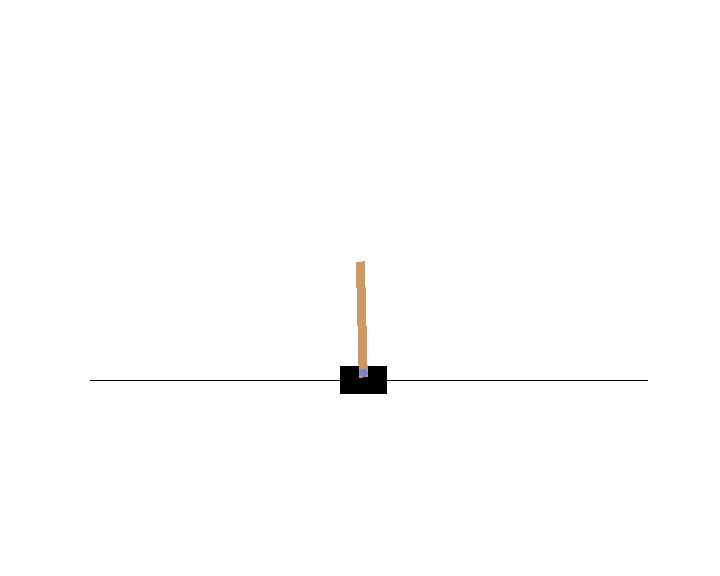
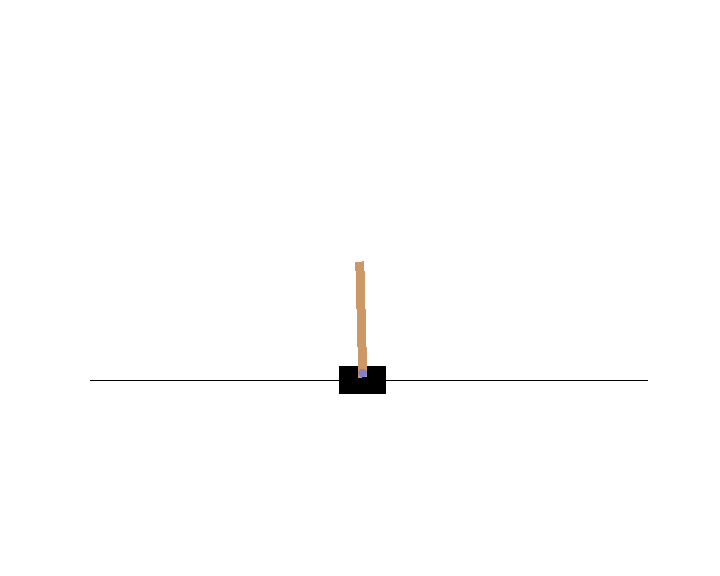
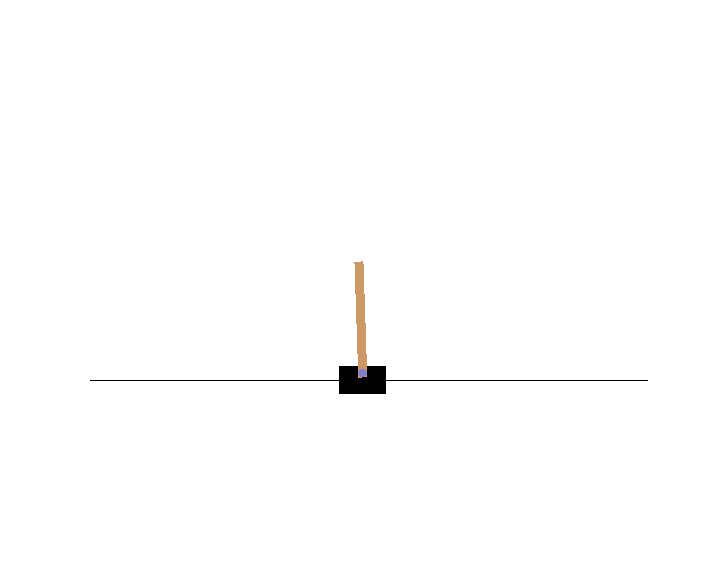
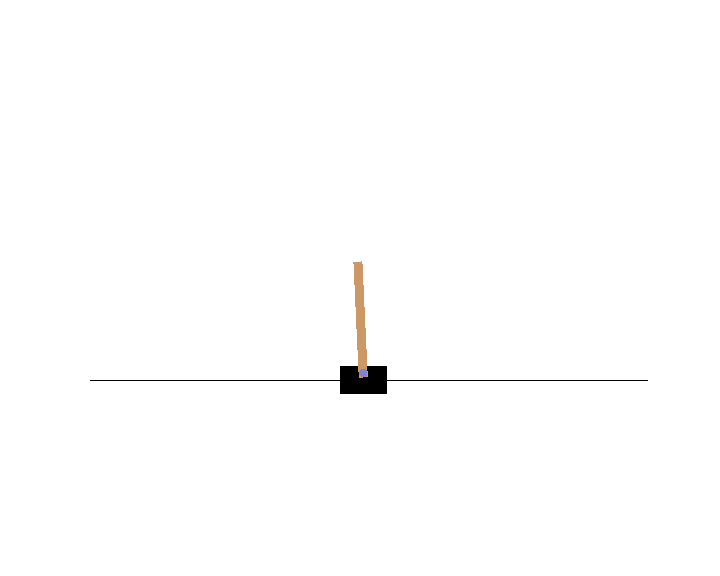
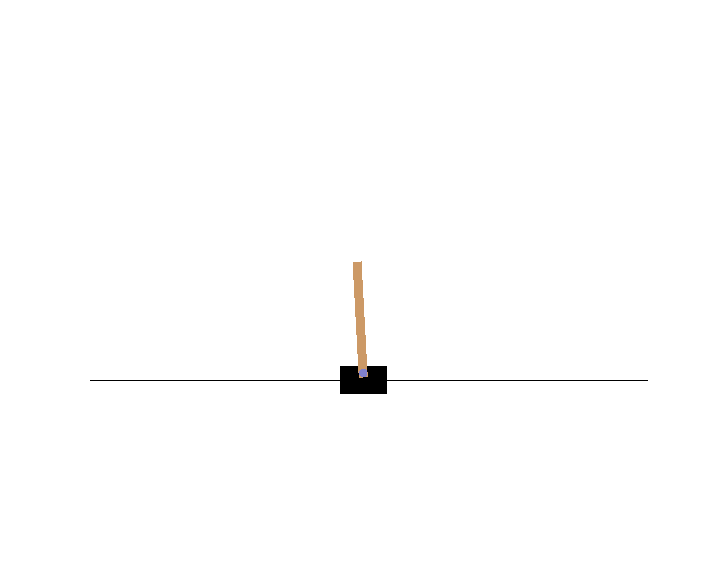
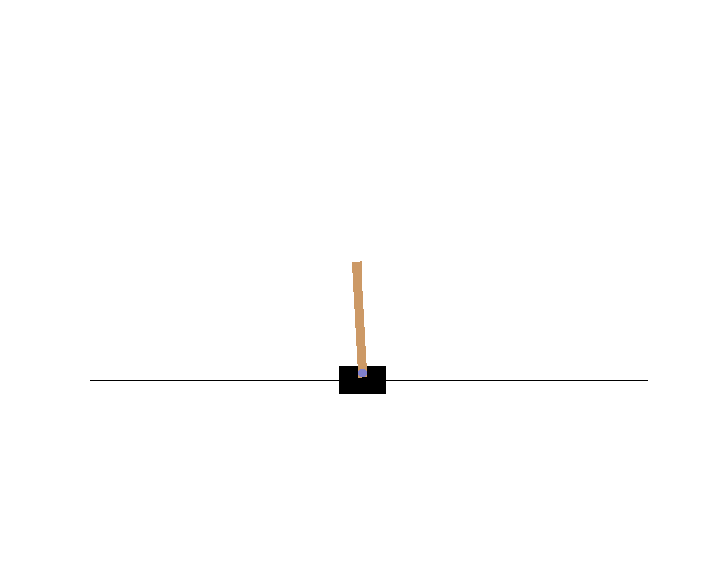
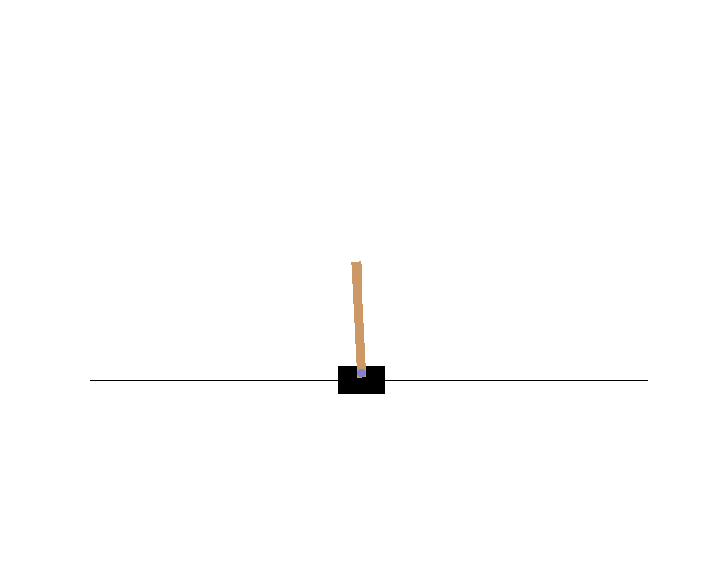
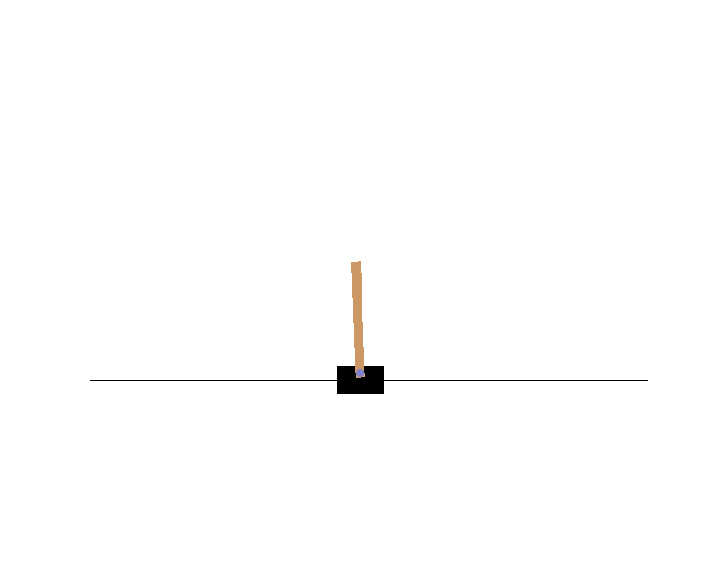
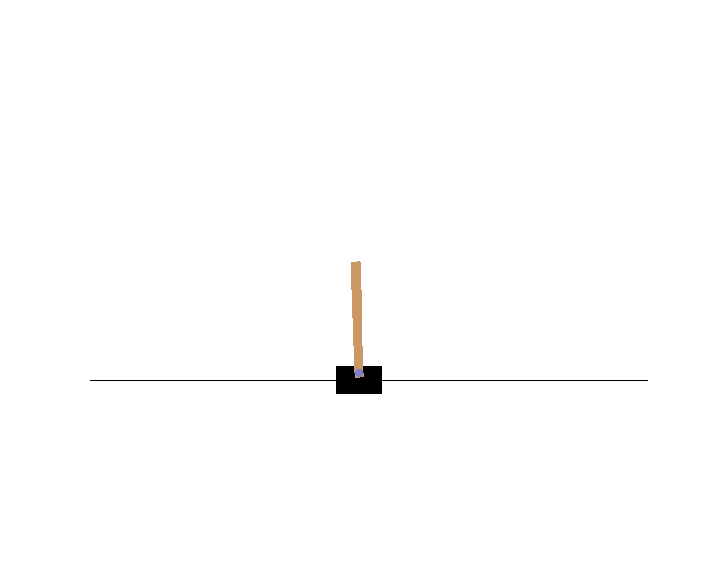
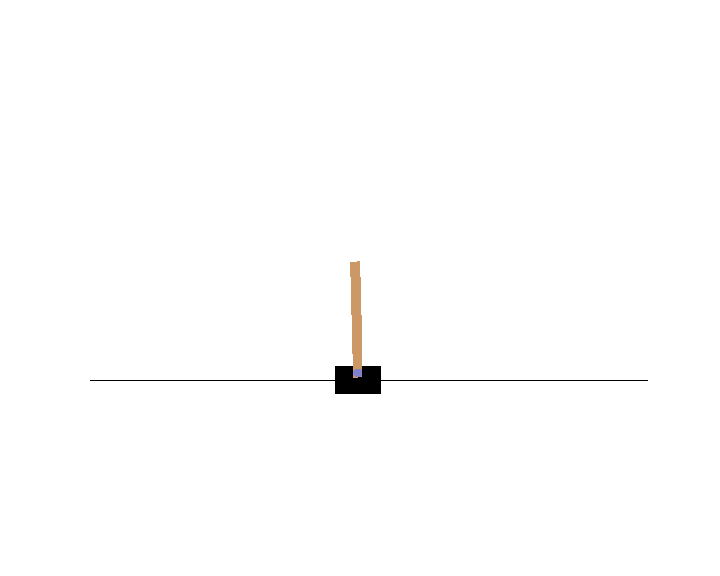
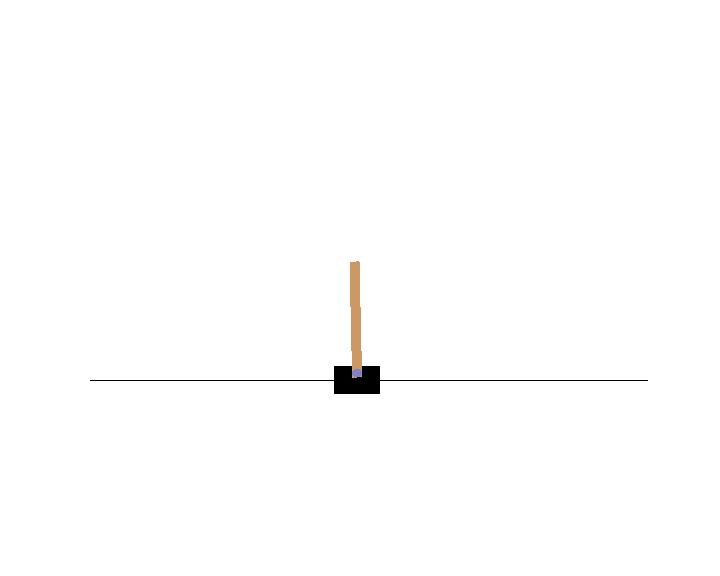
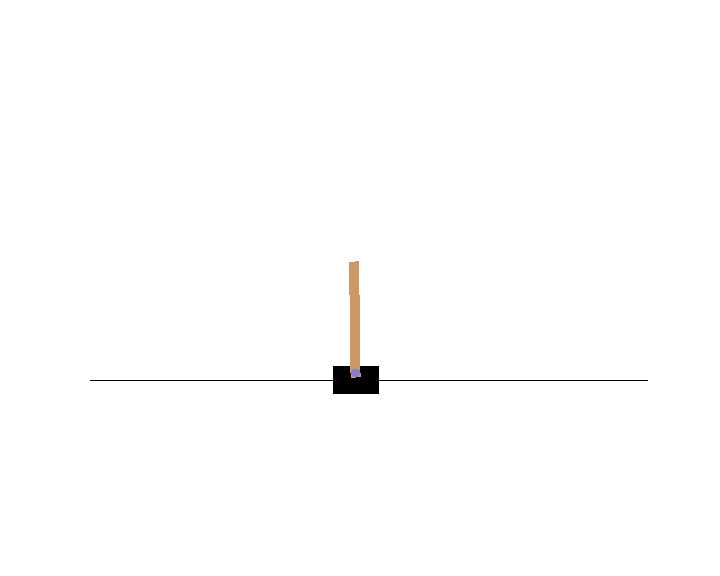
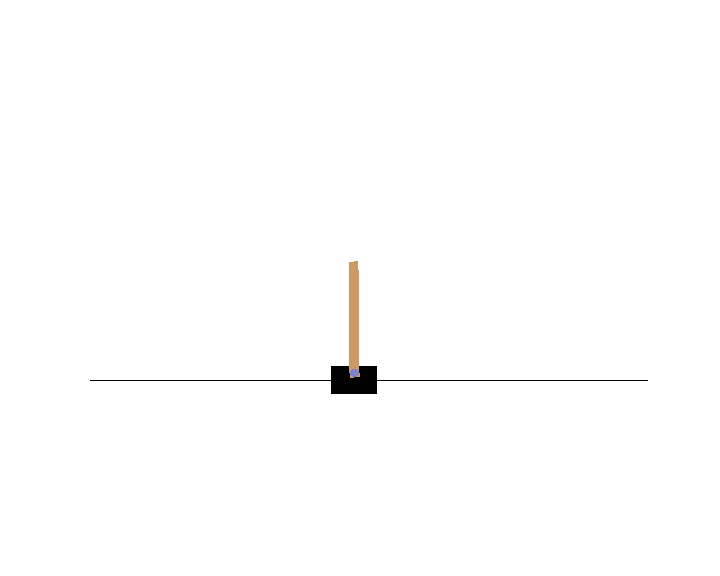
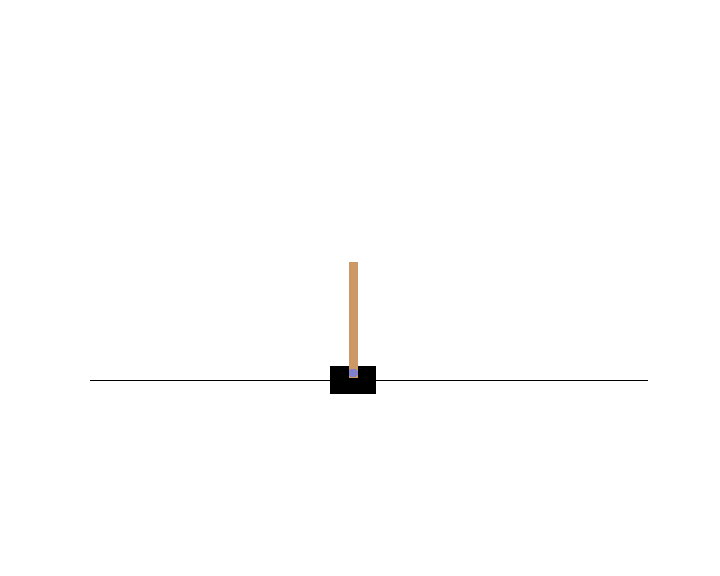
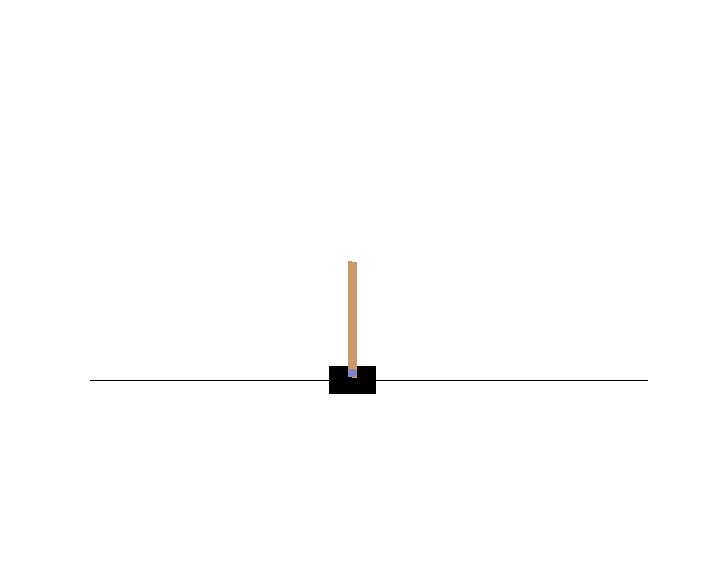
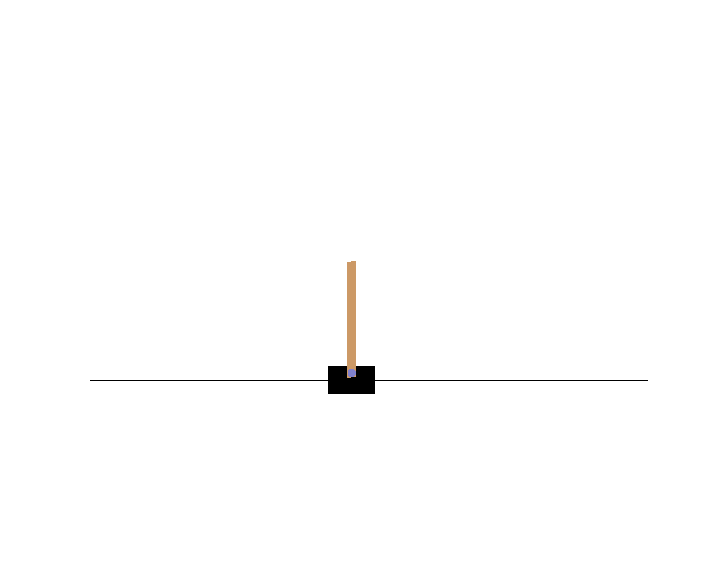
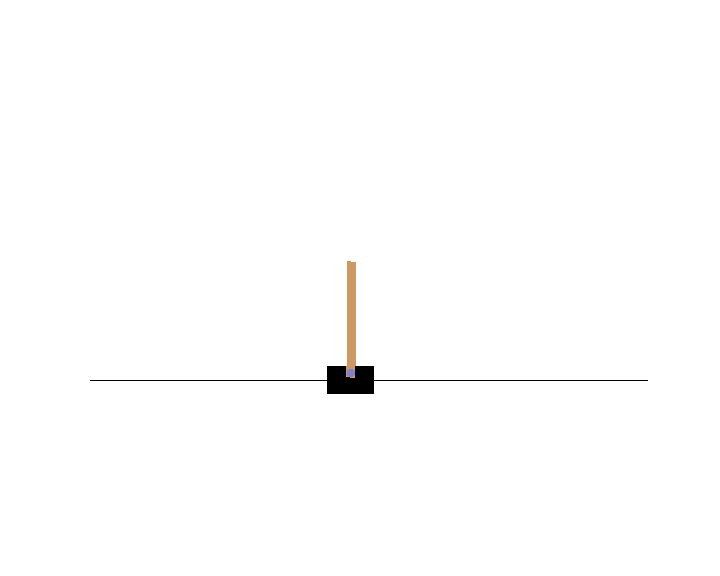
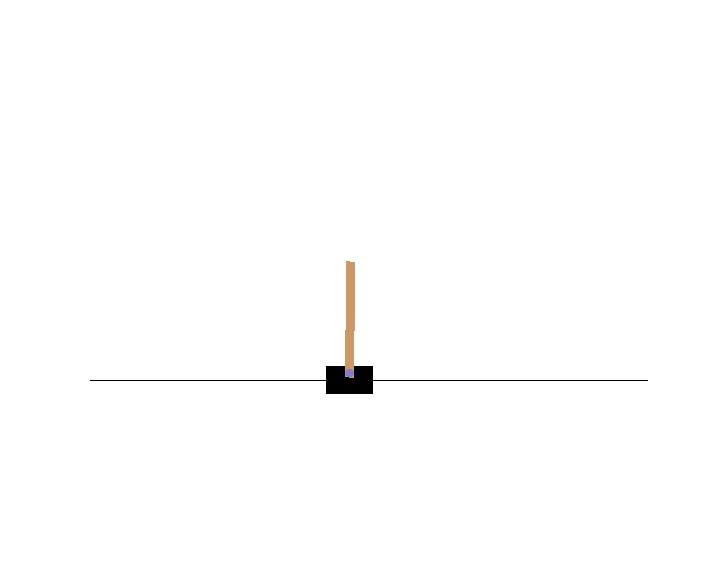
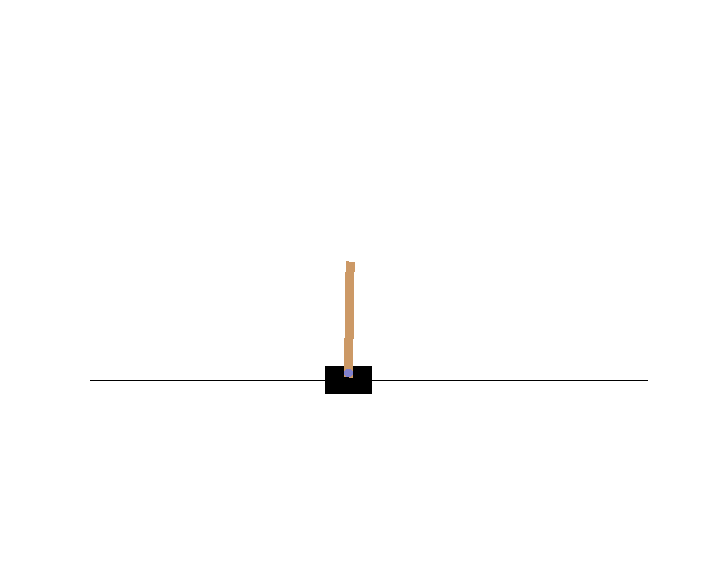
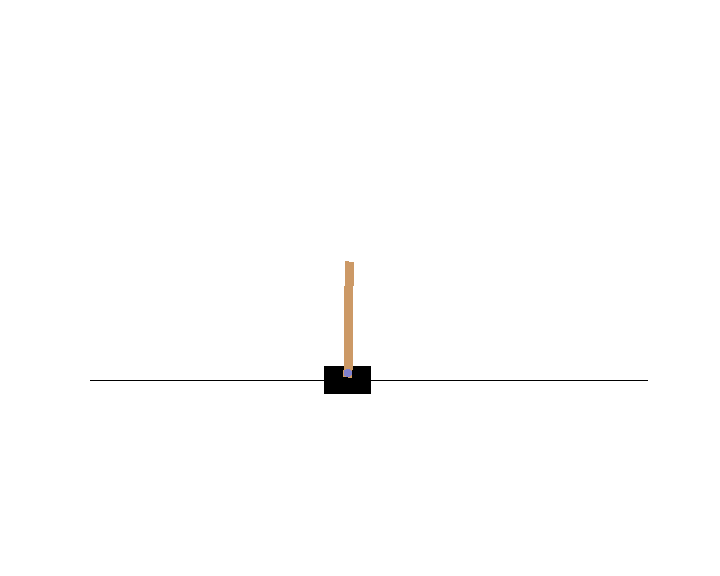
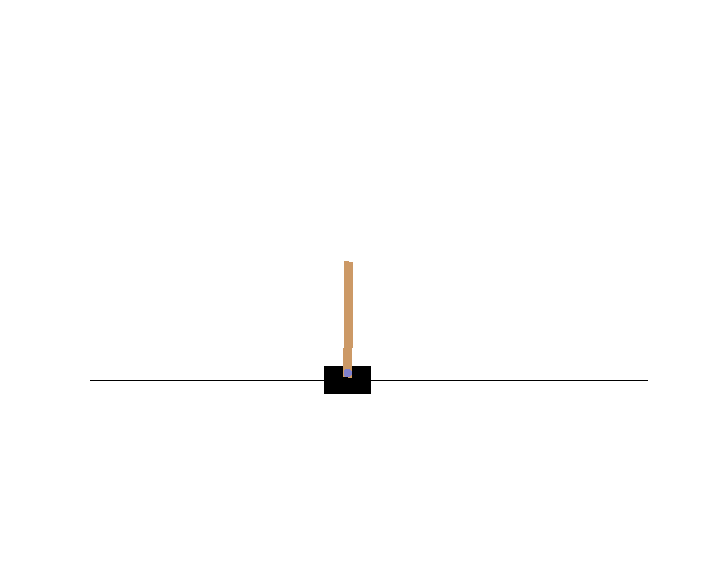
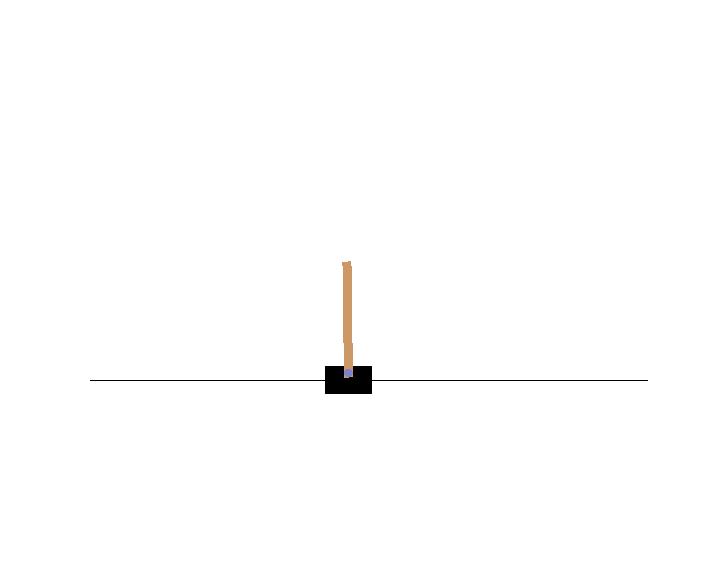
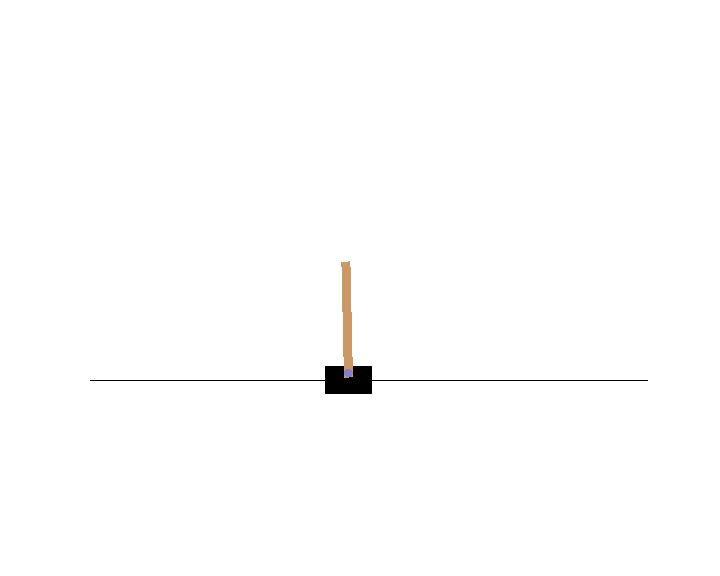
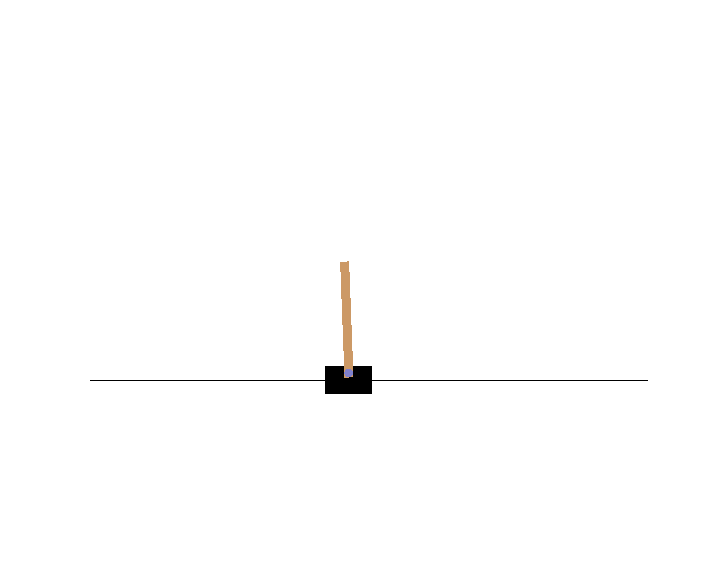
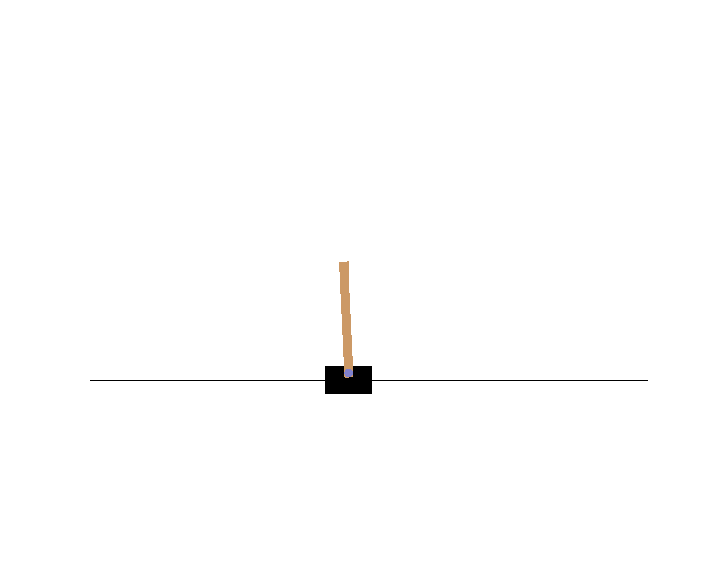
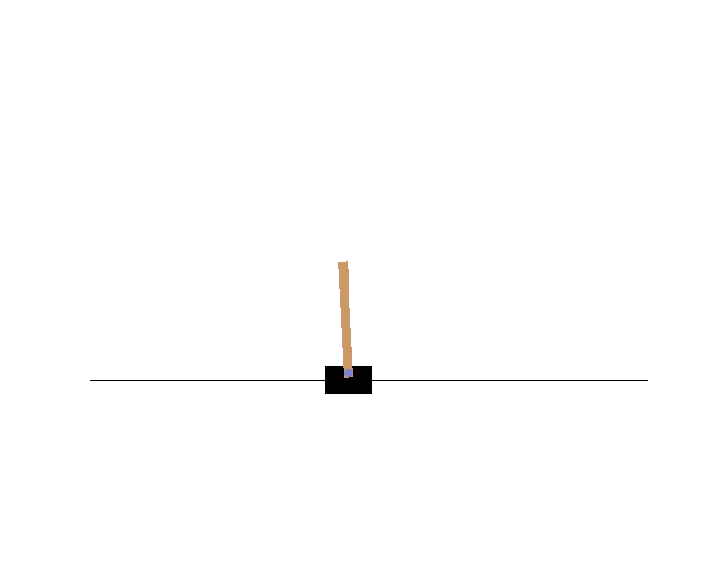
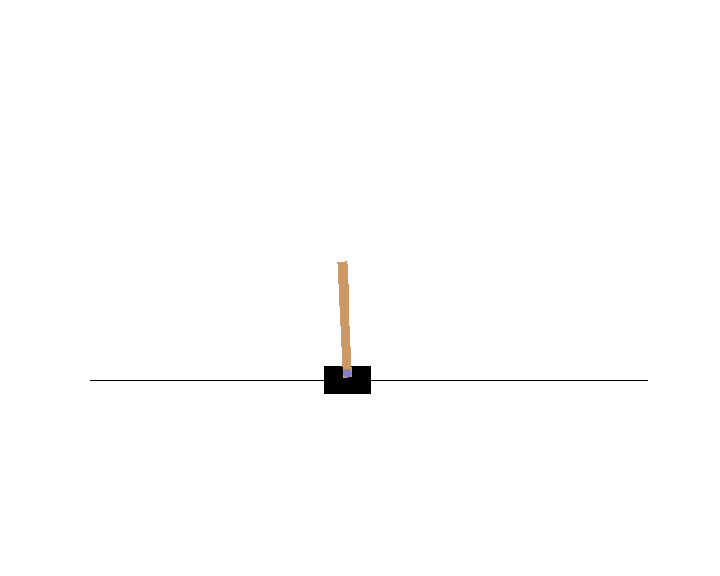
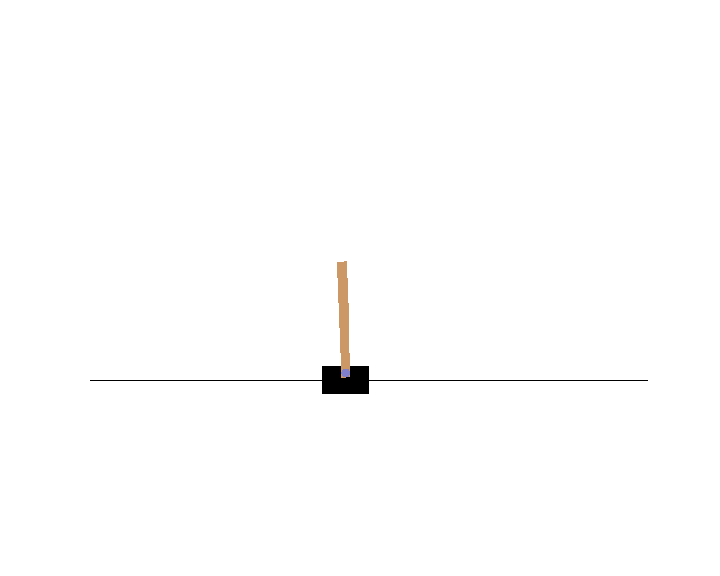
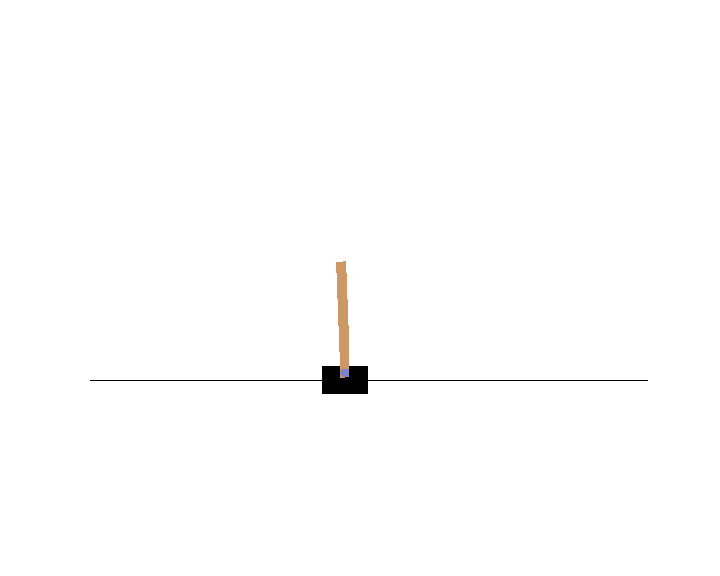
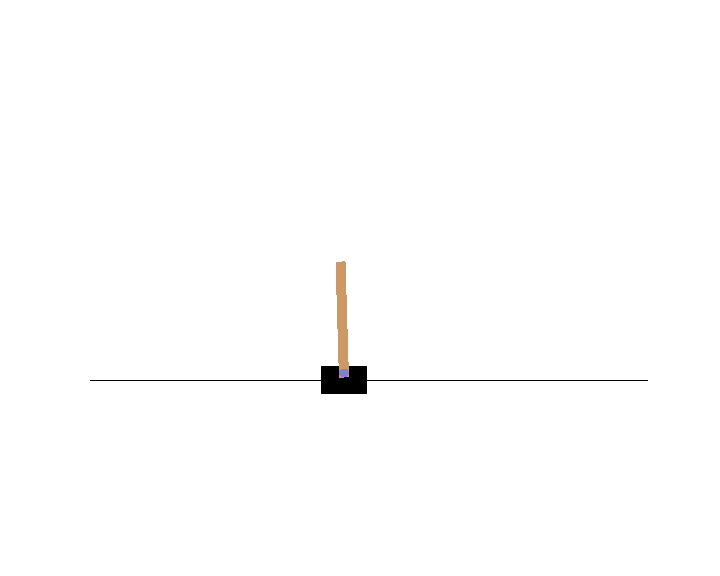
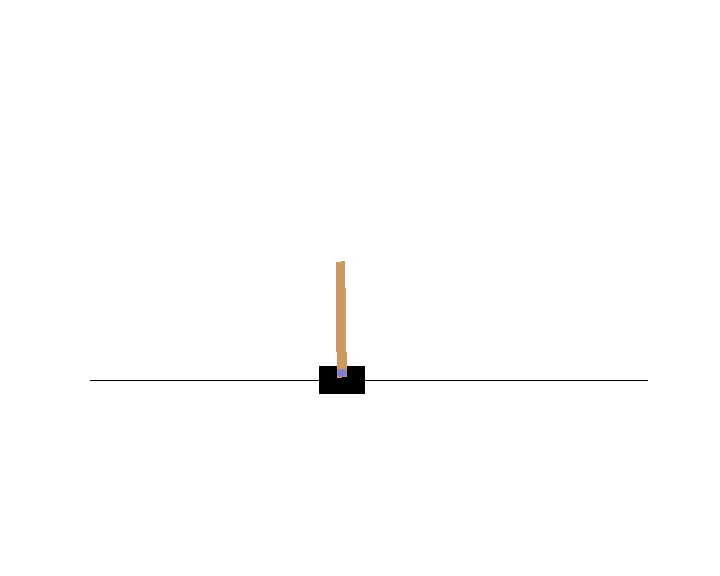
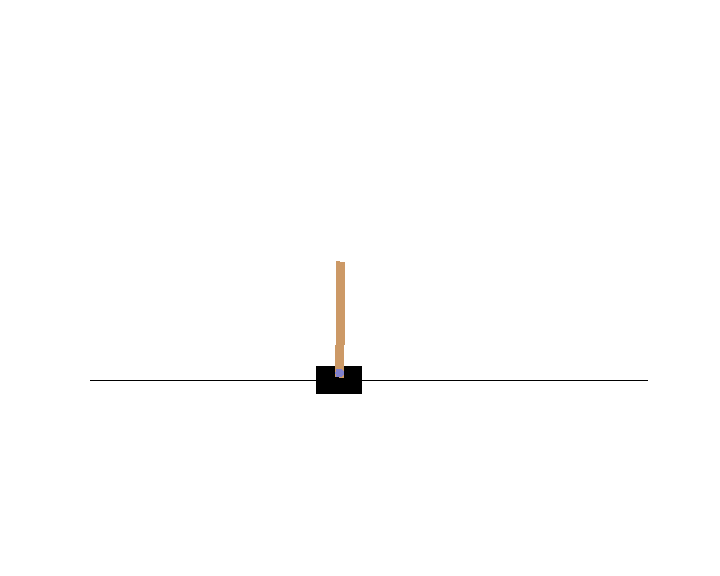
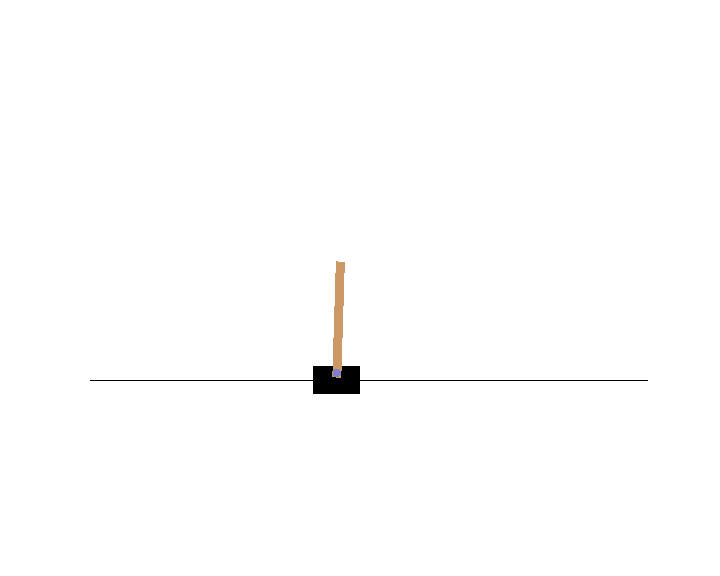
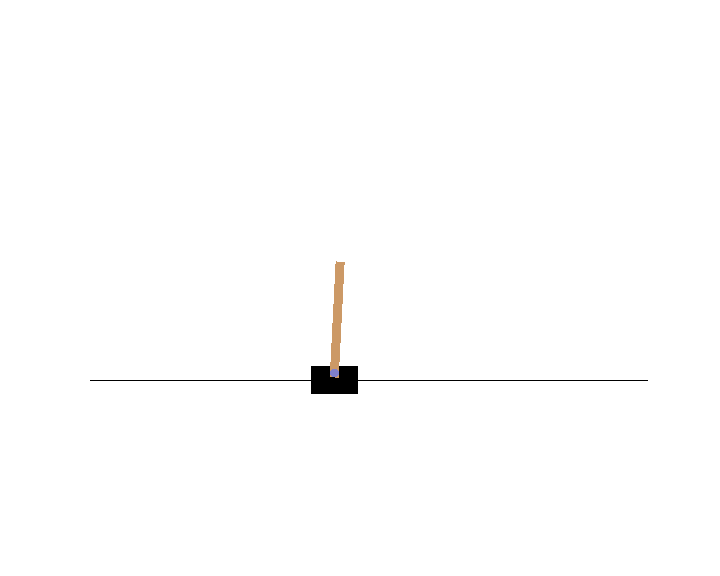
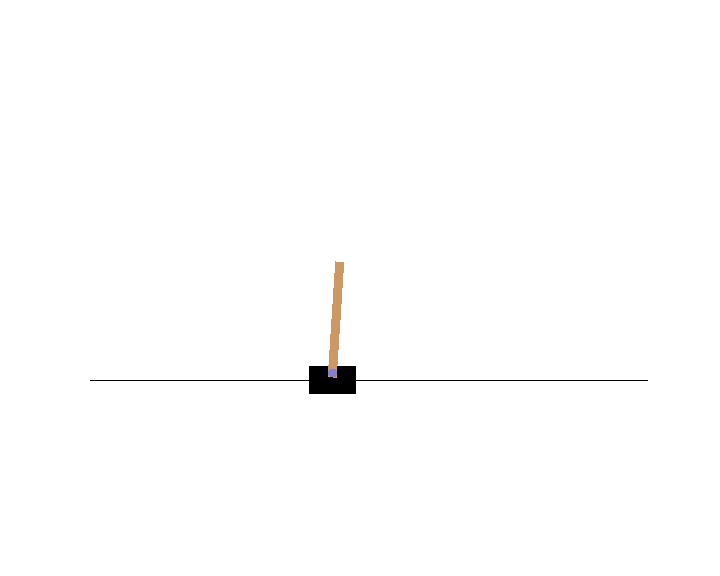
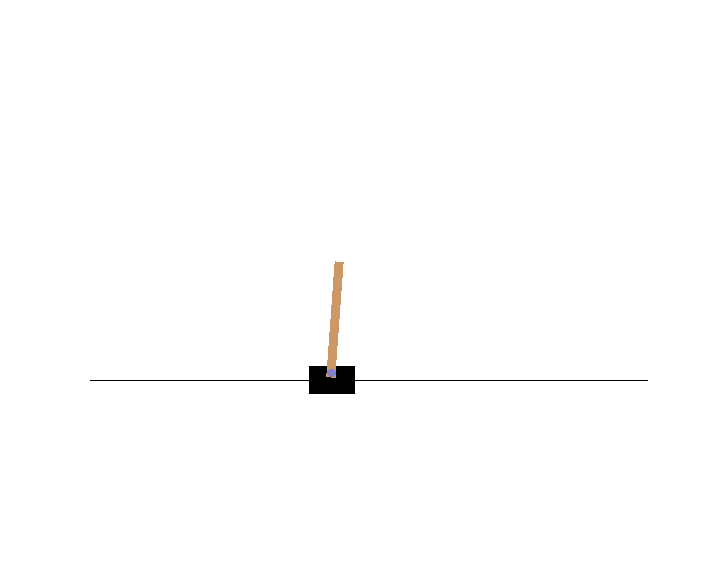
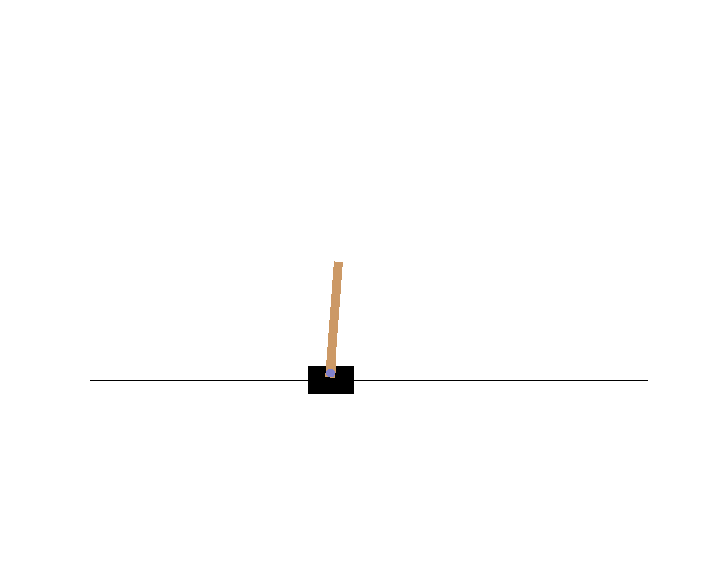
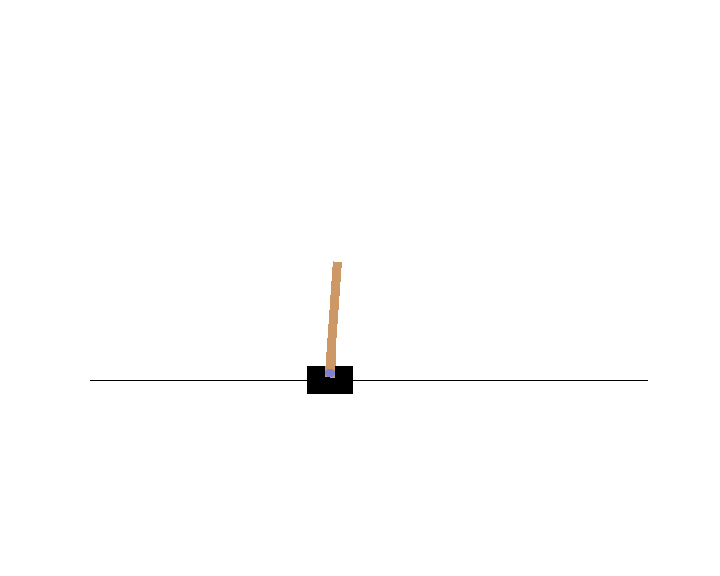
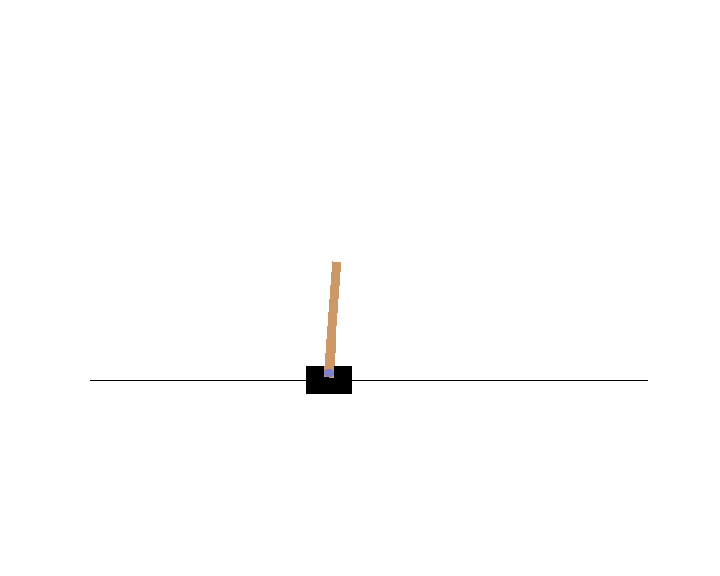
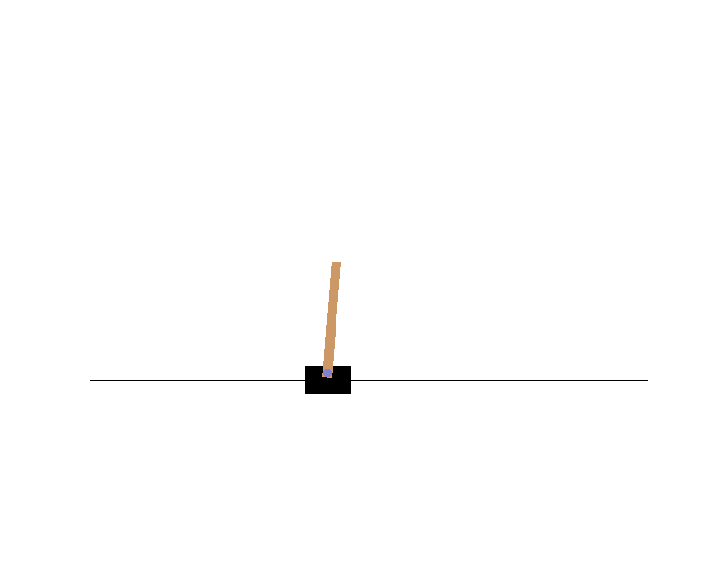
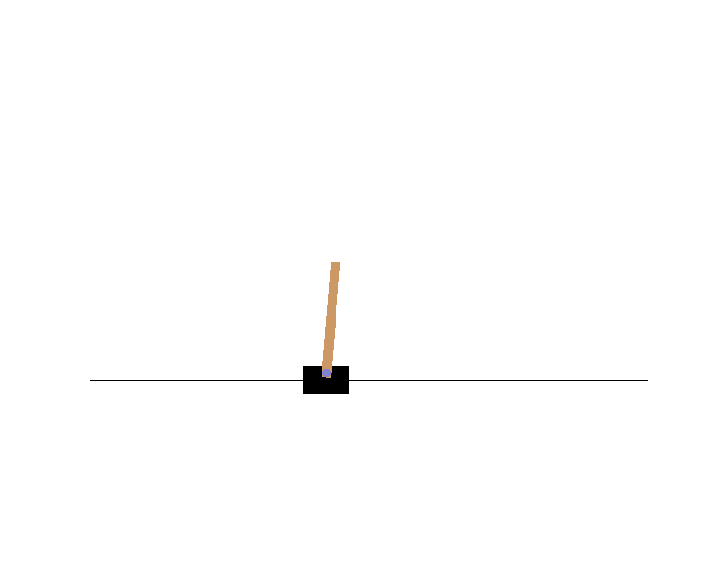
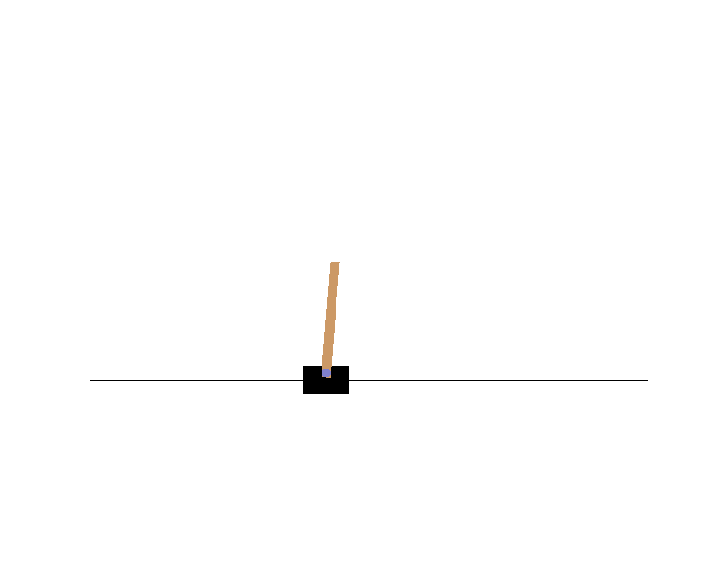
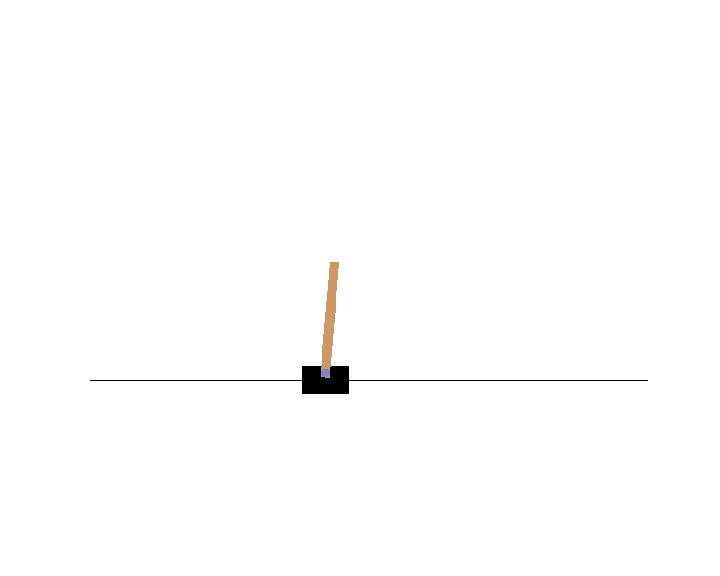
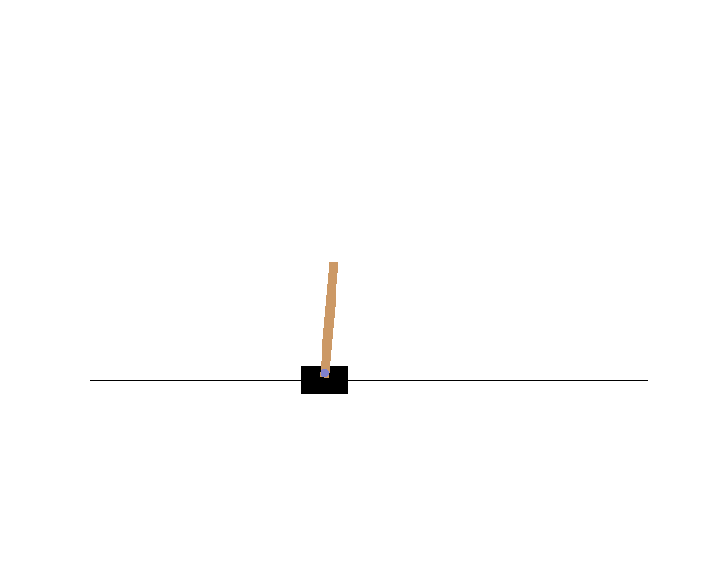
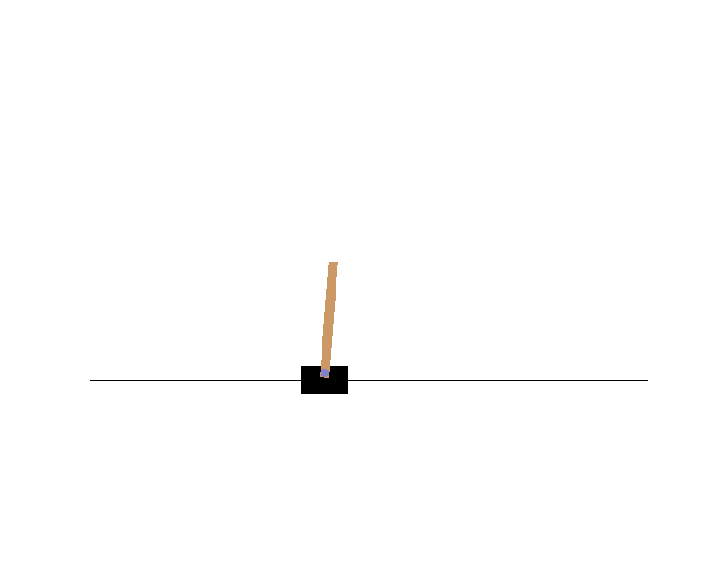
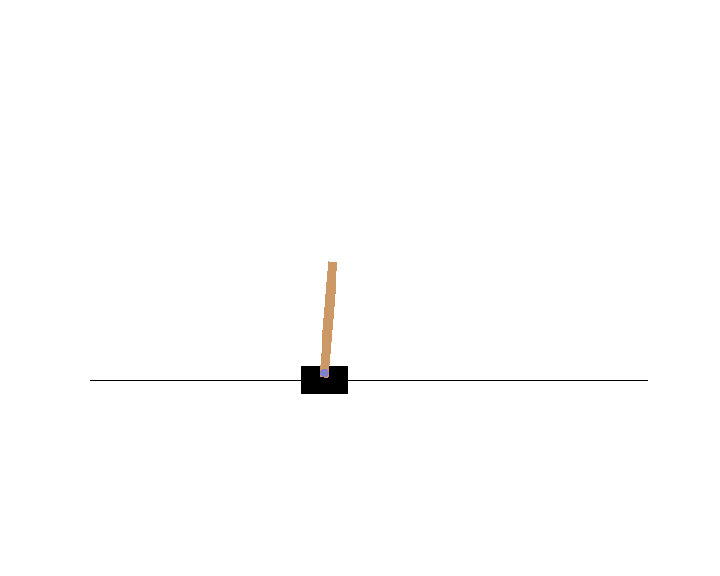
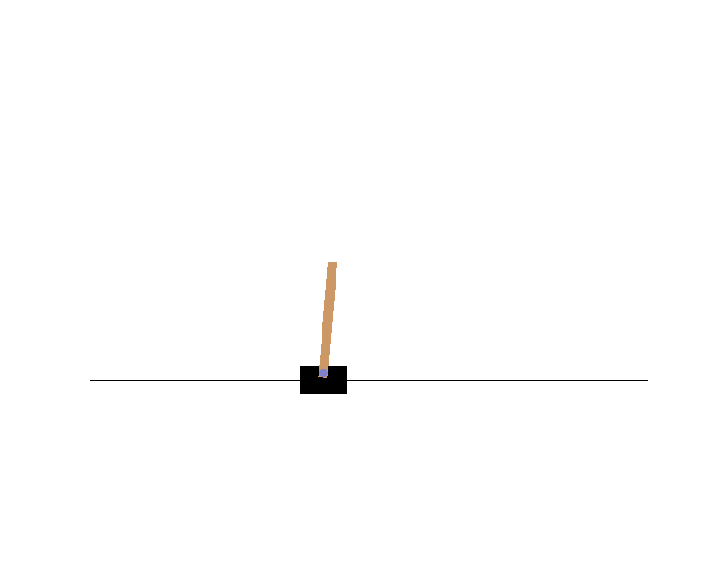
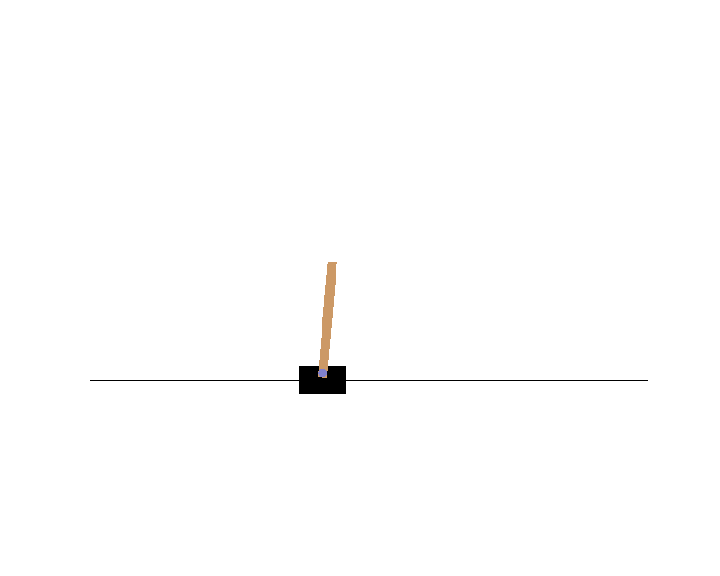
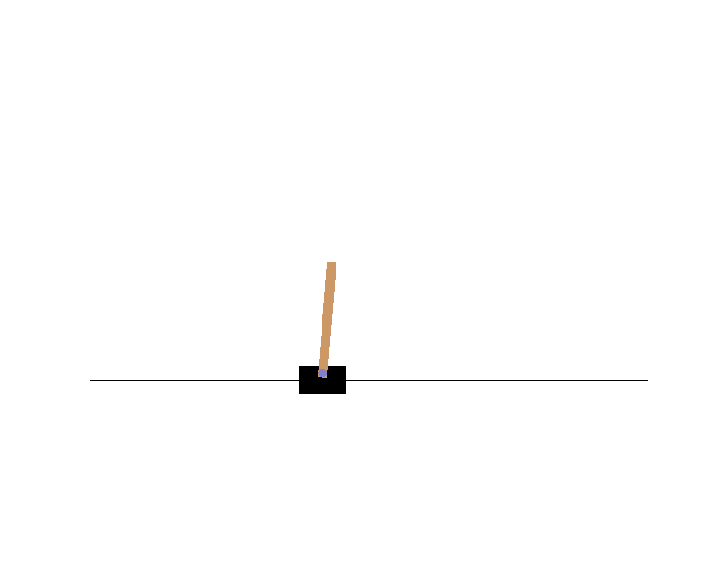
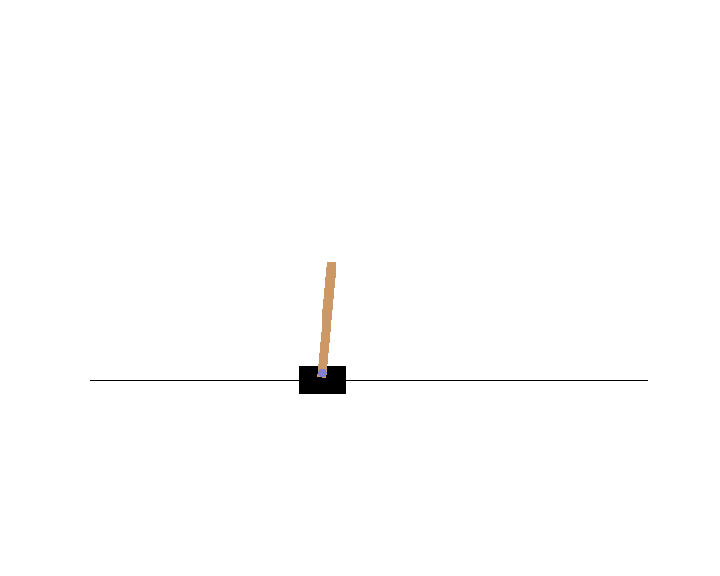
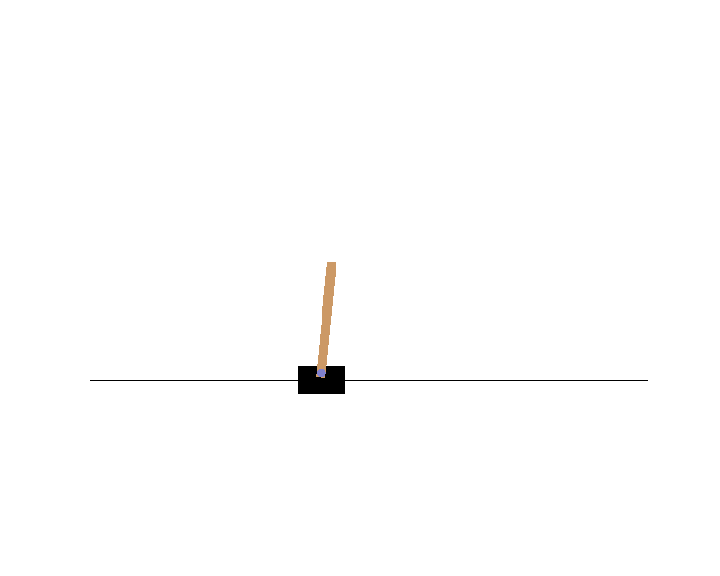
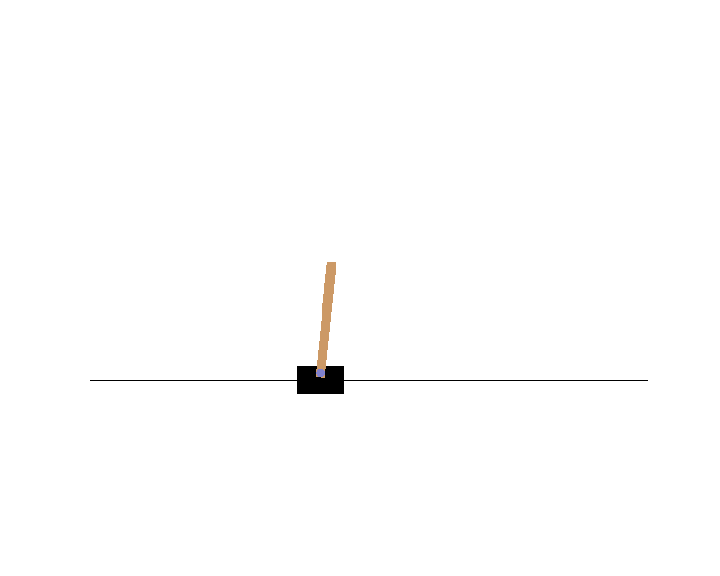
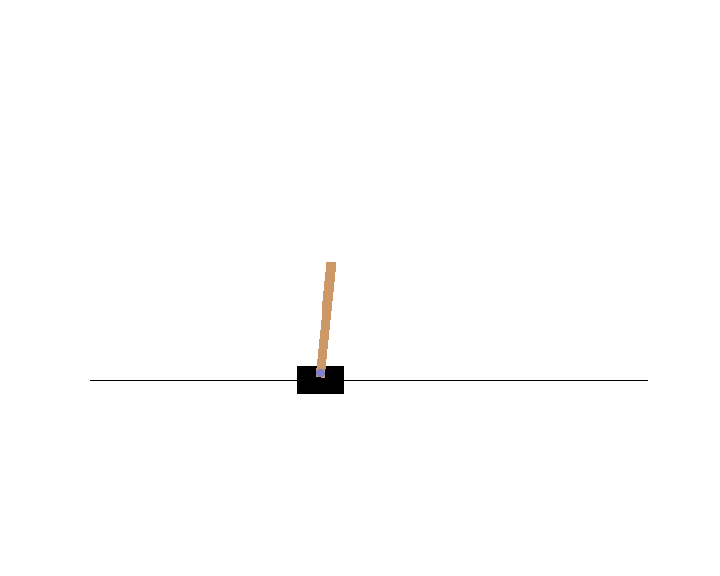
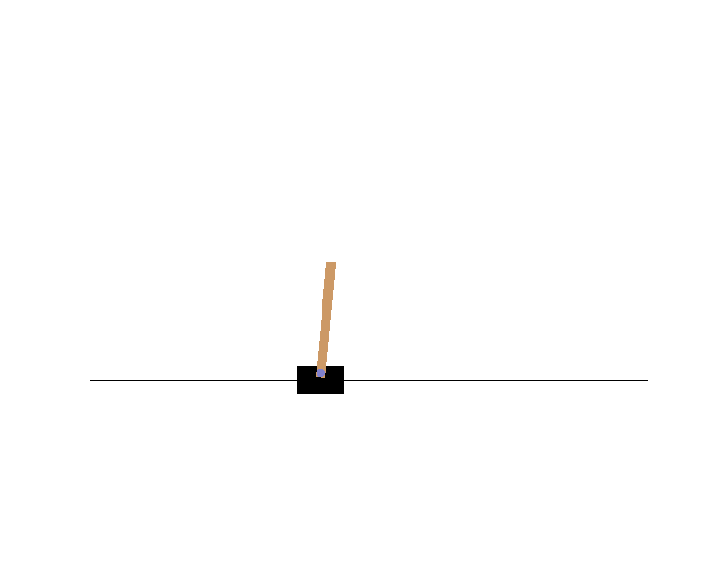
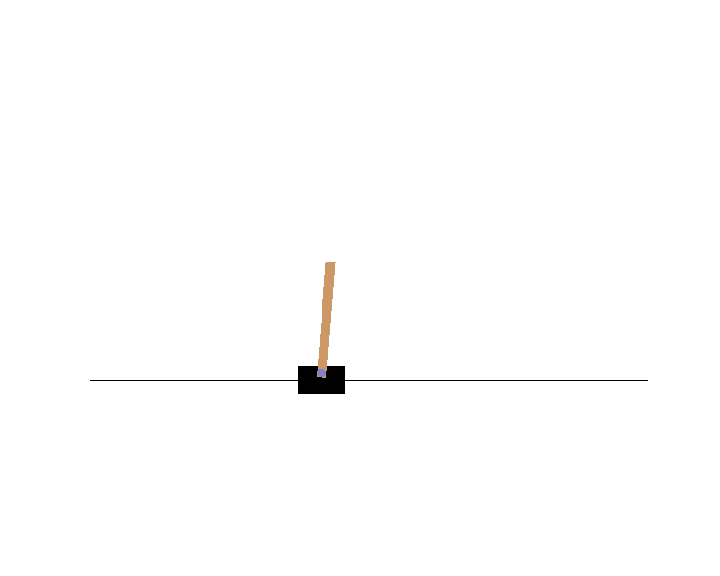
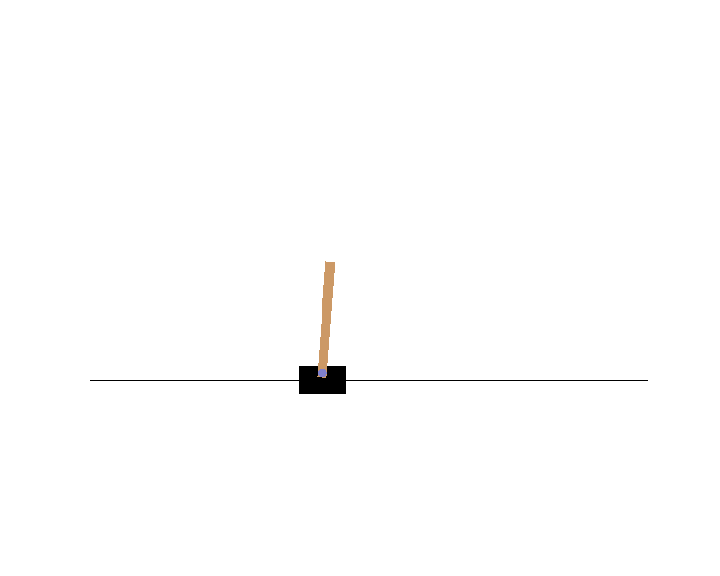
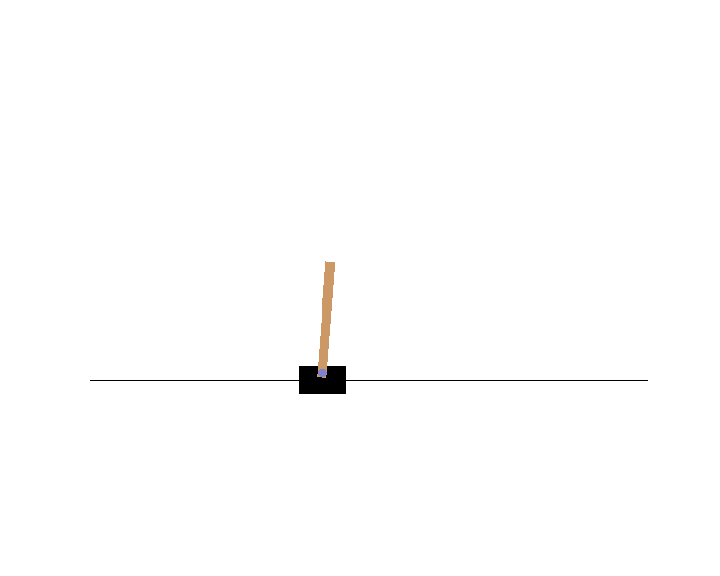
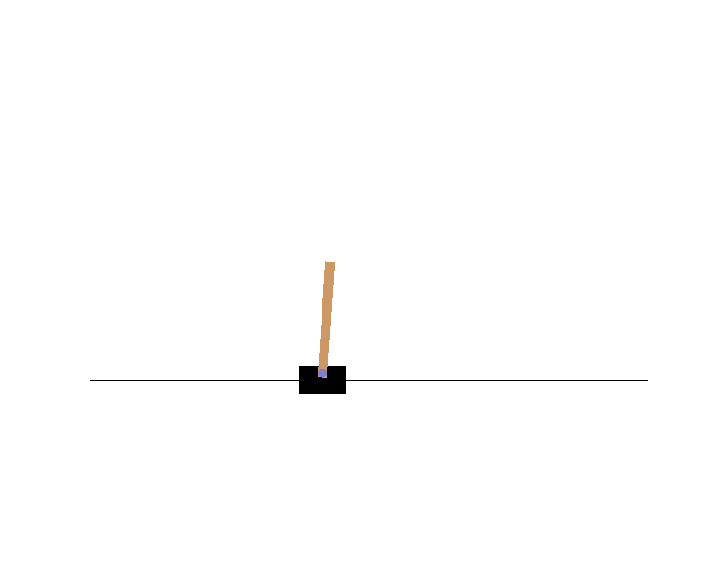
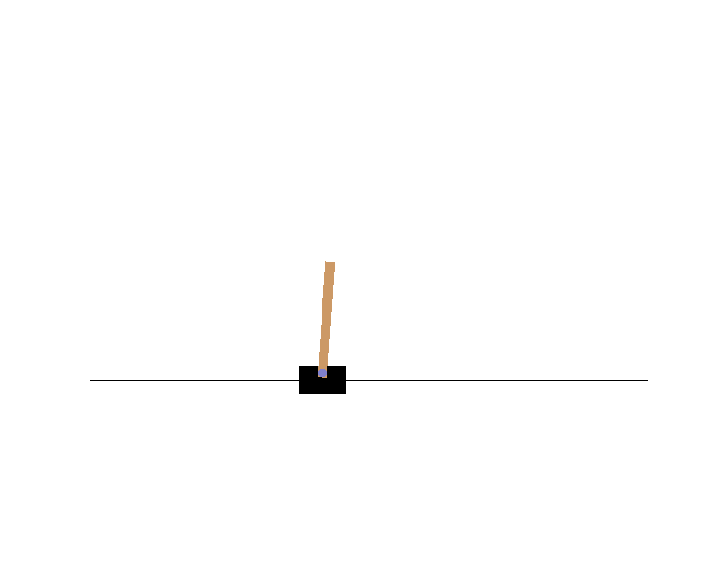
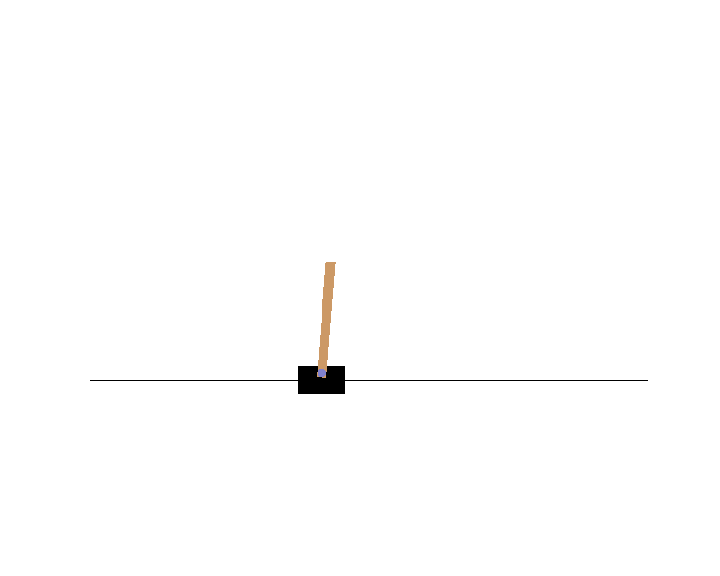
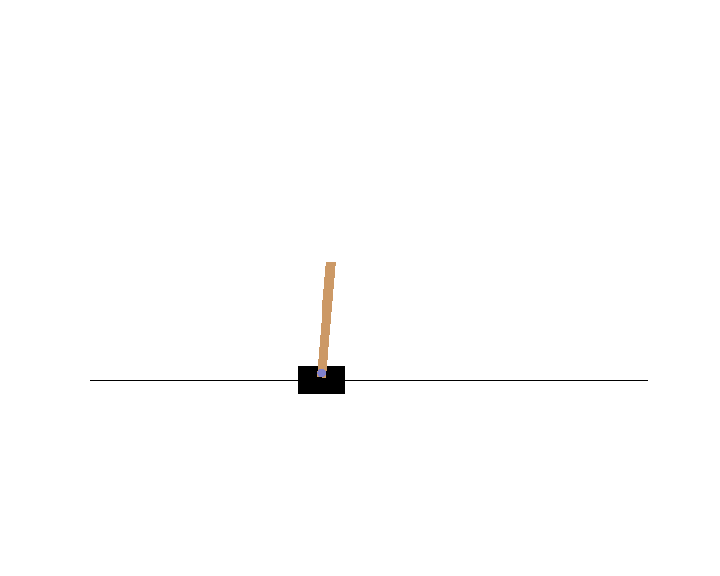
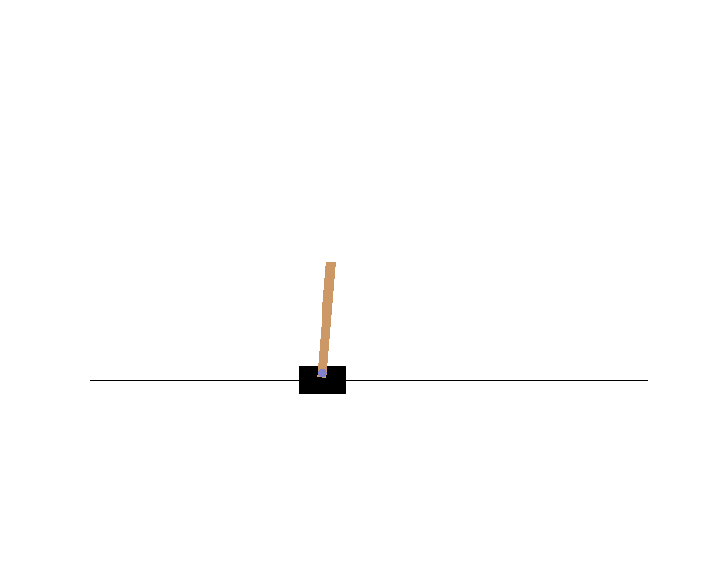
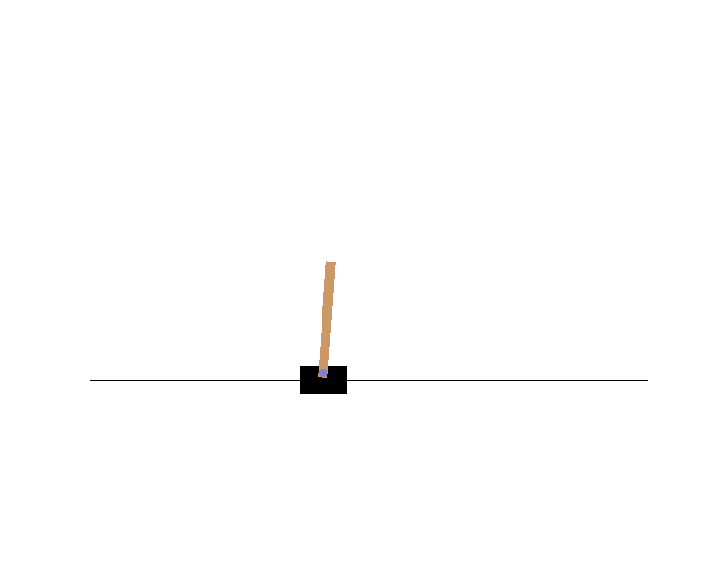
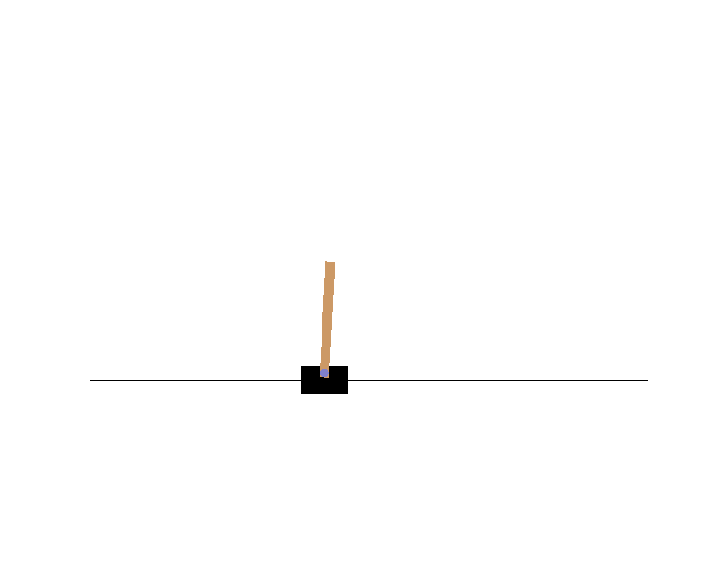
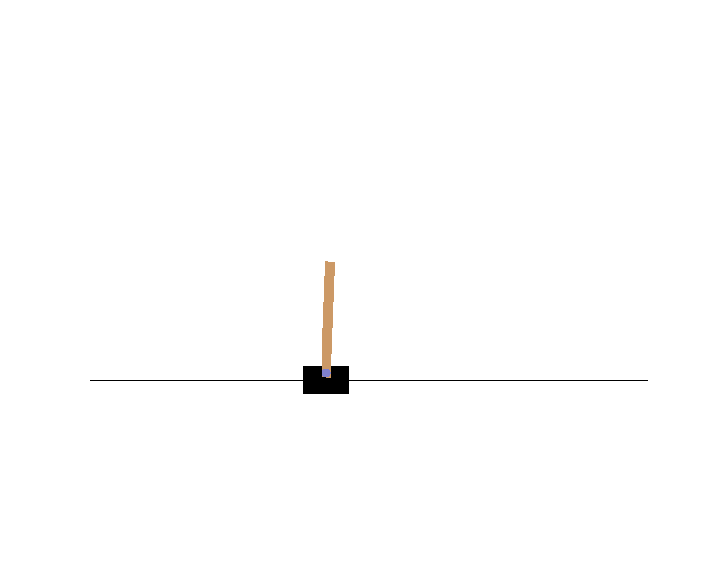
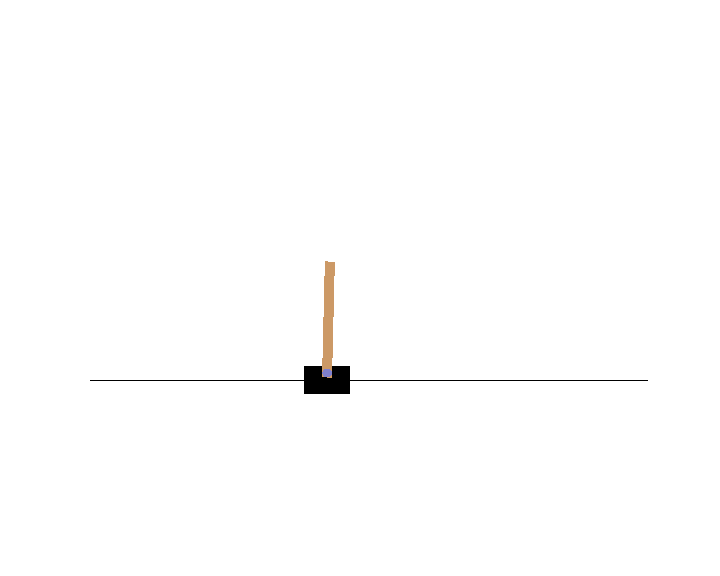
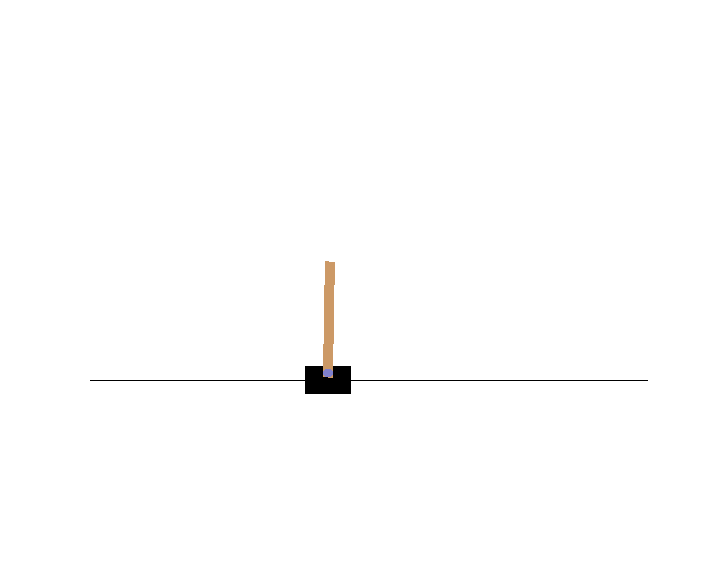
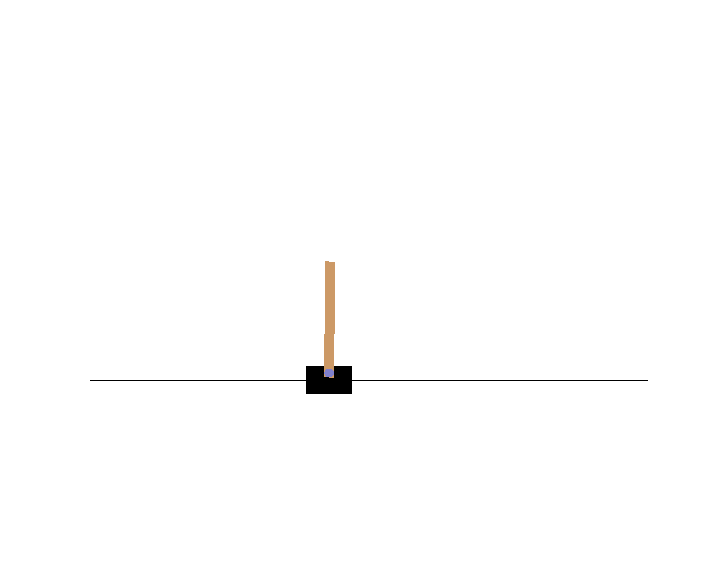
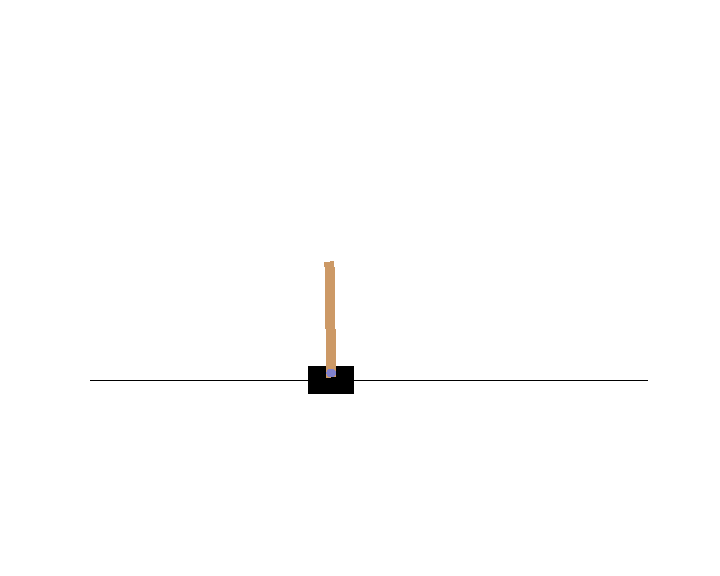
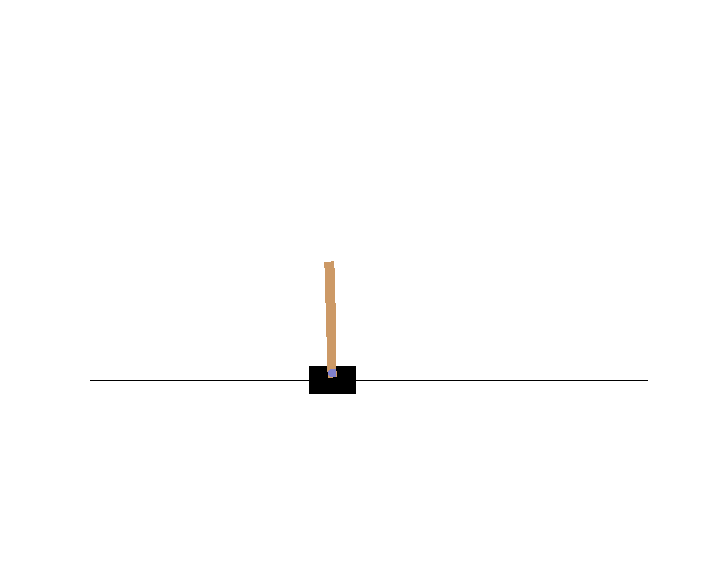
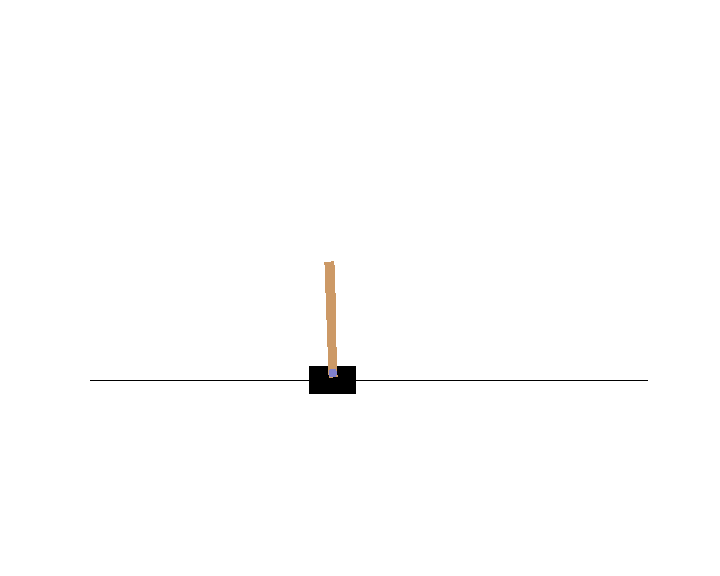
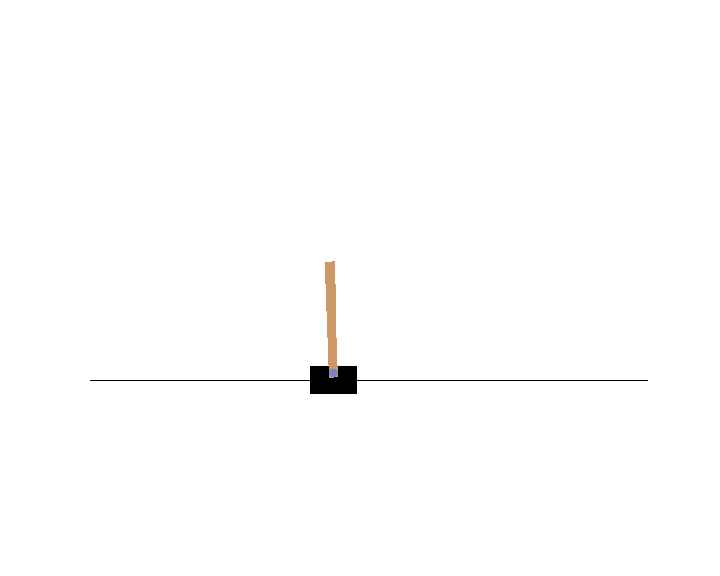
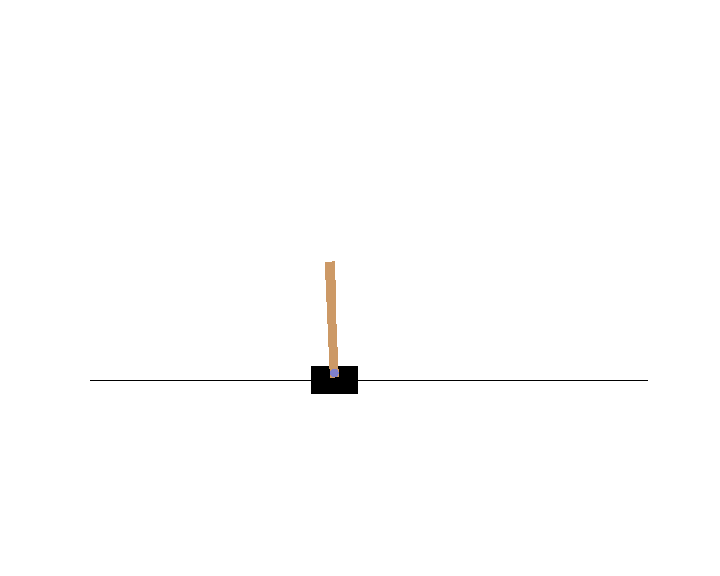
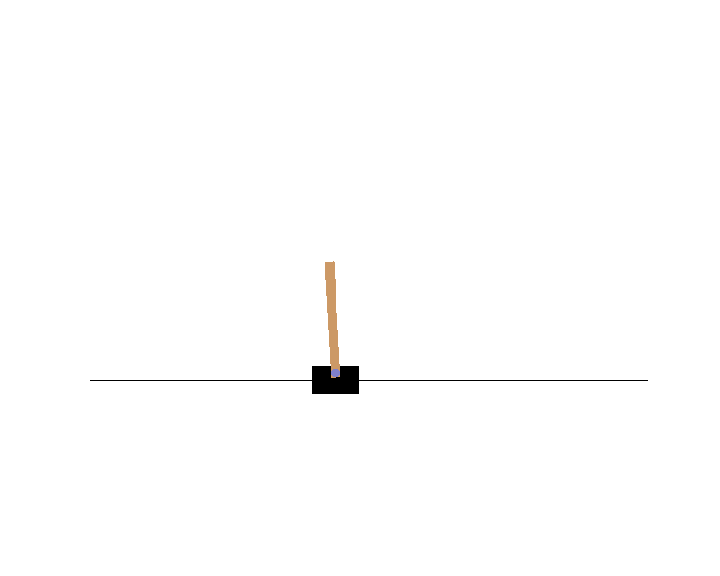
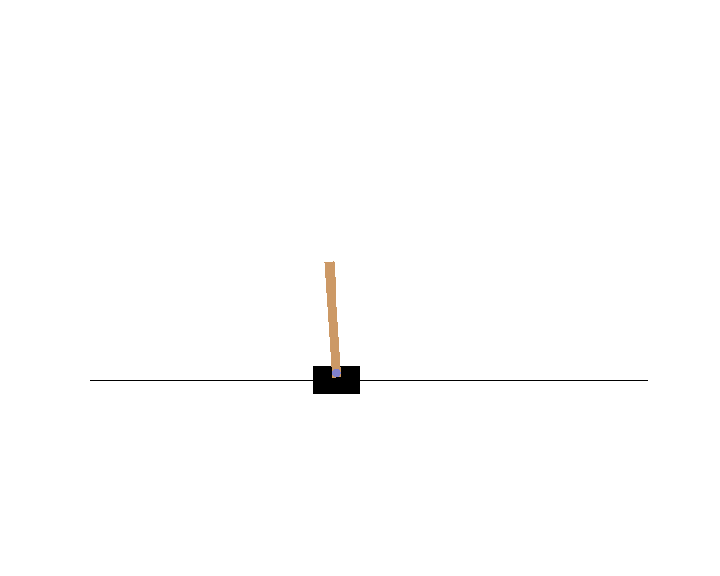
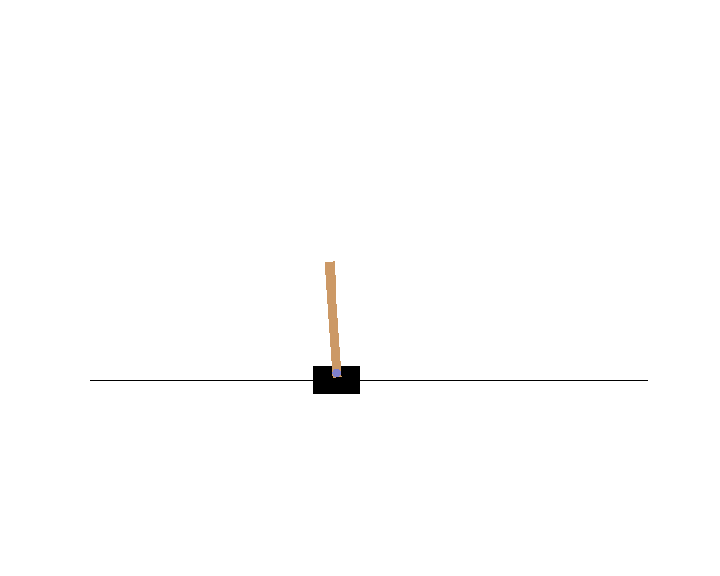
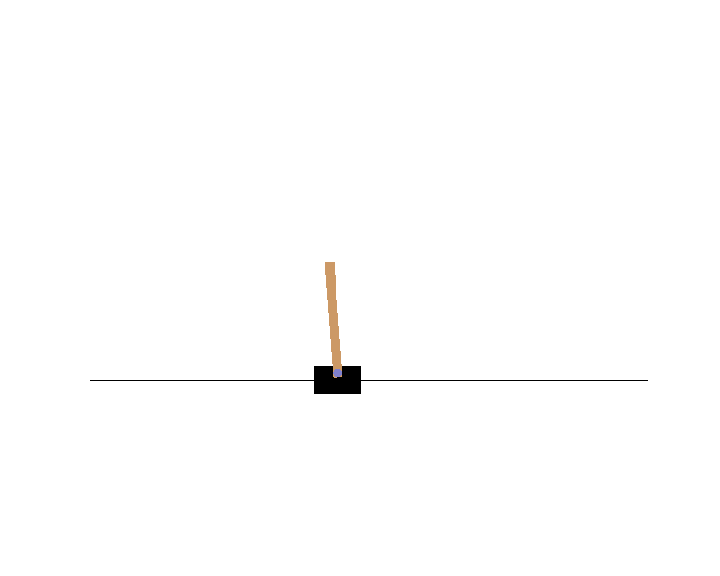
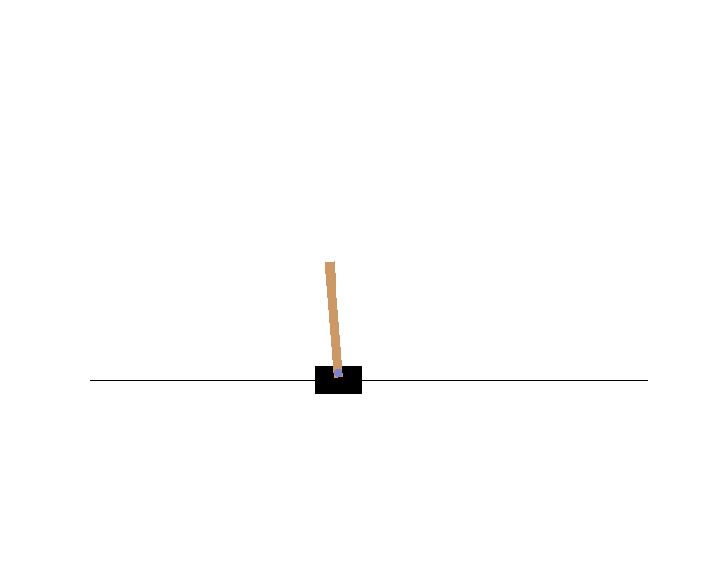
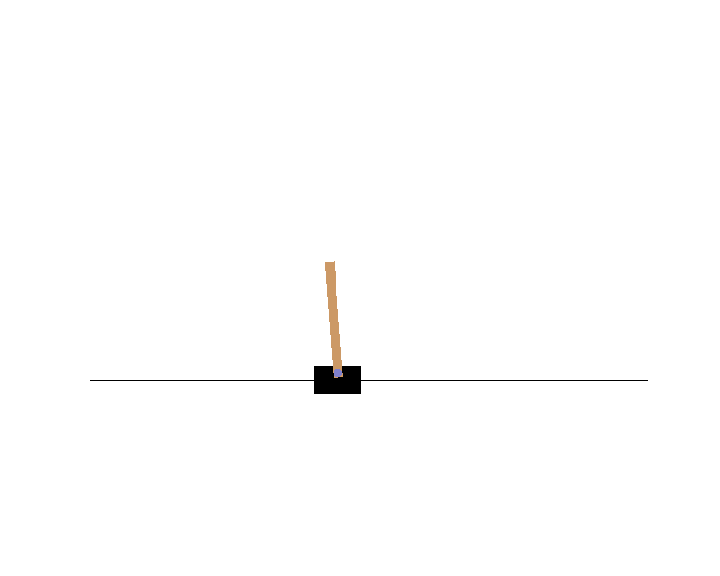
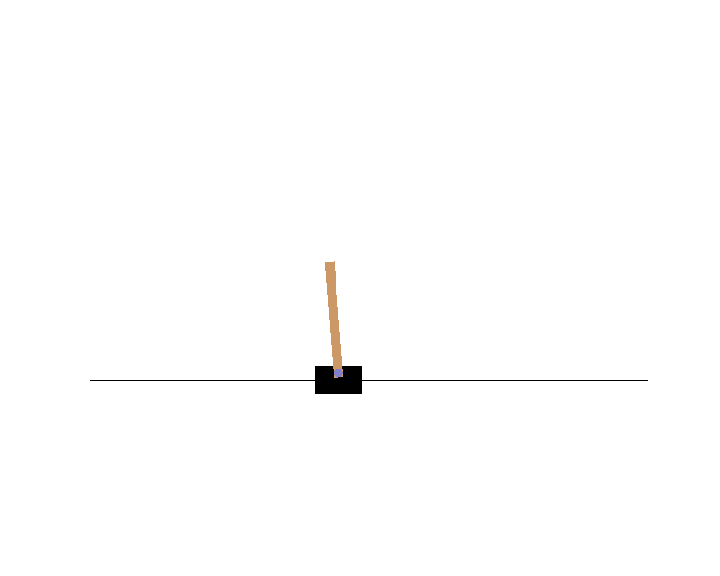
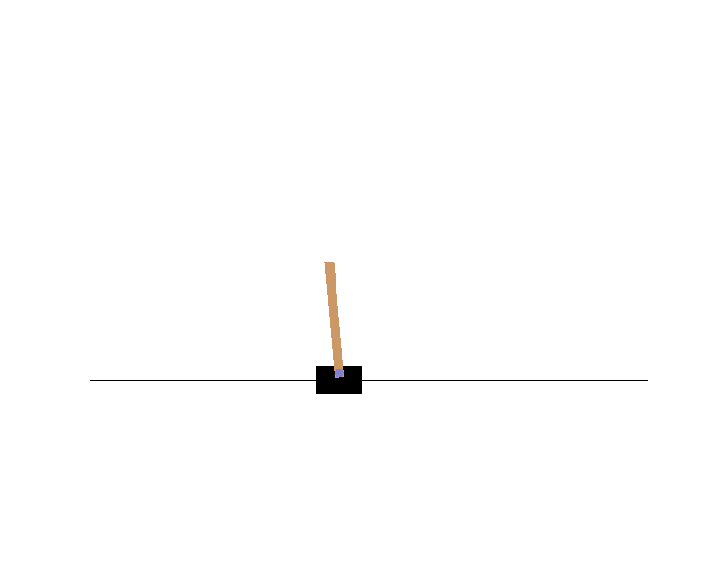
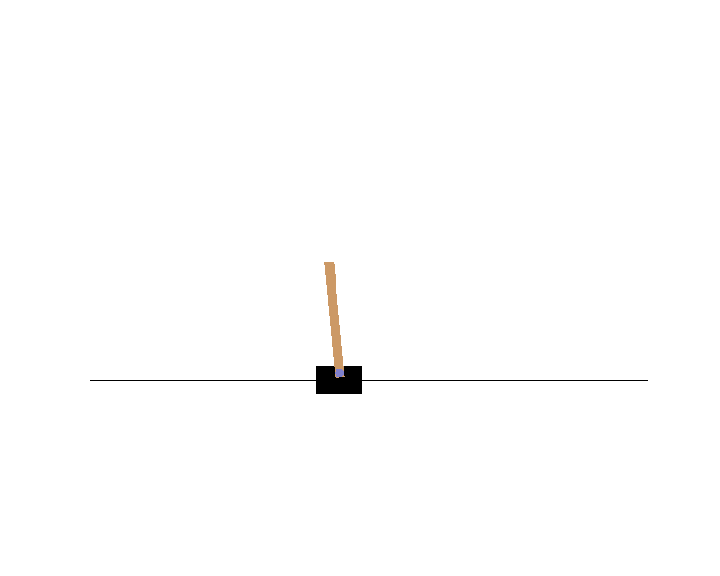
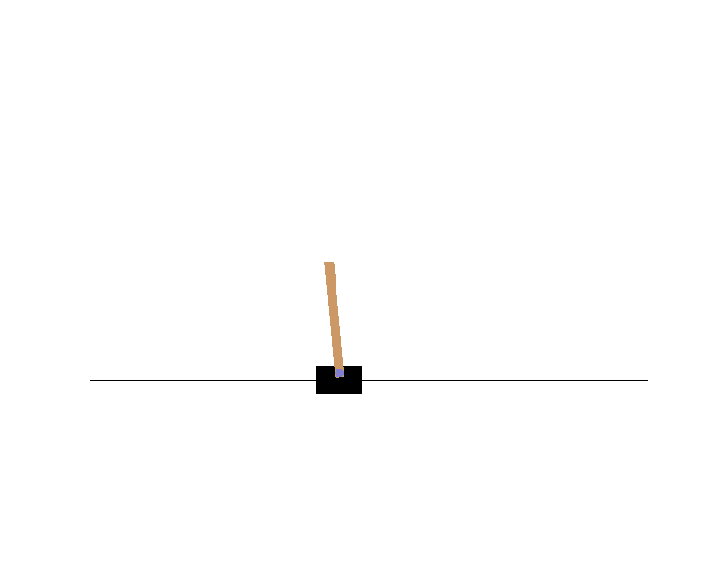
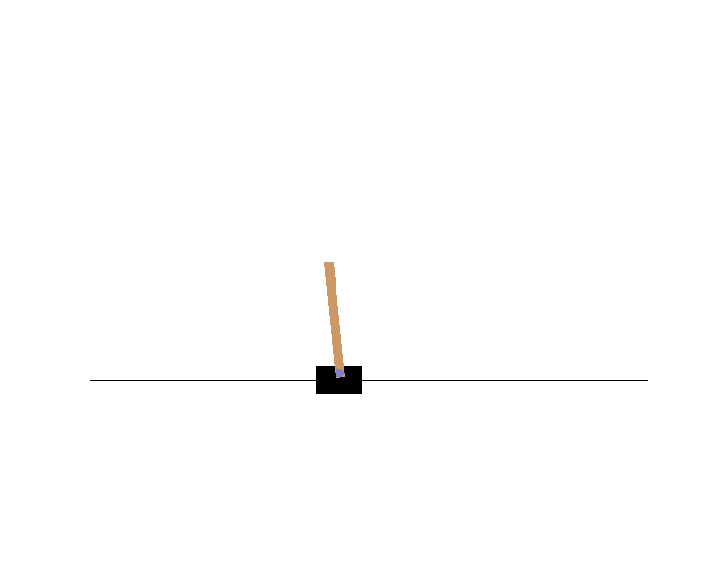
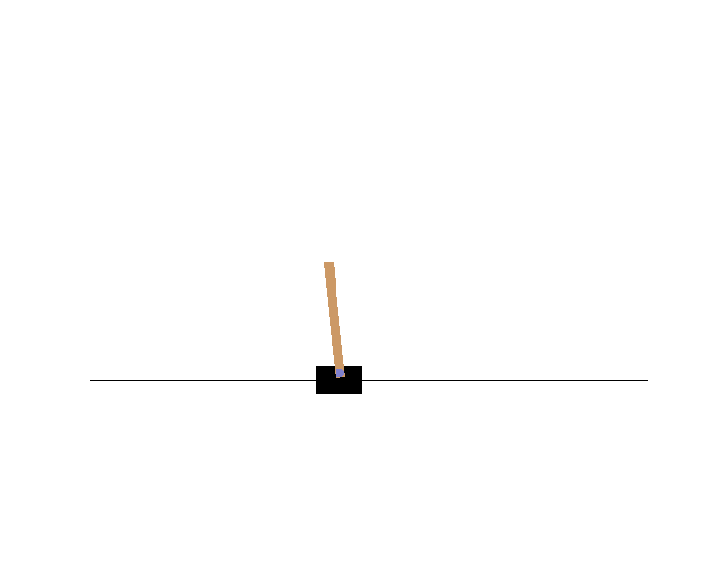
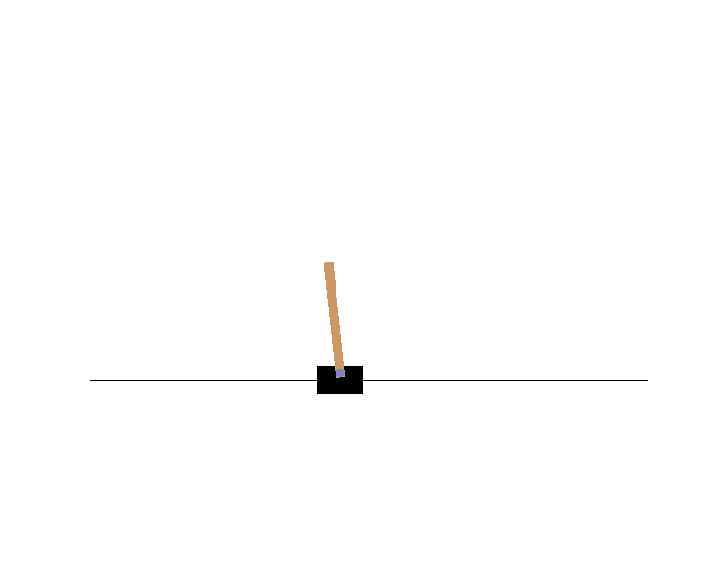
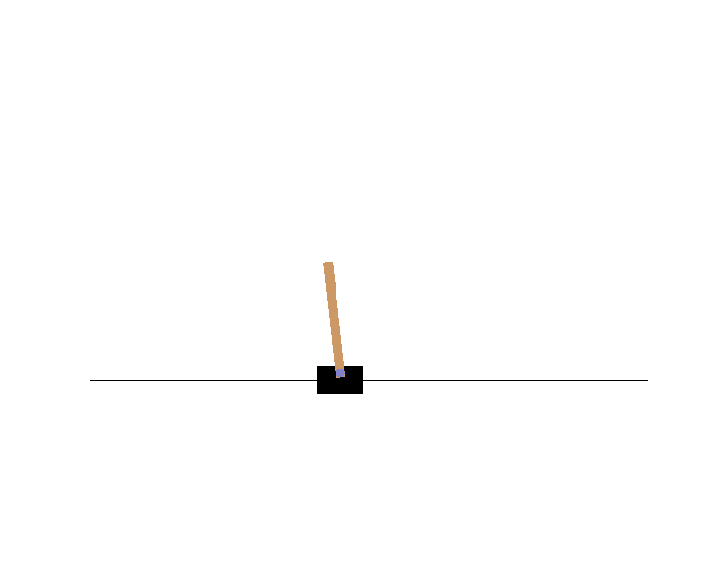
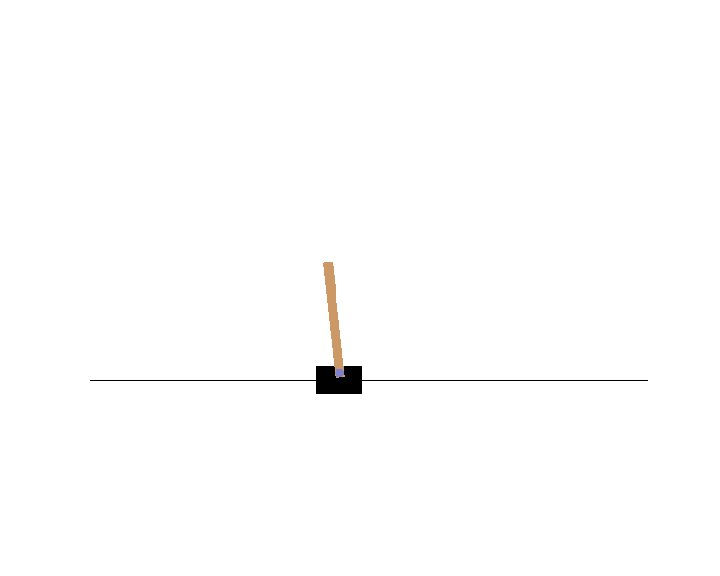
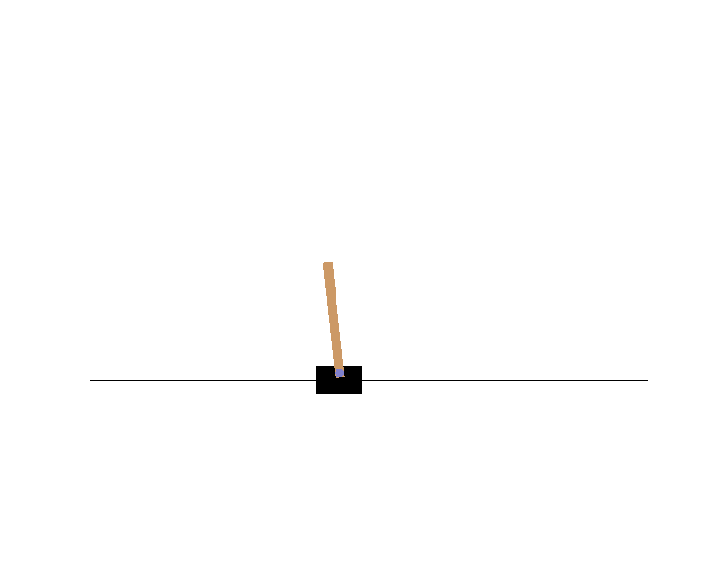
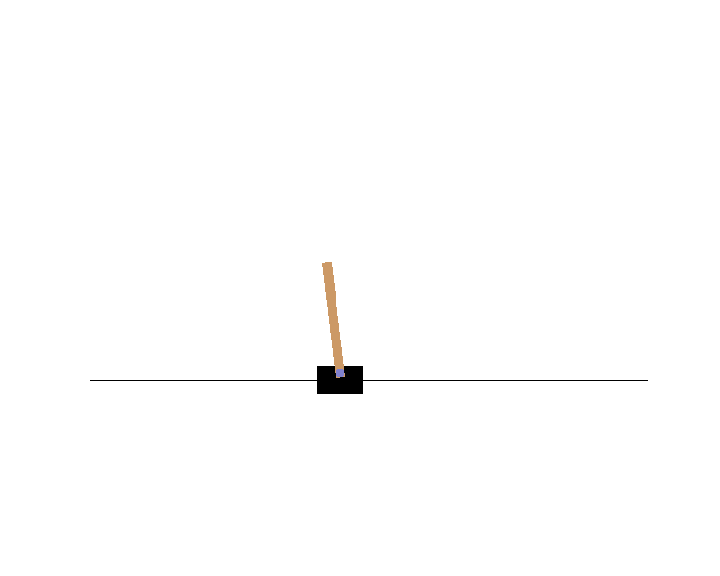
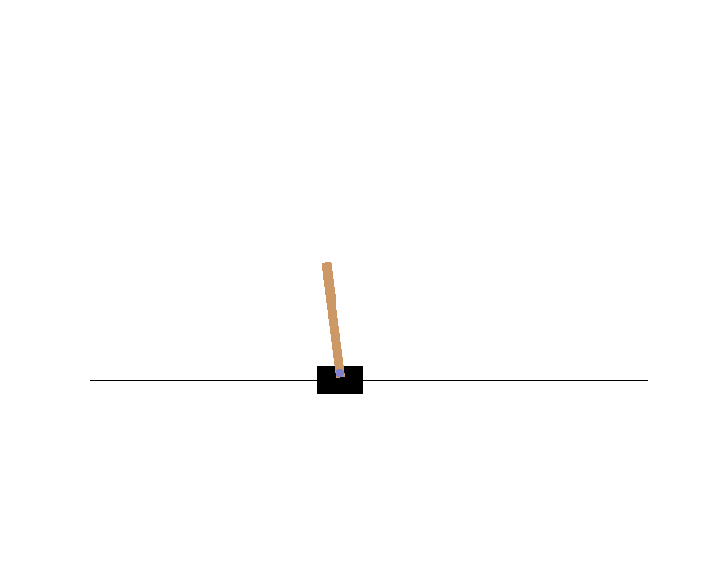
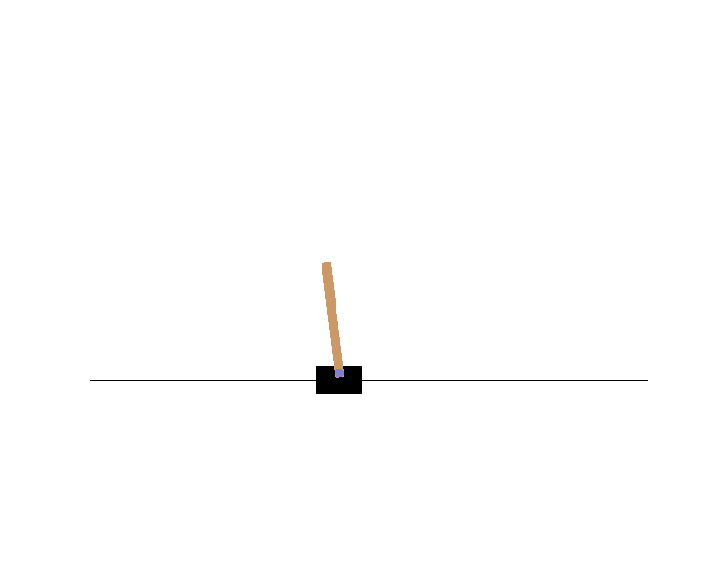
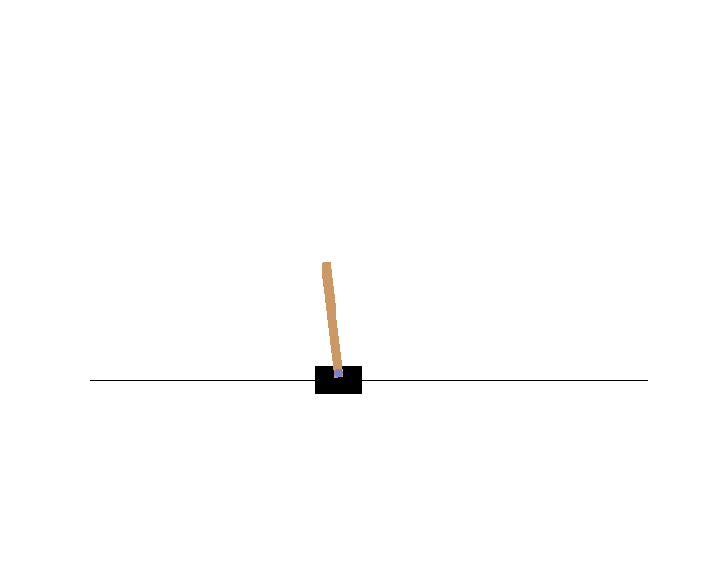
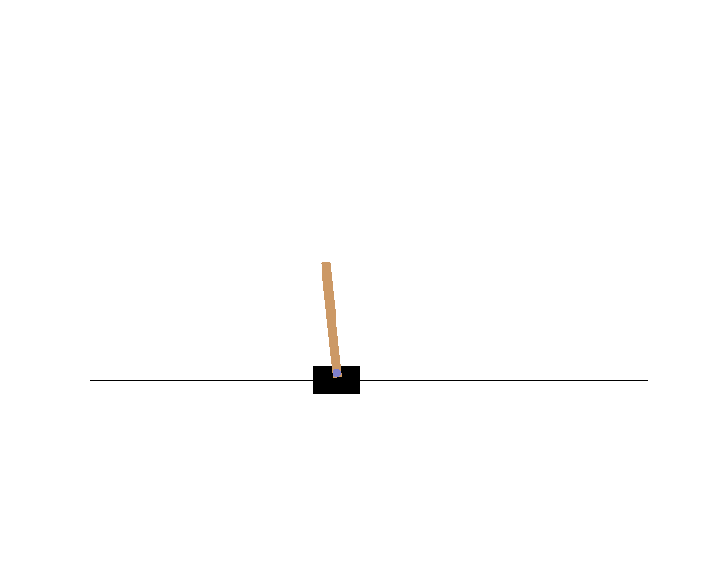
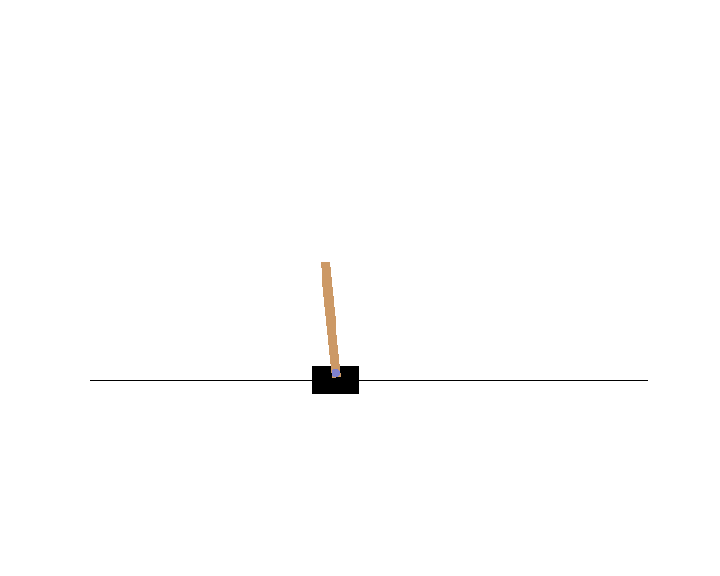
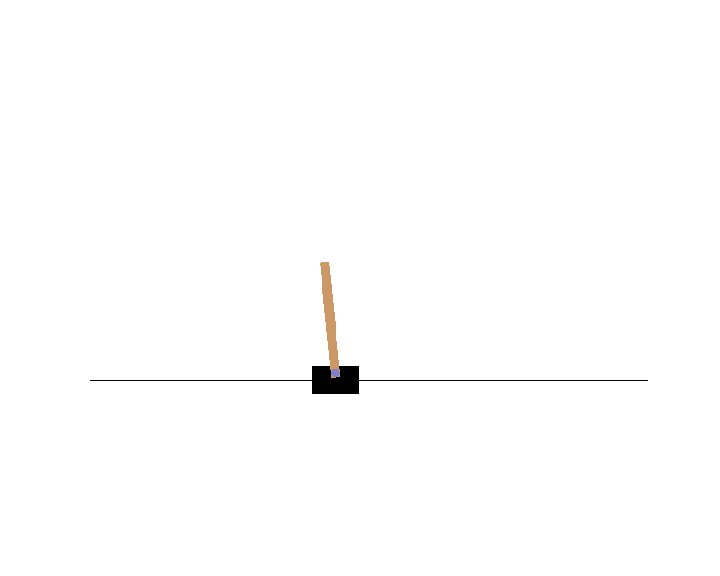
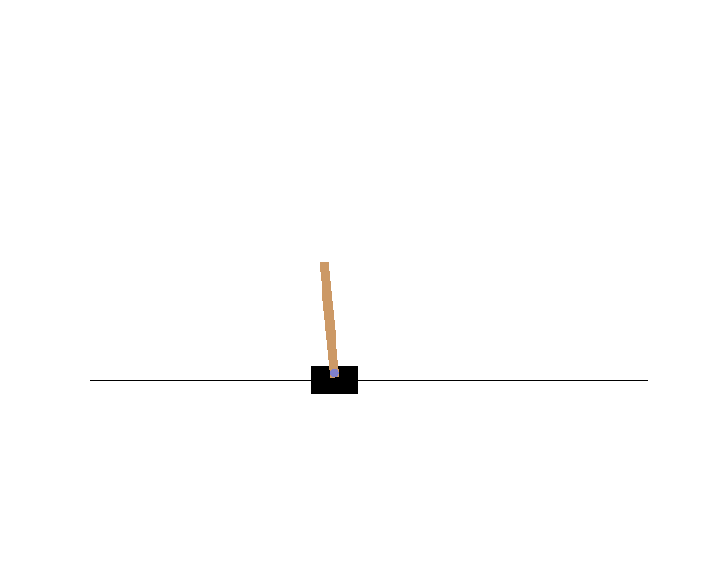
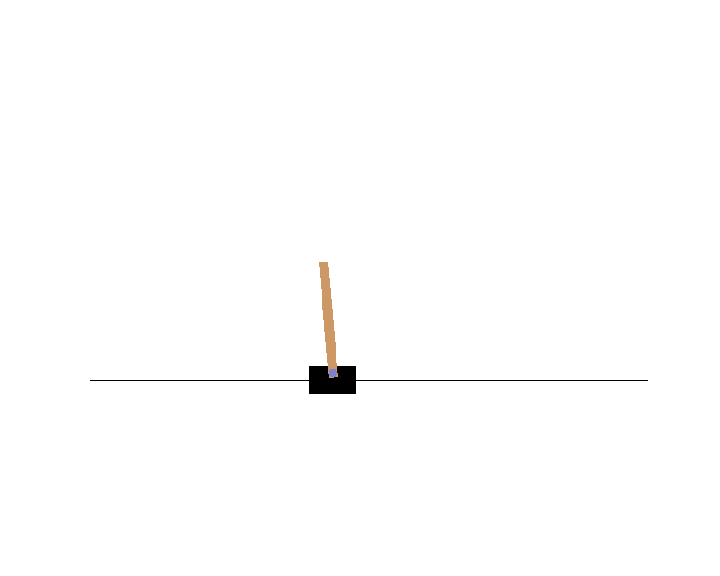
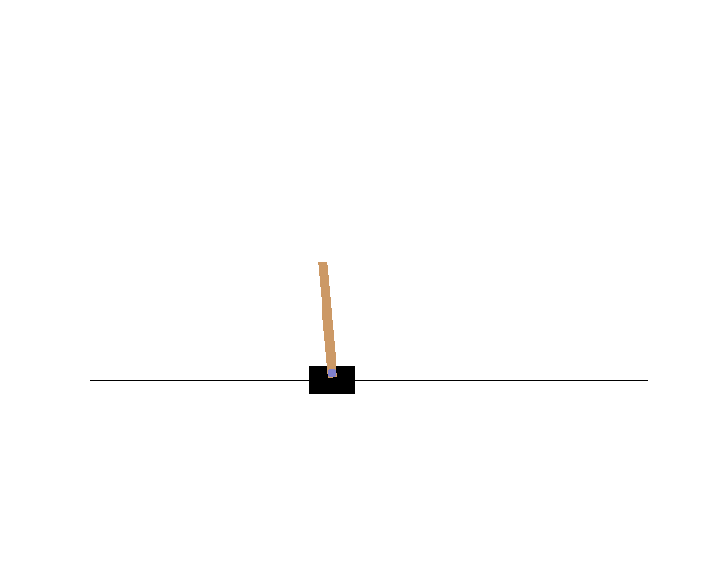
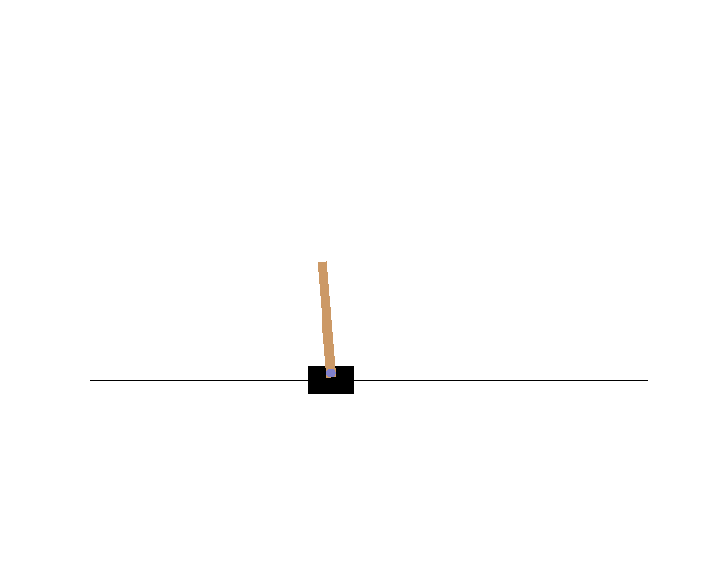
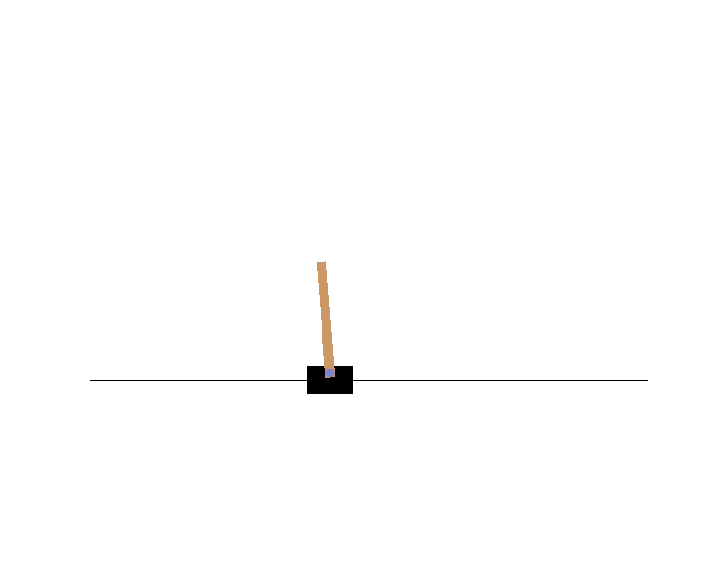
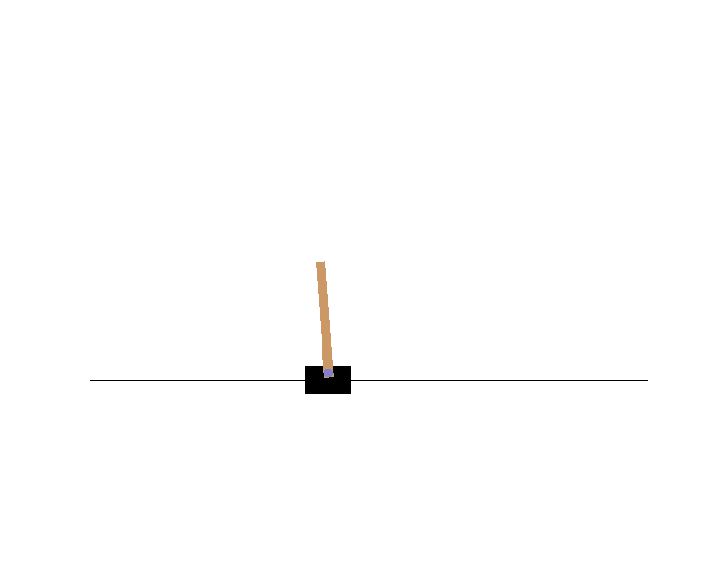
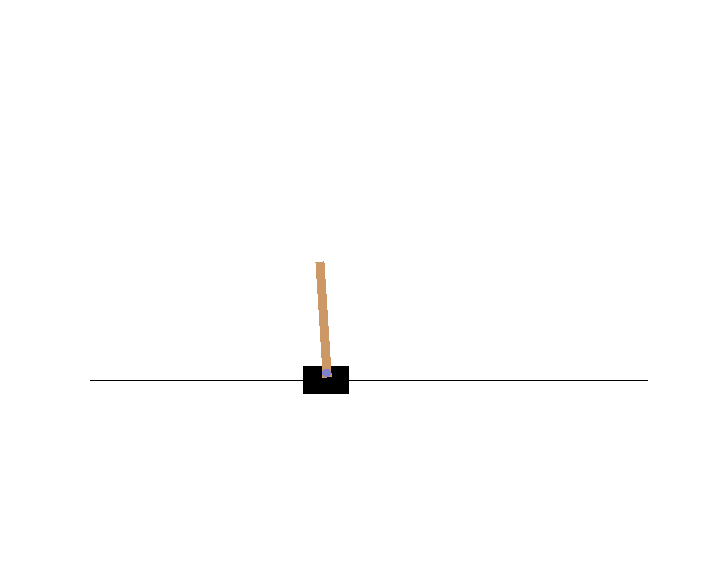
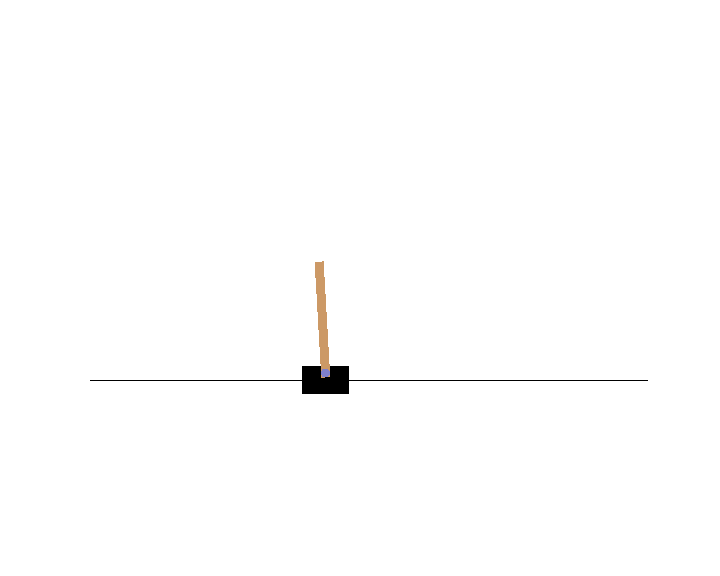
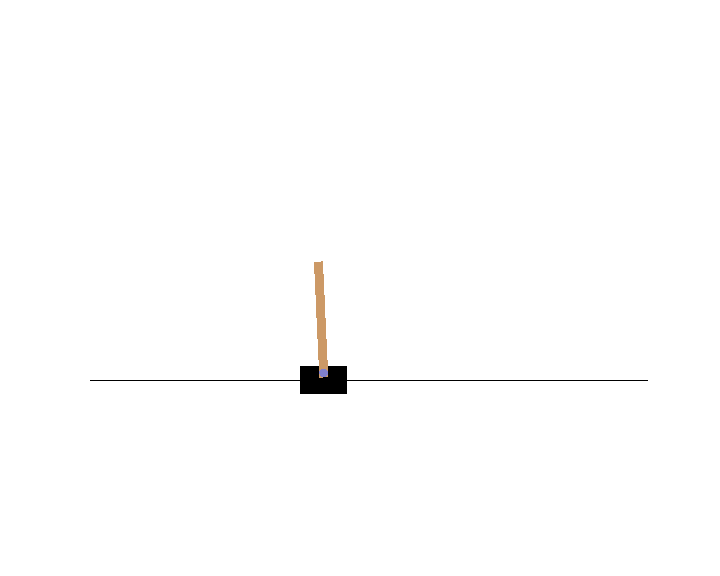
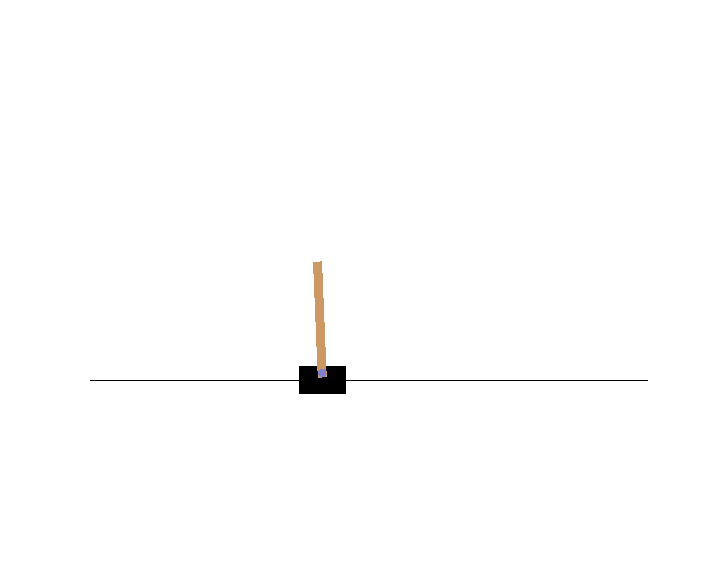
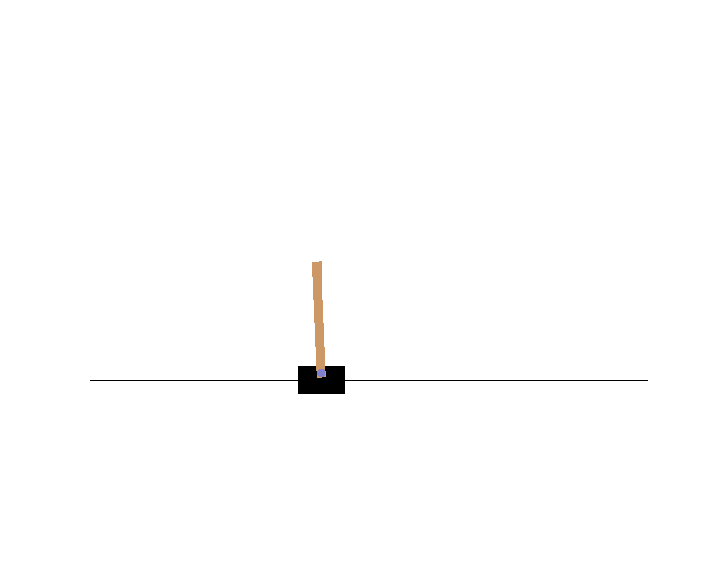
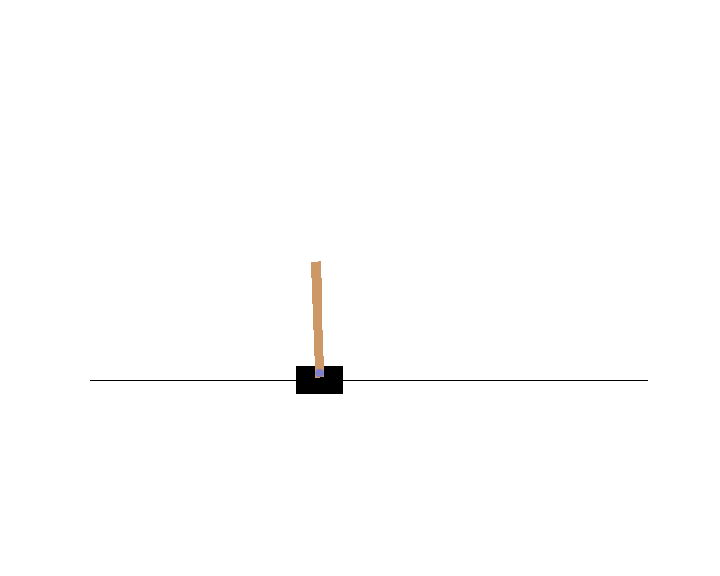
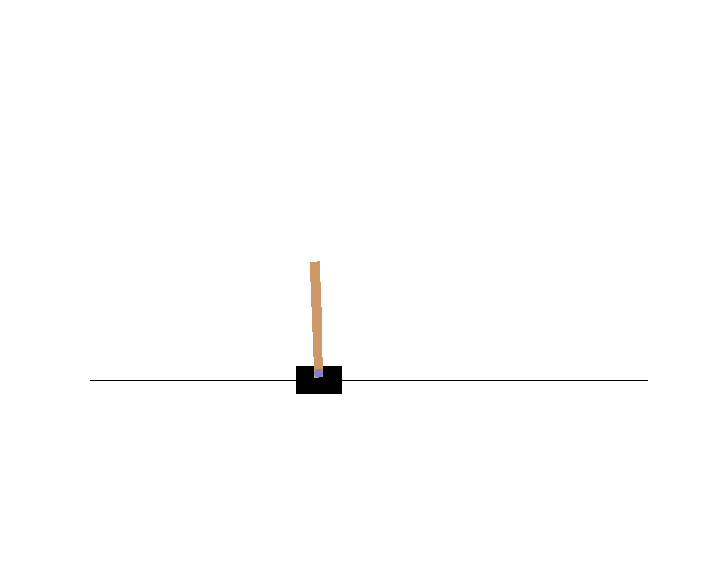
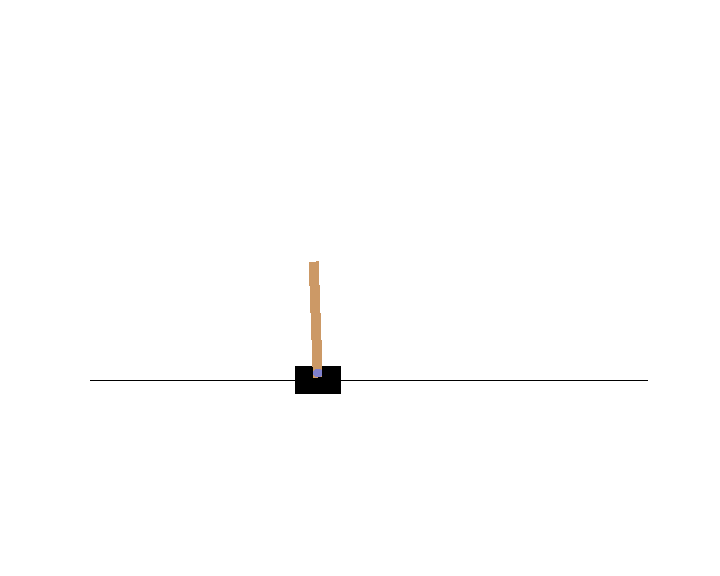
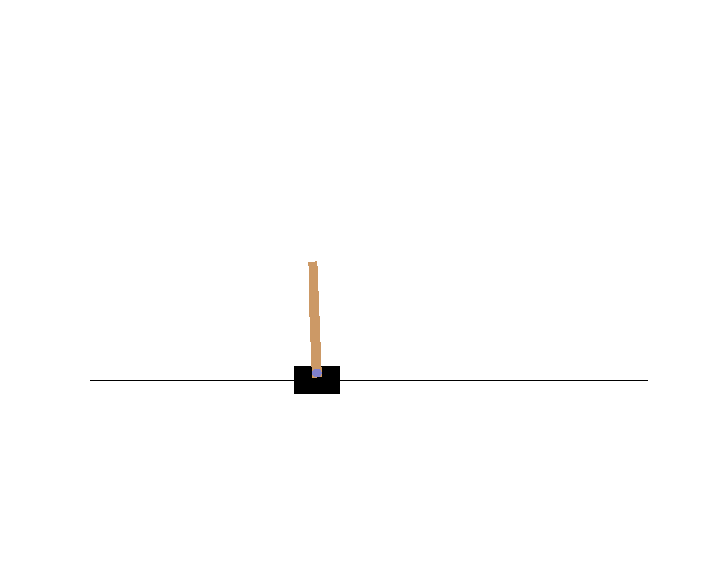
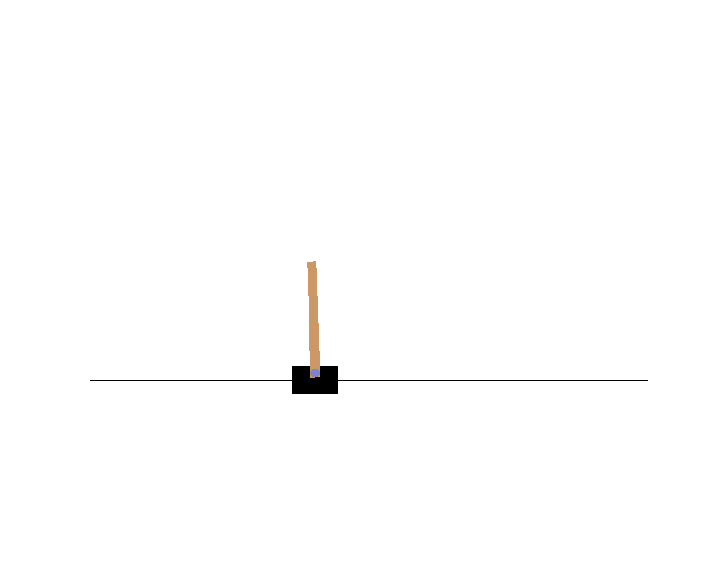
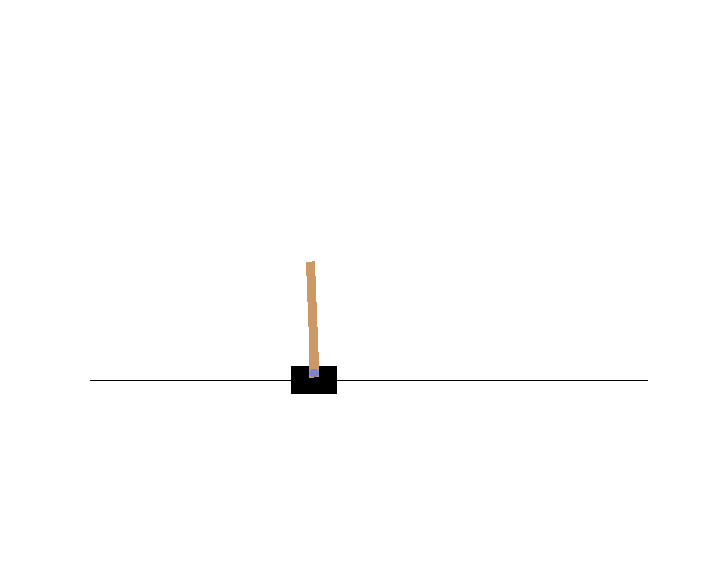
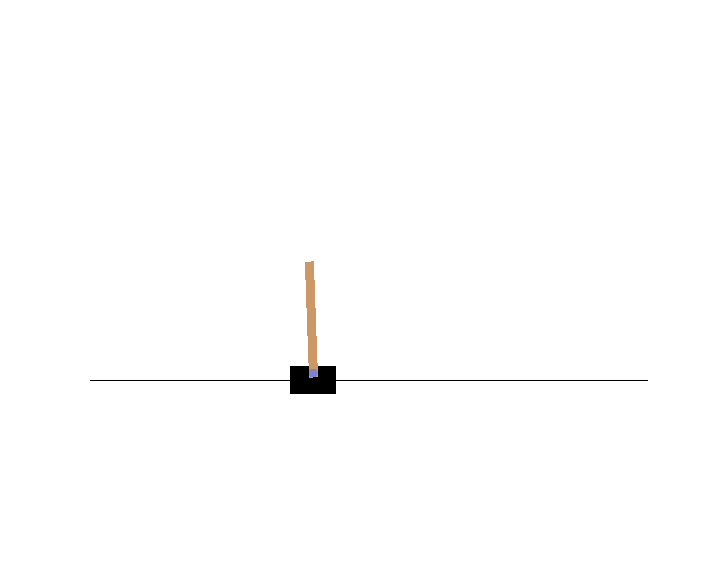
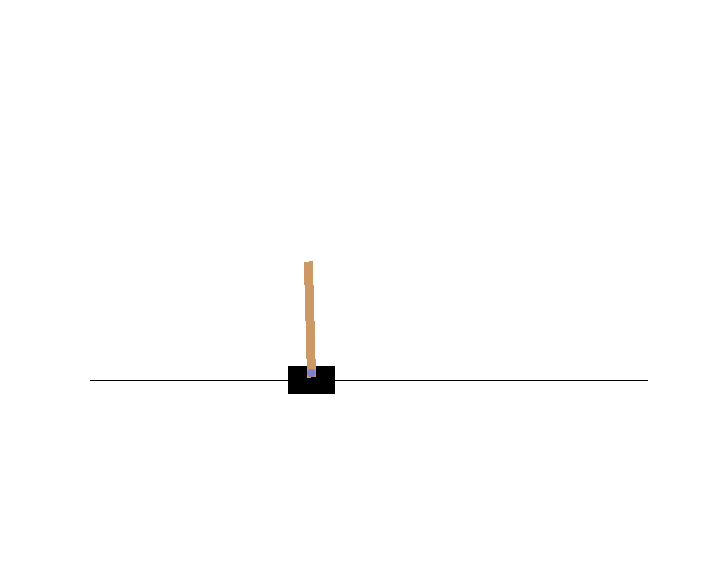
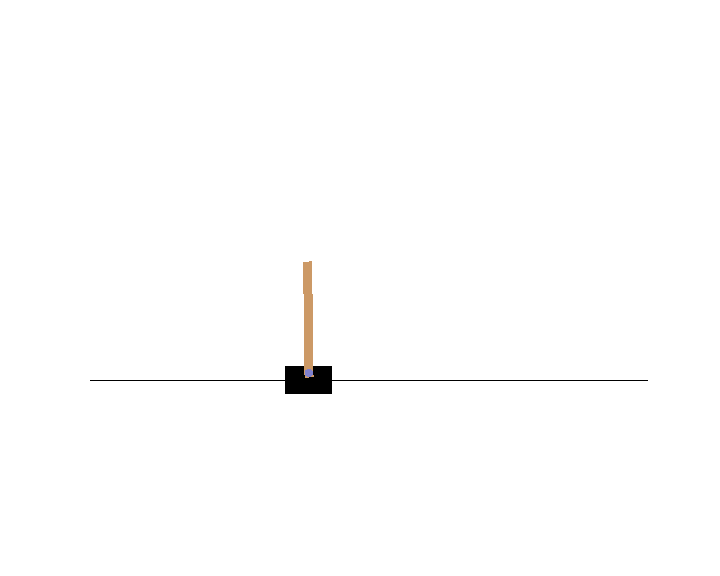
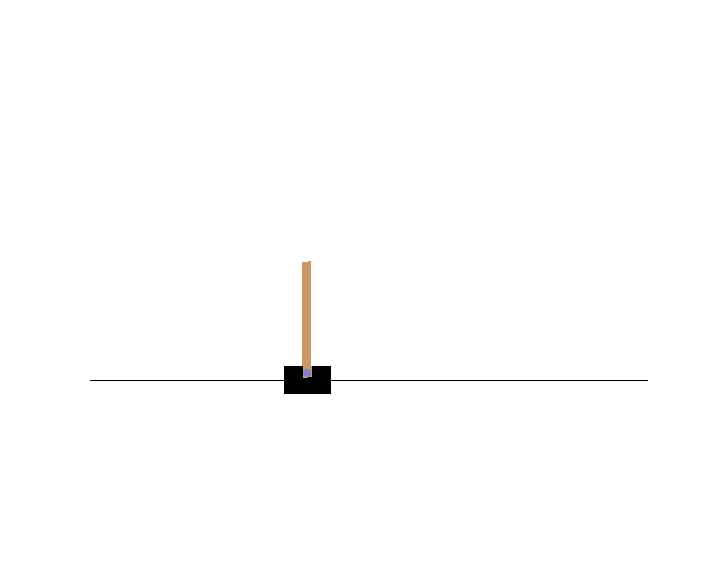
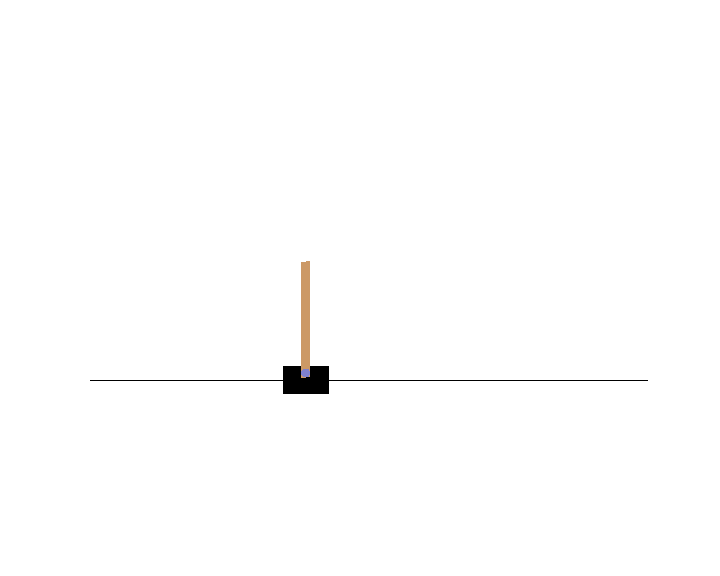
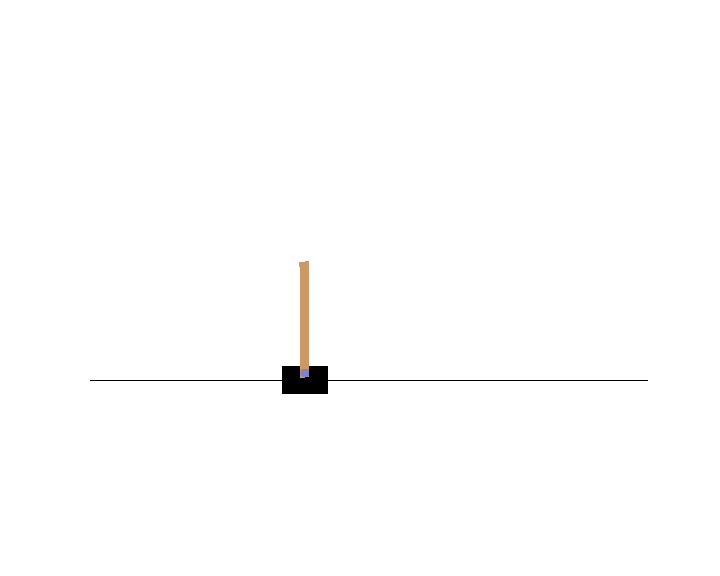
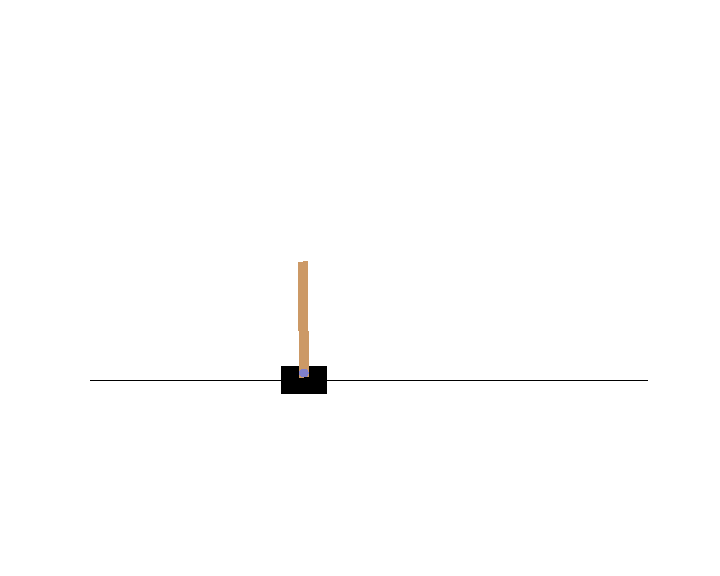
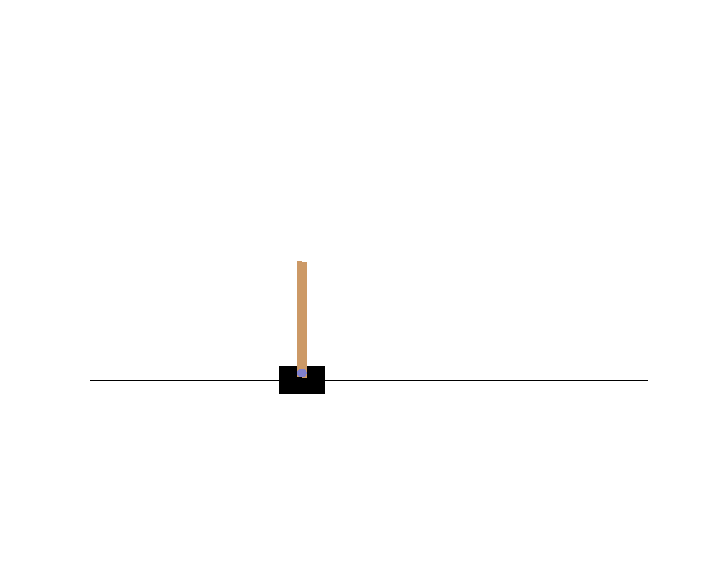
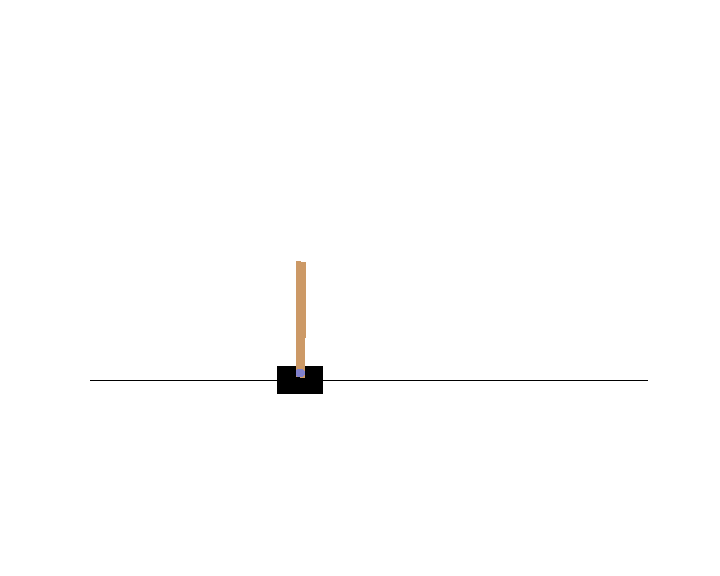
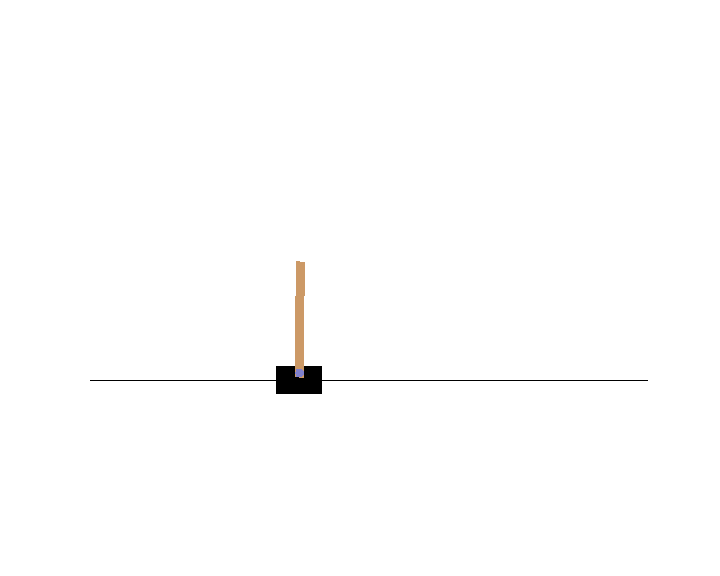
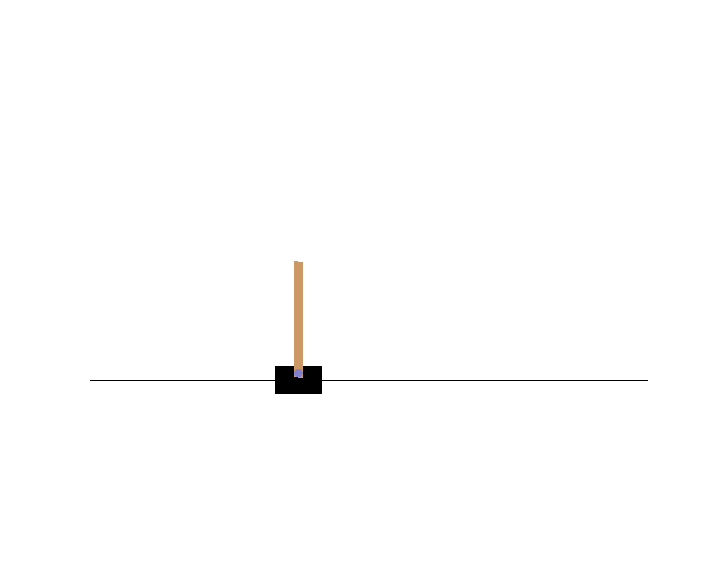
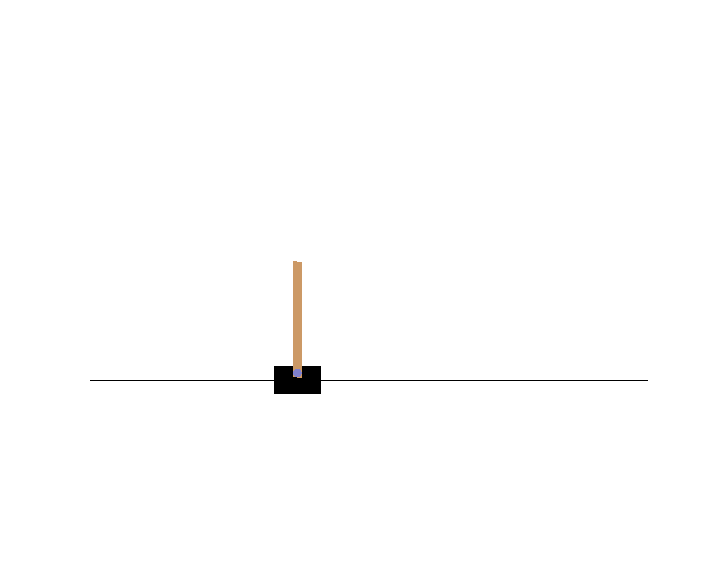
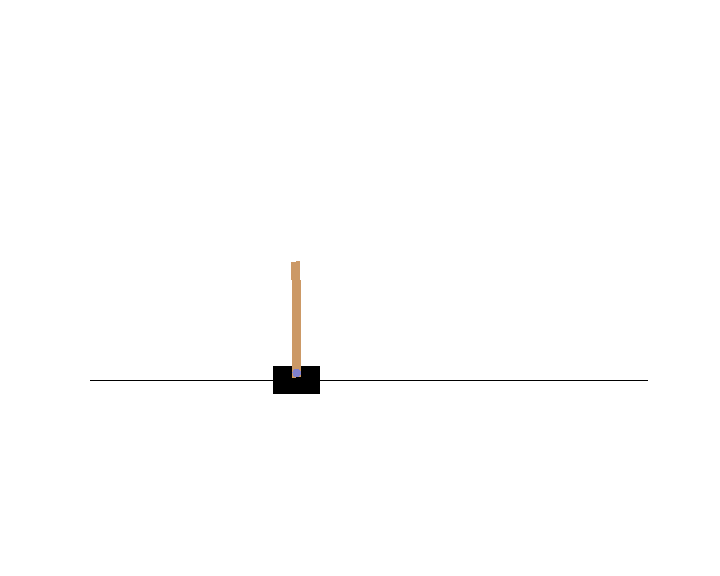
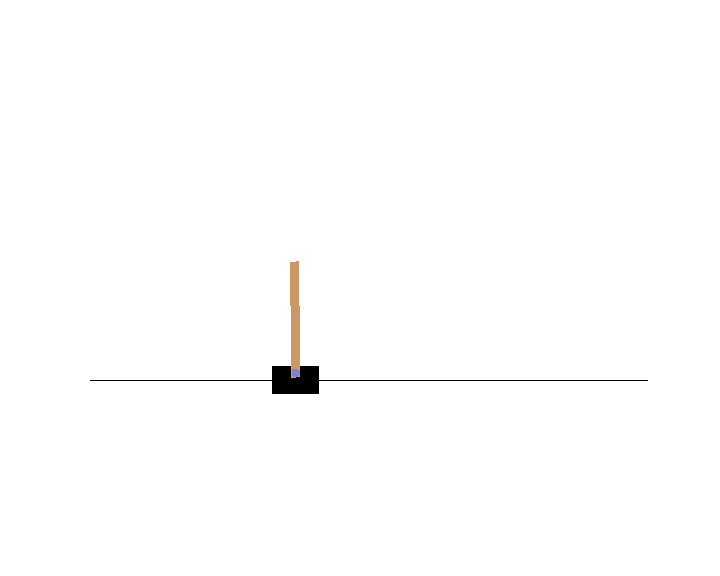
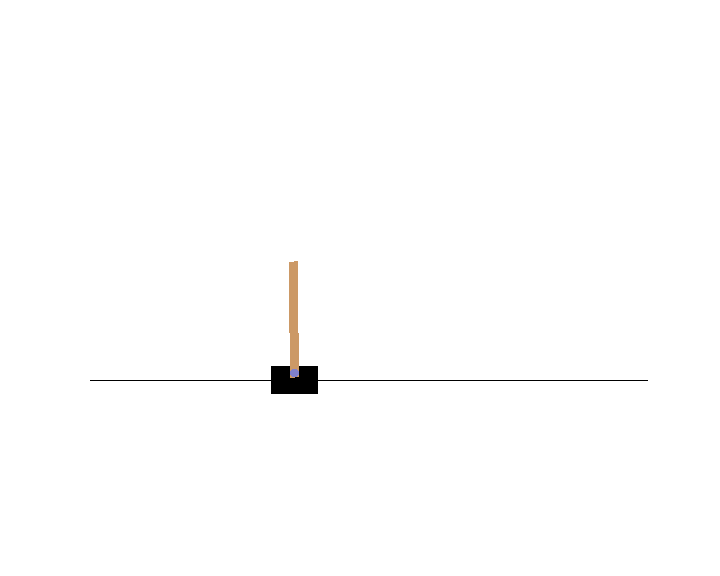
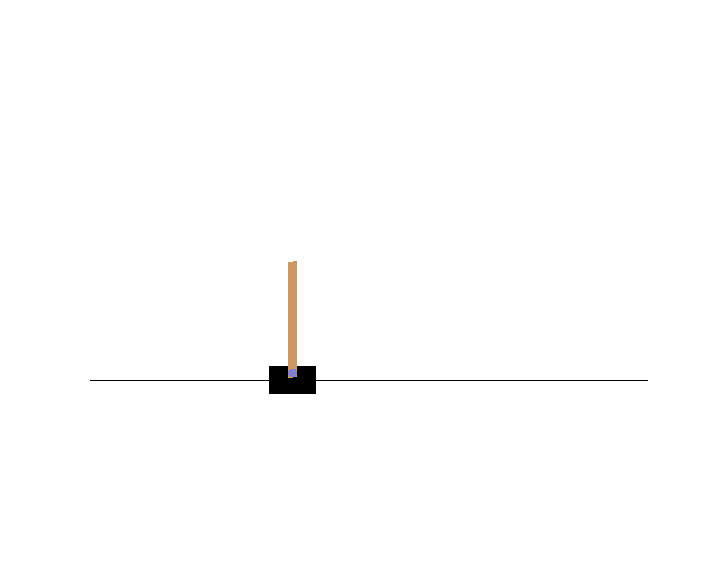
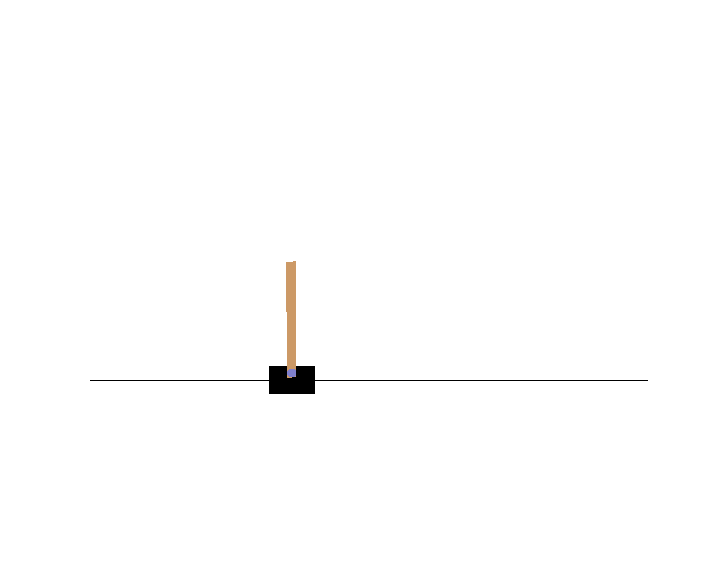
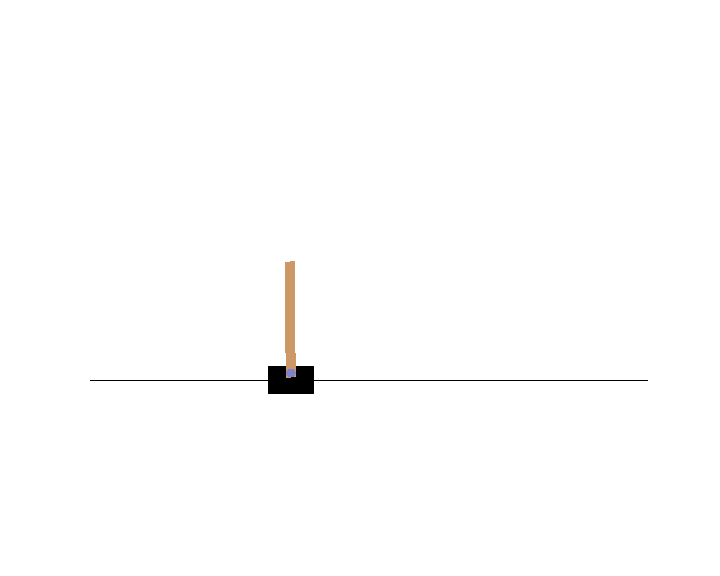
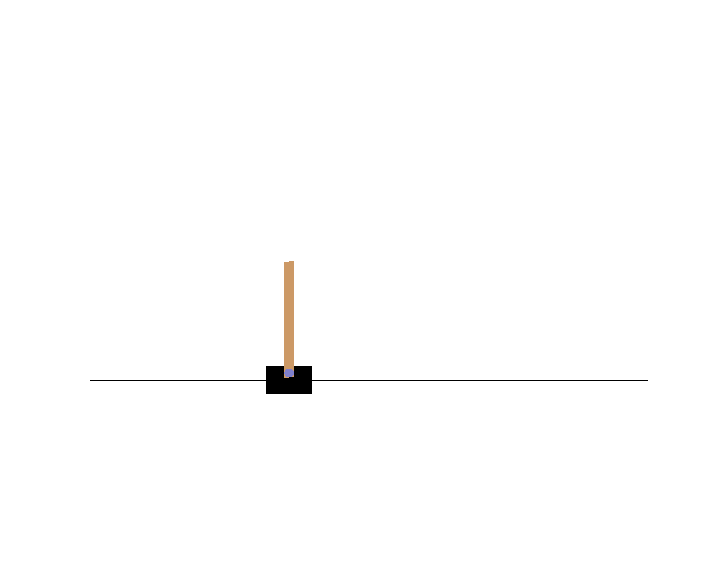
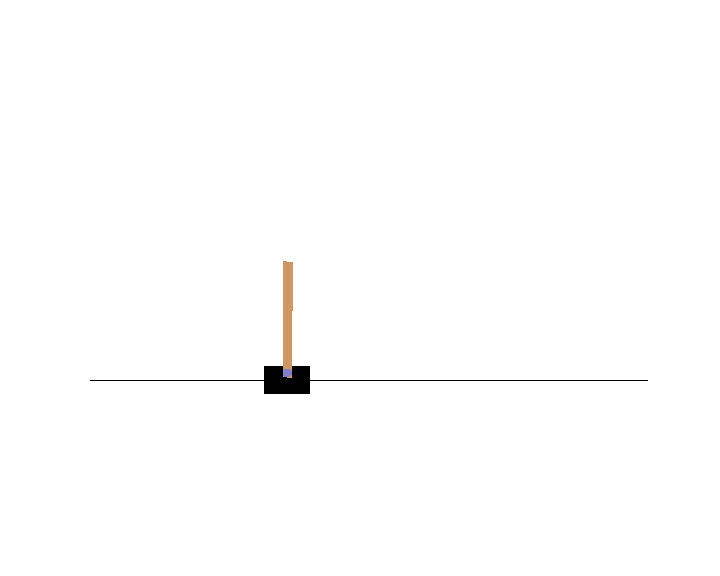
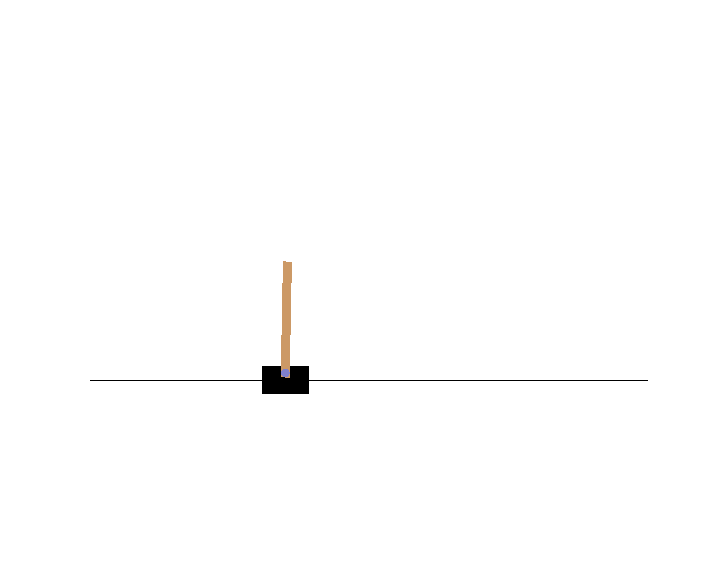
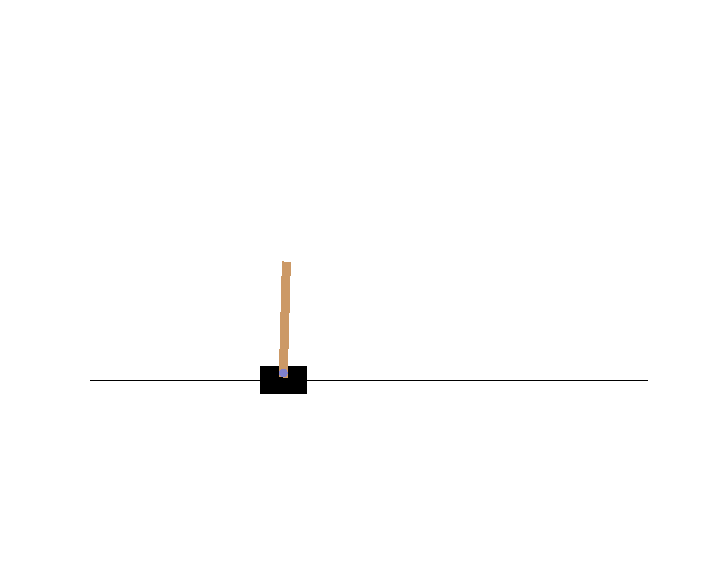
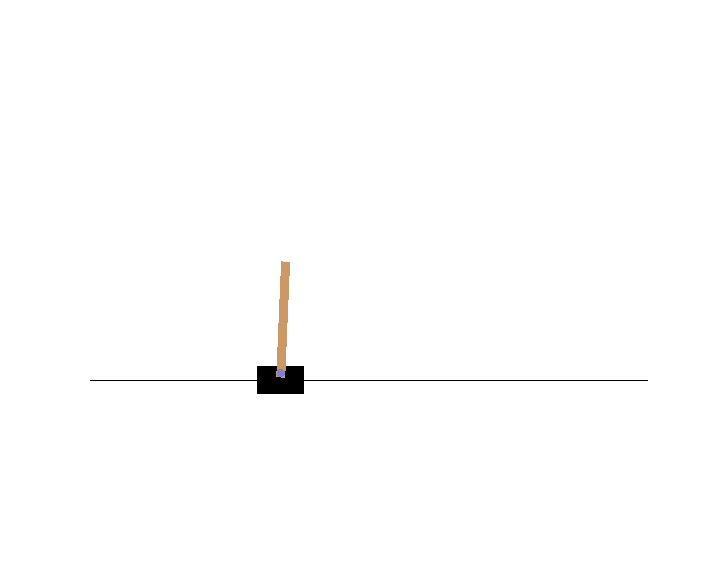
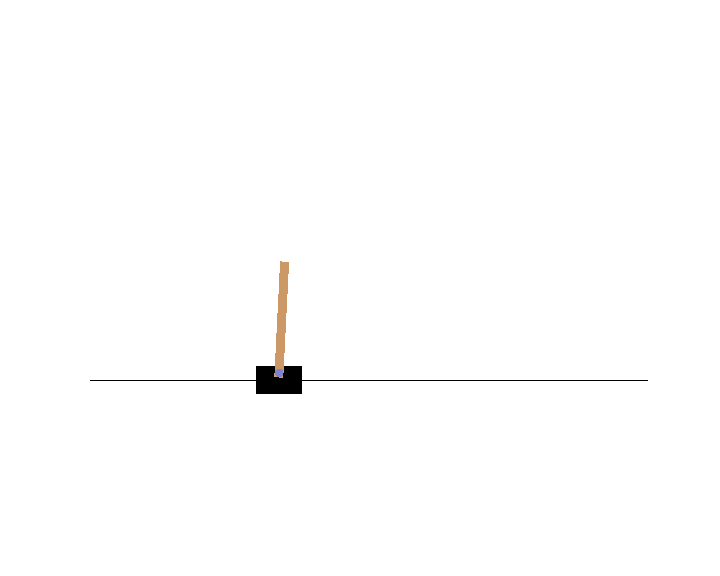
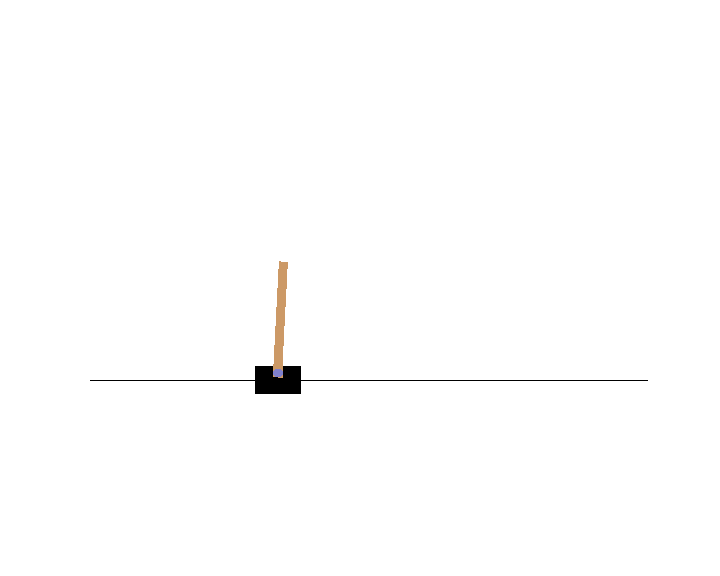
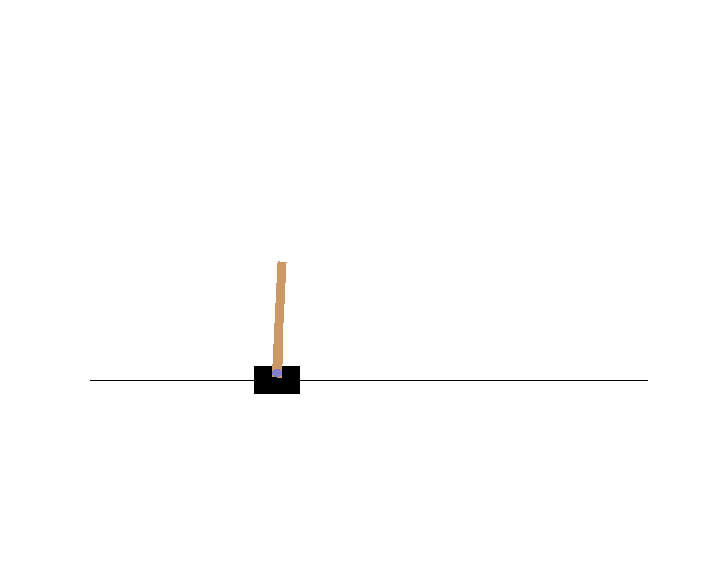
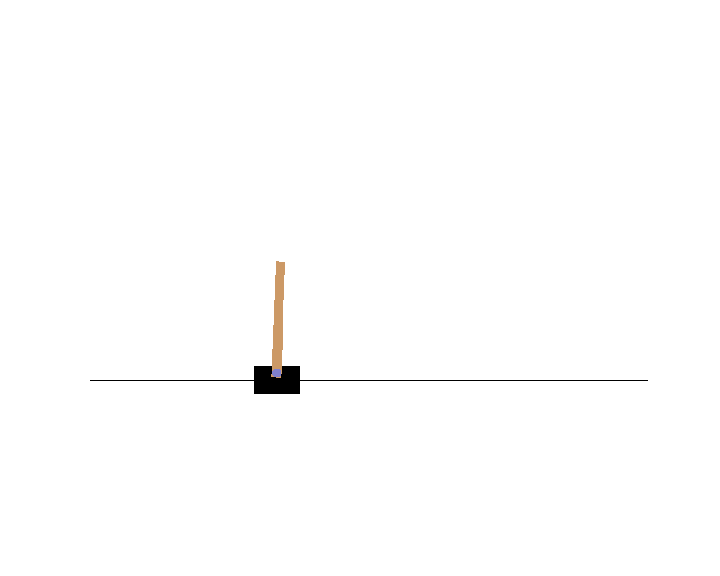
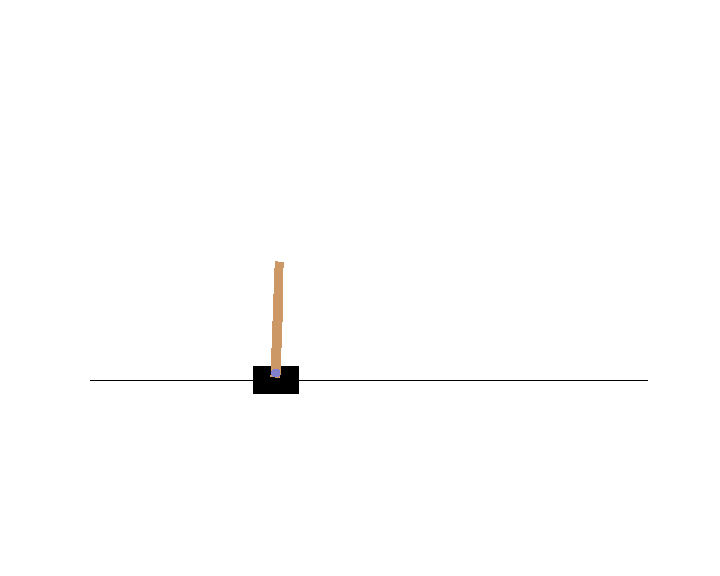
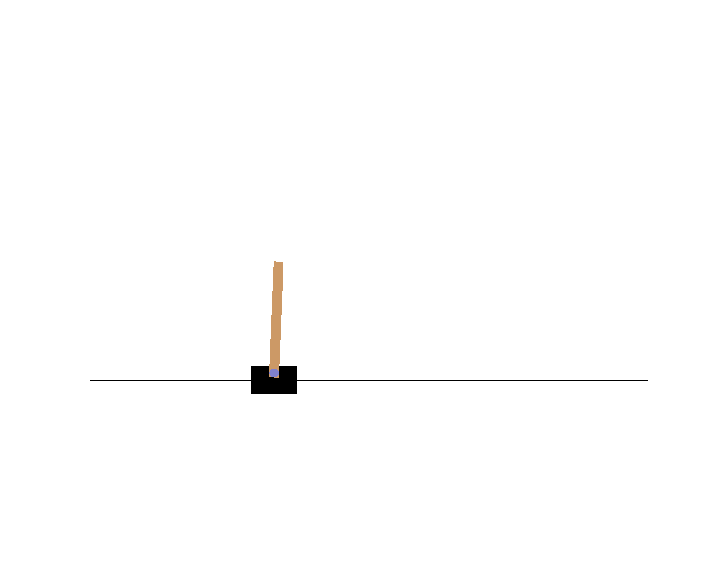
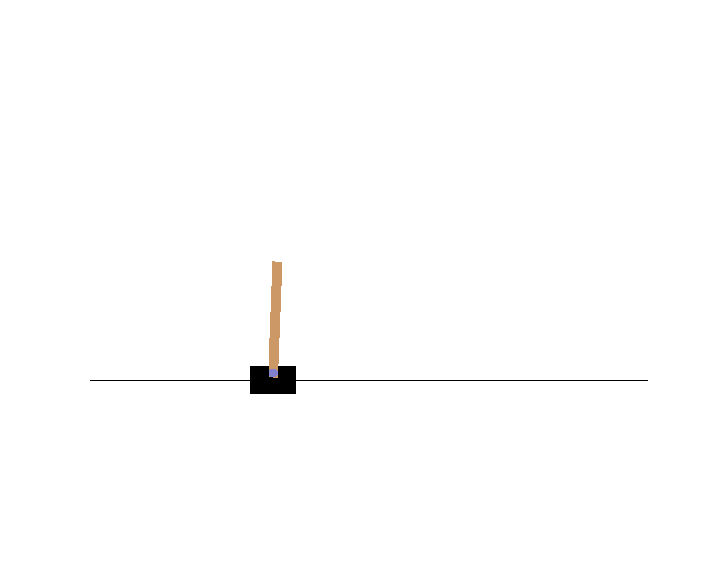
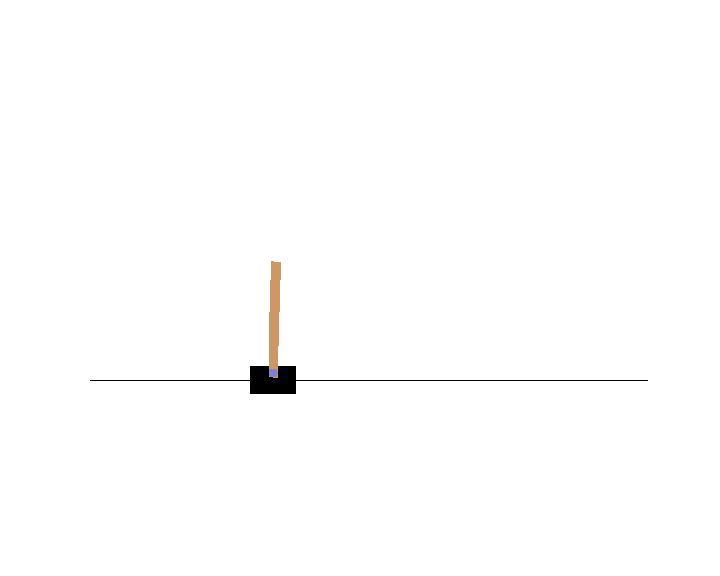
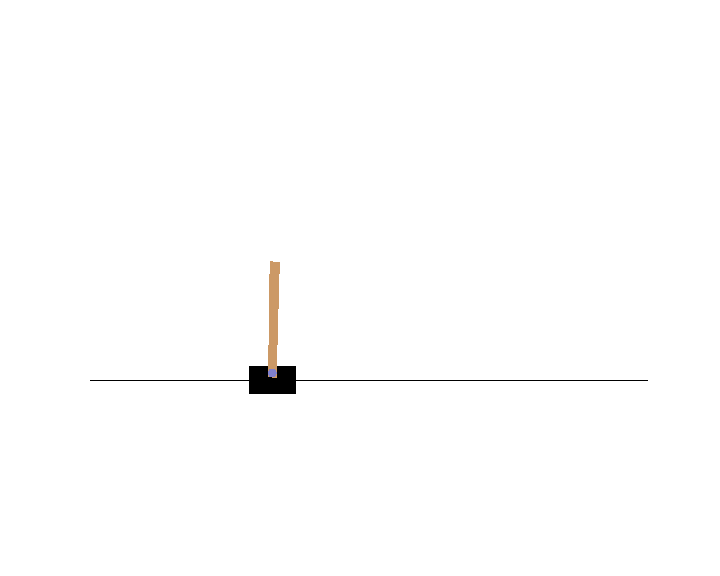
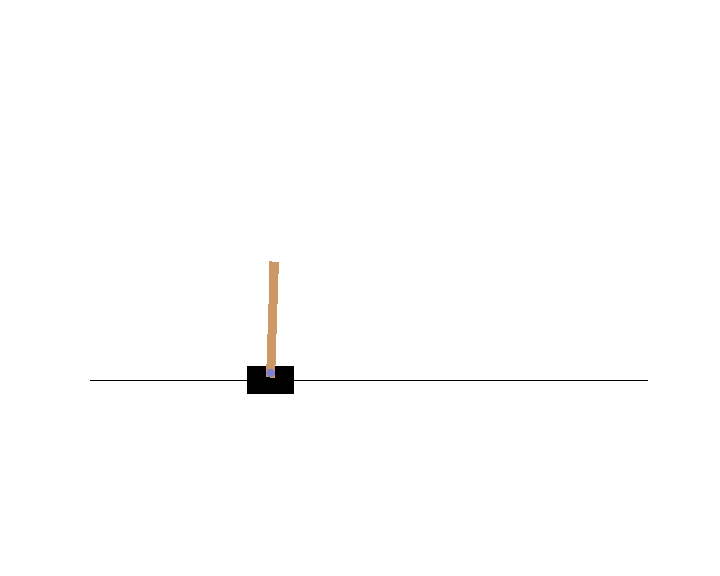
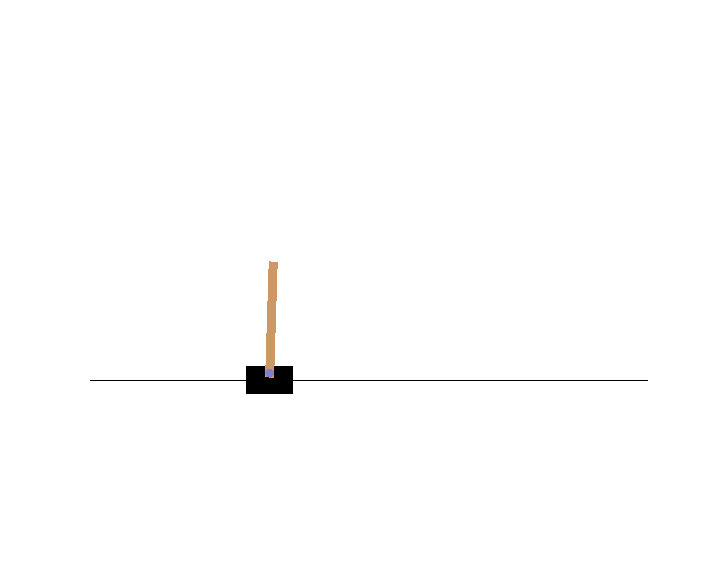
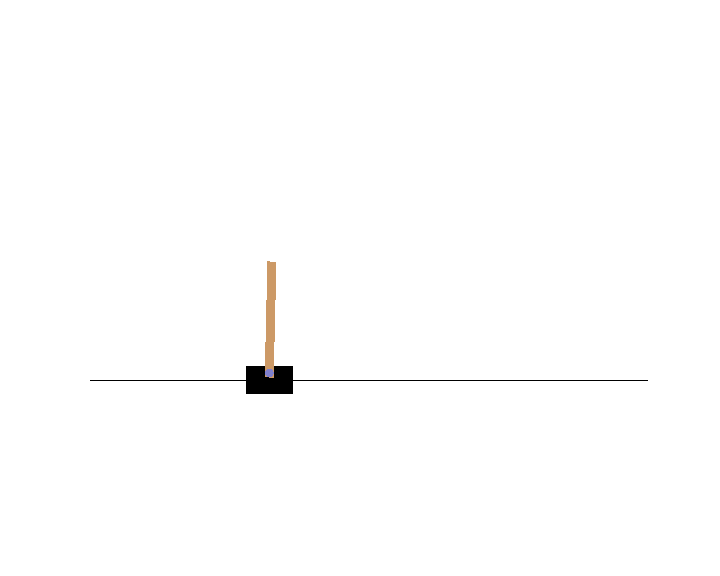
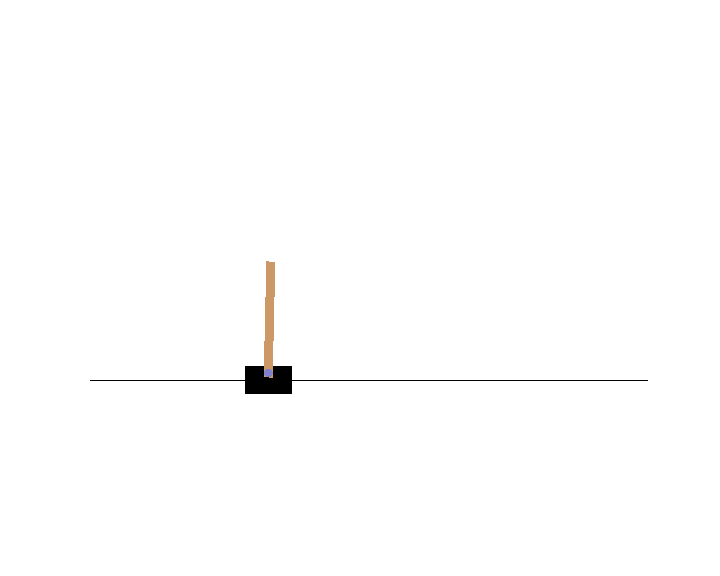
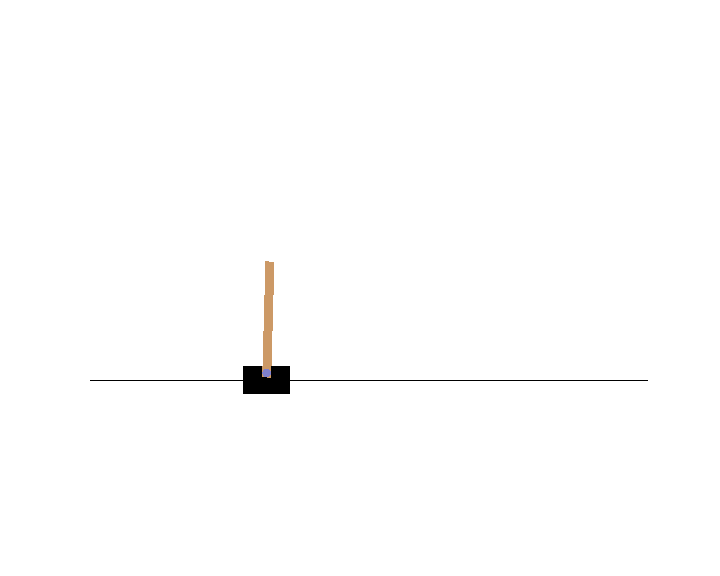
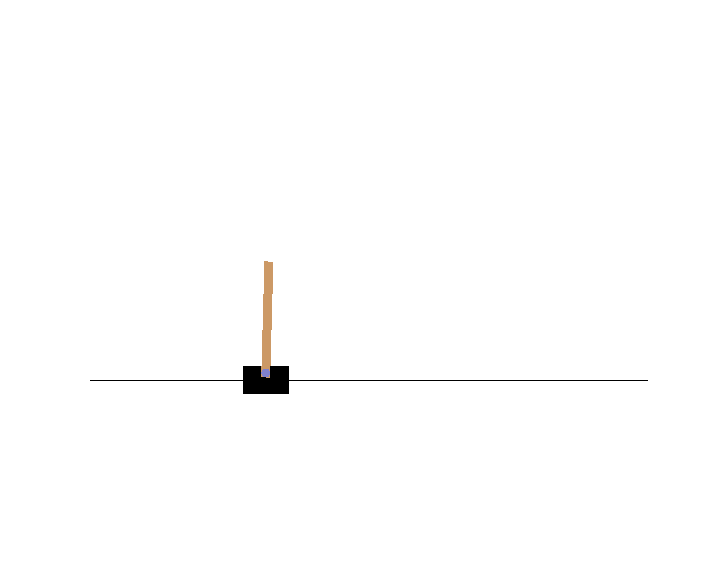
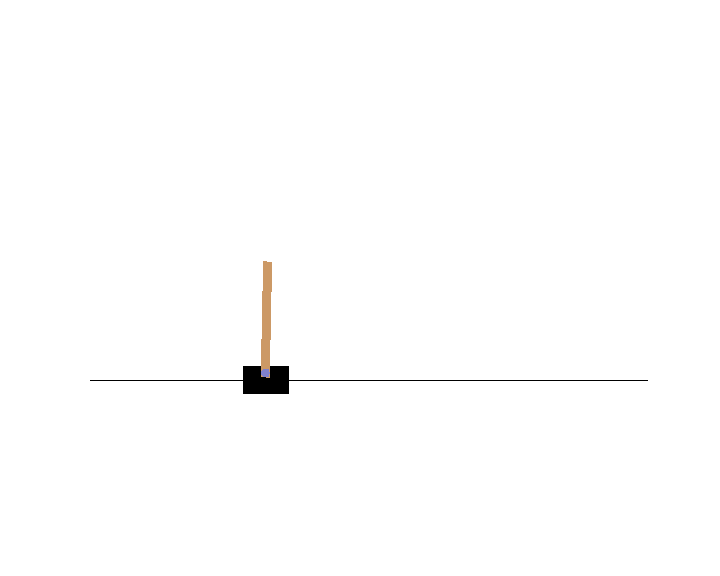
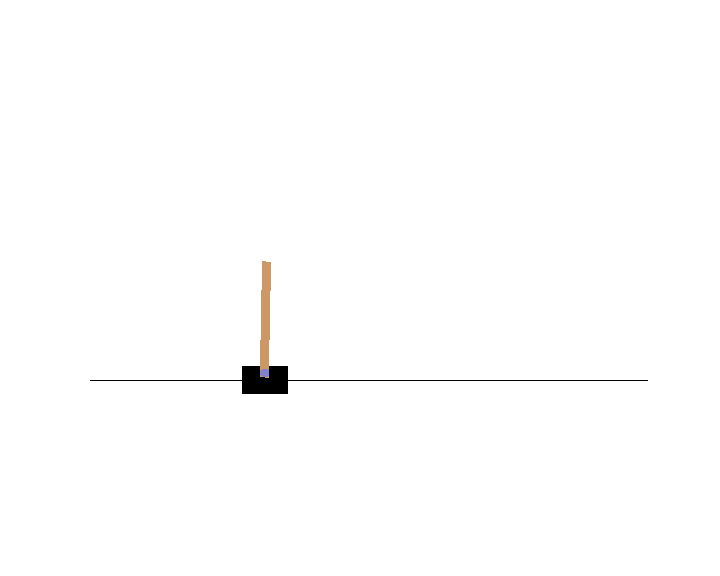
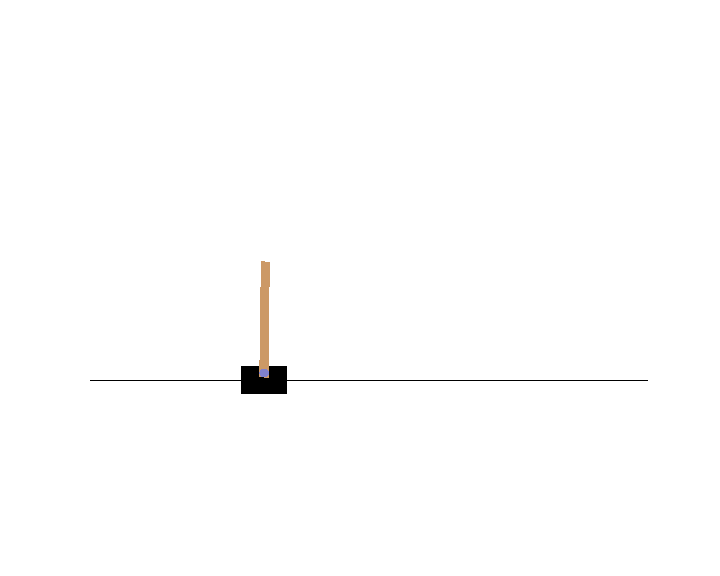

In [16]:
for i in frames:
    print "%d-th Episode" % i
    display_frames_as_gif(frames[i])

# Reference
* Based on this: https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724

# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.